# Machine Learning Engineer Nanodegree 

## Capstone Project:  "Multi-Class Text Classification with Convolutional Neural Nets"

**Álvaro Santamaría Herrero**. January 2019.

This notebook summarises the investigation process and contains all the produced code. 

 See the final  complete report and initial project proposal in the two companion pdf files.

# Project Proposal

## Domain Background

**Natural Language Processing** (NLP) is the sub-field of AI (Artificial Intelligence) that is focused on enabling computers to understand and process human languages. Text classification is one of the tasks within the NLP domain, and it is about applying Machine Learning to assign a category to each document in a corpus. Traditionally, the task of classifying text with Machine Learning models has been carried out by applying non-deep-learning classifiers, e.g., very commonly Support Vector Machines and Naïve Bayes classifiers, and based on an approach that disregards text sequence structure and treats each document as a "bag of words". Each document is then encoded as a sparse vector in a high dimensional space, possibly using refinements in the encoding as TFIDF (Term Frequency Inverse Document Frequency). See [Provost and Fawcett2013], Chapter 10: Representing and Mining Text.

Newer methods for text classification in the context of NLP have been based on application of deep learning, i.e., **deep neural networks**. The most natural approach has been that of applying Recurrent Neural Networks (RNN), with further refined variants as Long Short-Term Memory (LSTM) and Gateway Recurrent Units (GRU) [Chollet2018]. Theses ones seemed most suited to the task as they deal naturally with the input as a sequence. However, recent experiments have shown that another variant of neural networks, **Convolutional Neural Nets** (CNN), which have been applied with success to image classification, have shown promising results for text classification with relatively simple architectures. That's the case of [Kim2014], where a simple CNN is applied to obtain state-of-the-art scores on different datasets. Related research followed this paper and in [Zhang and Wallace2016] the authors compile the research so far and try to give a set of guidelines for practitioners to fine-tune the multiple parameters involved in such a CNN architecture. **In this project we will use this document as a reference and guide to build our own text CNN-based classifier**.

On the other hand, these methods for text classification based on neural networks, both RNN and CNN, require each document to be encoded not as a single vector that represents a whole document (like in the mentioned TFIDF approach) but as a sequence of vectors, each one representing a word or token. The simplest approach is to encode each word as a sparse, high-dimensional one-hot vector. However, current solutions try to transform that high-dimensional, inefficient encoding into a dense, low-dimensional space which in turn tries to encode semantic meaning in the distances and angles between vectors. These representations for text tokens are called "word embeddings". See [Chollet2018], Chapter 6: Deep learning for text and sequences. The most representative and currently used word embeddings are [word2vec](https://code.google.com/archive/p/word2vec/) and GloVe (Global Vectors for word representation) [Pennington et al.2014]. In the context of this project we will resort to the latter.

As for the types of dataset on which text classification techniques are applied, it's interesting to note that the most studied case is sentiment analysis, when a label of value positive or negative (and possibly neutral too) is assigned to each document. However, the experiments with multi-class datasets are less common. As an example, see the cited paper [Zhang and Wallace2016] where 9 datasets are used but only one (TREC) is a proper multi-class dataset. We find that there may be interesting multi-class text classification cases beyond sentiment analysis. E.g., posts in social networks where we would like to assign a political ideology or purchasing power to a user from the way they use the written language in such a context. In such example, we could target specific ad campaigns to selected groups of users. That would be something similar to the case of Facebook/Cambridge Analytica (see [Weapons of Micro Destruction: How Our ‘Likes’ Hijacked Democracy](https://towardsdatascience.com/weapons-of-micro-destruction-how-our-likes-hijacked-democracy-c9ab6fcd3d02) ) but using text posted by the users to the social network instead of their "likes". On top of all above, we find interesting to research **how important in a text the information that can be extracted from the sequential structure** (positional information) is, compared to the information that is available from the simple fact that a specific set of words are used. In many cases we may assume that most of the information is available simply from word presence, i.e., the vocabulary that is used. Thus, the question arises: is it worthy to try to extract additional information from text sequence structure when it means to resort to more complex and resource-expensive models?

## Problem Statement

We want to **apply a relatively simple convolutional neural net** (CNN) as described in the recent cited papers ([Kim2014], [Zhang and Wallace2016]) **to the supervised problem of multi-class text classification**. Allegedly, CNNs can extract patterns from the sequential structure of text and use this to improve classification scores. 

In addition, we want to **analyse and reflect on how much of the performance of the CNN-based classifier can be attributed to exploiting the sequential structure of the text** in comparison to the selection of the vocabulary (set of words). In other words, we will try to quantify how important sequential information is in comparison with information that is also present in the text but is not positionally encoded. 

Be aware that the potential amount of information that is positionally encoded in the text depends on the type of dataset and its label set. Note also that when we refer to "information" we mean information that is relevant to the specific classification task we are dealing with. 

We believe our approach is interesting at least for the following two reasons:

- Text classification studies for multi-class data sets are not that common.
- As presented in the references above, it is assumed that CNNs can work well for classifying text as they can potentially extract sequential patterns from text (as RNN do), but the reference studies do not try to quantify what's the importance of this positional information in the overall performance of the model. 

## Definitions and setup

*Choose the type of environment in the code cell below by setting variable `ENV` either to `colab` or to `local`. We run the notebook in Google Colab in order to take advantage of GPU acceleration.*

*We assume that all relevant work files, like saved models, will be in directory `./wrk`. Set variable `BASE_DIR` to define your base directory.  Note that when running the code in Google Colab, `BASE_DIR` directory is mounted from Google Drive.*

*Also, all the libraries are imported here. The main ones are [Keras](https://keras.io/), [Scikit-learn](https://scikit-learn.org/stable/), [Numpy](http://www.numpy.org/) and [Pandas](https://pandas.pydata.org/). And for data visualisation we import [Matplotlib](https://matplotlib.org/),  [Seaborn](https://seaborn.pydata.org/) and [Ggplot](http://ggplot.yhathq.com/).*

In [142]:
#%%############################################################################

###############################################################################
# DEFINITIONS
###############################################################################

#
# Two environments: Google Colab and local (Spyder).
# Set ENV reference.
#
ENV = 'colab'
#ENV = 'local'

#
# Set manually your working directories
#
BASE_DIR = '/content/drive/My Drive/UDACITY MLND' \
            if ENV == 'colab' else\
            '/Volumes/PENDRIVENEW/live!/PROJECTS/UDACITY_ML_NANODEGREE/my_MLND_projects/nlp-cnn'

#
# Model static configurations
#
NUM_WORDS = 10000 # Max number of words to be included when tokenizing (most frequent words)
EMBEDDING_DIMS = 100 # Number of dimensions for word embedding vectors
MAX_TEXT_LENGTH = 1000 # Max length of a text
N_CATEGORIES = 20 # Number of categories of the problem

#
# Model names
#
MODELS = ['A', 'B', 'C', 'D']

#
# Statistical
#
CONFIDENCE_LEVEL = 95

#
# File names per model (A,B,C,D)
#
WEIGHTS_FILENAME_A = 'modelA_weights.pdf5'
WEIGHTS_FILENAME_B = 'modelB_weights.pdf5'
WEIGHTS_FILENAME_C = 'modelC_weights.pdf5'
TRAIN_REPORT_FILENAME_A = 'modelA_report.pickle'
TRAIN_REPORT_FILENAME_B = 'modelB_report.pickle'
TRAIN_REPORT_FILENAME_C = 'modelC_report.pickle'

###############################################################################
# COLAB configuration
###############################################################################

if ENV == 'colab':
    #Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    #Check GPU
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    
    #Install ggplot (not by default in Colab)
    !pip install ggplot

###############################################################################
# IMPORTS
###############################################################################

import os
from math import log
from functools import reduce
from datetime import datetime
import pickle

import numpy as np
import pandas as pd
from scipy import stats

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Embedding, Conv1D, GlobalMaxPool1D, GlobalAveragePooling1D, Dense, Dropout
from keras.constraints import max_norm
from keras.callbacks import ModelCheckpoint
#from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
from matplotlib import colors
!pip install seaborn==0.9.0
import seaborn as sns

###############################################################################
# ENVIRONMENT
###############################################################################
# Working directory
WRK_DIR = os.path.join(BASE_DIR, 'wrk')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found GPU at: /device:GPU:0


In [0]:
#%%############################################################################

#
# Google Colab installs an older version of Seaborn by default (0.7.0)
# When a new environment is allocated, Seaborn 0.9.0 is installed but
# Seaborn 0.7.0 has already been imported.
# If this happens, it is needed to restart the kernel and re-run
#
assert sns.__version__ == '0.9.0', f'Make sure Seaborn version \
is 0.9.0 or higher (version {sns.__version__} detected) \
and restart Google Colab notebook'

In [145]:
#%%############################################################################

#
# Print versions of used libraries
#

import platform

import numpy as np
import pandas as pd
import scipy

import keras
import sklearn

import matplotlib
import seaborn as sns

libraries = sorted([np, pd, scipy, keras, sklearn, matplotlib, sns], 
                   key=lambda l: l.__name__)

def print_library_version(pkg):
    ''' Prints library name and version'''
    
    print(f'    {pkg.__name__}: {pkg.__version__}')
 

print(f'Python version: {platform.python_version()}')

print(f'Libraries:')
[print_library_version(p) for p in libraries]
None

Python version: 3.6.7
Libraries:
    keras: 2.2.4
    matplotlib: 2.1.2
    numpy: 1.14.6
    pandas: 0.22.0
    scipy: 1.1.0
    seaborn: 0.9.0
    sklearn: 0.20.2


## Dataset and inputs


We will use a single multi-class dataset: [20 Newsgroups](http://qwone.com/%7Ejason/20Newsgroups/). The "20 newsgroups" dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date. The test split accounts for approximately the 40% of the dataset.

The dataset can be directly imported from the [scikit-learn](http://scikit-learn.org/0.19/index.html) library.

In [0]:
#%%############################################################################

#
# Import 20newsgroups dataset
#

raw_dataset_train = fetch_20newsgroups(subset='train',
                                    random_state=42)
raw_dataset_test = fetch_20newsgroups(subset='test',
                                   random_state=42)

dataset_train = fetch_20newsgroups(subset='train',
                                    random_state=42,
                                    remove=('headers', 'footers', 'quotes'))
dataset_test = fetch_20newsgroups(subset='test',
                                   random_state=42,
                                   remove=('headers', 'footers', 'quotes'))

In [0]:
#%%############################################################################

#
# Extract documents and target names
#

texts_train = dataset_train.data
texts_test = dataset_test.data

targets_train = dataset_train.target
targets_test = dataset_test.target

target_names = dataset_train.target_names

def get_target_name(target_number):
    try:
        return target_names[target_number]
    except:
        return None

Number of documents, as imported from `scikit-learn`:

In [148]:
#%%############################################################################

#
# Analysis of dataset: number of documents in train and text splits
#

tr_N = len(texts_train)
te_N = len(texts_test)
N = tr_N + te_N

print(f"Training dataset: {tr_N} documents.")
print(f"Test dataset: {te_N} documents.")
print(f"Total in 20 Newsgroup dataset: {N} documents.")

Training dataset: 11314 documents.
Test dataset: 7532 documents.
Total in 20 Newsgroup dataset: 18846 documents.


### Classes

The 20 labels (newsgroups) are the following:

In [149]:
#%%############################################################################

#
# Enumeration of target classes
#

print()
print('TARGET NAMES:')
print('\n'.join(target_names))
print()


TARGET NAMES:
alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc



As the reference above points out: 

> Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian). Here is a list of the 20 newsgroups, partitioned (more or less) according to subject matter: [...]

Group A:

* comp.graphics
* comp.os.ms-windows.misc
* comp.sys.ibm.pc.hardware
* comp.sys.mac.hardware
* comp.windows.x

Group B:

* rec.autos
* rec.motorcycles
* rec.sport.baseball
* rec.sport.hockey

Group C:

* sci.crypt
* sci.electronics
* sci.med
* sci.space

Group D:

* misc.forsale

Group E: 

* talk.politics.misc
* talk.politics.guns
* talk.politics.mideast

Group F:

* talk.religion.misc
* alt.atheism
* soc.religion.christian

The split of documents by class is the following for the training set: 

In [0]:
#%%############################################################################

#
# Split per class (train and test datasets)
#

named_target_train = map(lambda x: target_names[x]  , targets_train)
mydf_train = pd.DataFrame({'target number': dataset_train.target, 'target name': list(named_target_train) }  )
classes_summary_train = mydf_train.groupby('target name', as_index=False).count().rename(columns={'target number':'count'})

named_target_test = map(lambda x: target_names[x]  , targets_test)
mydf_test = pd.DataFrame({'target number': dataset_test.target, 'target name': list(named_target_test) }  )
classes_summary_test = mydf_test.groupby('target name', as_index=False).count().rename(columns={'target number':'count'})

In [151]:
#%%############################################################################

classes_summary_train

,target name,count
0,alt.atheism,480
1,comp.graphics,584
2,comp.os.ms-windows.misc,591
3,comp.sys.ibm.pc.hardware,590
4,comp.sys.mac.hardware,578
5,comp.windows.x,593
6,misc.forsale,585
7,rec.autos,594
8,rec.motorcycles,598
9,rec.sport.baseball,597


In [152]:
#%%############################################################################

classes_summary_test

,target name,count
0,alt.atheism,319
1,comp.graphics,389
2,comp.os.ms-windows.misc,394
3,comp.sys.ibm.pc.hardware,392
4,comp.sys.mac.hardware,385
5,comp.windows.x,395
6,misc.forsale,390
7,rec.autos,396
8,rec.motorcycles,398
9,rec.sport.baseball,397


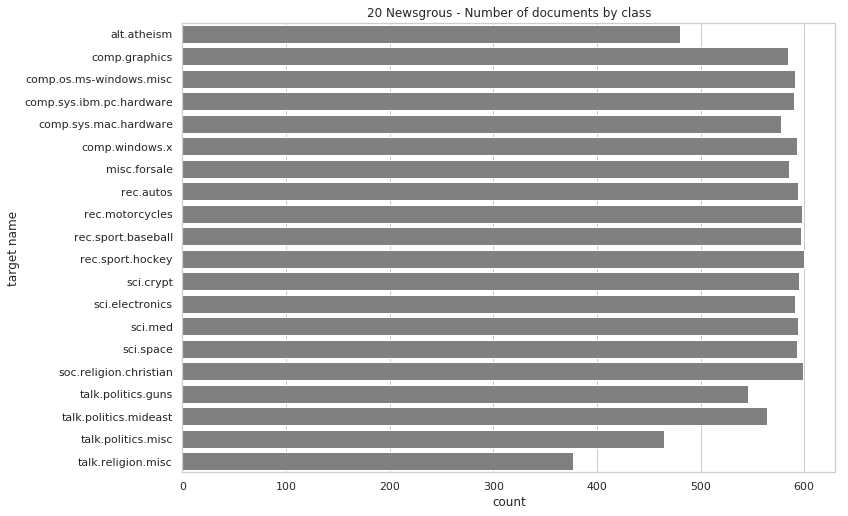

In [153]:
#%%############################################################################

#
# Split per class (train dataset) - Graphically
#

sns.set(style="whitegrid", rc={'figure.figsize':(11.7,8.27)})
ax1 = sns.barplot(y="target name", x="count", color="grey", data=classes_summary_train)
ax1.set_title("20 Newsgrous - Number of documents by class")
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

ax1.figure.savefig(os.path.join(WRK_DIR, 'chart_01.pdf'))

### Entropy of the dataset

In [0]:
#%%############################################################################

#
# Entropy calculation
#
def H(l):
    ''' Entropy calculation from a list of integers 
        that represent number of occurrences for each class.
    '''
    total = sum(l)

    probabilities = map(lambda x: x/total  , l)

    def plog2(x):
        if x == 0.0:
            return 0
        else:
            return (- x * log(x,2))

    informations = map(plog2 , probabilities)
    return sum(informations)

In [157]:
#%%############################################################################

#
# Entropy of the training set
#

entropy_train = H(classes_summary_train['count'].values)
entropy_test = H(classes_summary_test['count'].values)


print(f'Entropy of training set: {entropy_train:.3f} bits.')
print(f'Entropy of test set: {entropy_test:.3f} bits.')

Entropy of training set: 4.314 bits.
Entropy of test set: 4.314 bits.


According to the previous distribution of classes, the **entropy of the dataset** (both training and test split) is **4.314 bits**. 
Where entropy is defined as: 

$$ H = - \sum_{i=1}^{20}  p_i \log_2(p_i) $$

where $ p_i $ is the proportion or relative frequency of each class in the dataset. The entropy for a perfectly balanced dataset of 20 classes would be 4.322, less than 0.2% away from our dataset's, thus we can say we have a fairly balanced dataset in terms of class distribution.


### Document structure

The content of the documents is that of an e-mail. Thus, in addition to the body of the message, we have additional header fields, possibly footers, and also inline quotes. As pointed out in the [scikit-learn documentation](https://scikit-learn.org/stable/documentation.html), all of them, headers, footers and quotes,  make the classifier to easily overfit. For that reason, we will remove them. Quote from scikit-learn documentation:

> When evaluating text classifiers on the 20 Newsgroups data, you should strip newsgroup-related metadata. In scikit-learn, you can do this by setting remove=('headers', 'footers', 'quotes'). The F-score will be lower because it is more realistic.

Here we have some examples from the training set:

In [158]:
#%%############################################################################

#
# Document samples
#

def print_raw_and_clean_document(idx):
    print(f'\n==== Original document ({idx}) ===========')
    print(raw_dataset_train.data[idx])
    print(f'\n==== Cleaned document ({idx}) ============')
    print(texts_train[idx])
    print('\n========================================')

print_raw_and_clean_document(201)
print_raw_and_clean_document(302)
print_raw_and_clean_document(403)


==== Original document (201) ===========
From: mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier)
Subject: Re: 5W30, 10W40, or 20W50
Organization: University of Illinois at Urbana
Lines: 12

zowie@daedalus.stanford.edu (Craig "Powderkeg" DeForest) writes:

>If you're planning on making long drives, the 20W50 is probably fine
>(esp. in the summer) in your 10W40 car.  But if you're making short drives,
>stick to the 10W40.

Several years ago GM was having trouble with the rings sticking on the
5.7 diesel.  They traced a cause to the use of 10W-40 oil.  They would
not honor warranty work if 10W-40 was used (if my memory serves me).
5-30, 10-30 or 20 50 was OK'd though.

Mark B.


==== Cleaned document (201) ============


Several years ago GM was having trouble with the rings sticking on the
5.7 diesel.  They traced a cause to the use of 10W-40 oil.  They would
not honor warranty work if 10W-40 was used (if my memory serves me).
5-30, 10-30 or 20 50 was OK'd though.


==== Original document 

### Text length distribution

We will mesasure document lenght in number of tokens (words). In order to do that, we need to tokenize the documents in the corpus.

In [0]:
#%%############################################################################

#
# Split documents by words (tokenize)
#

tokenizer0 = Tokenizer()
tokenizer0.fit_on_texts(texts_train)

#
# These are the train and test datasets expressed as sequences of integers after tokenisation.
#
text_sequences_train = tokenizer0.texts_to_sequences(texts_train)
text_sequences_test  = tokenizer0.texts_to_sequences(texts_test)

In [160]:
#%%############################################################################

#
# Let's check that tokenization works
#

def show_tokenization(tokenizer, dataset, i):
    """ Prints how a document is tokenized.
        
        Params:
        - tokenizer: trained tokenizer.
        - dataset: train or test dataset.
        - i: index of the document withing the dataset.
    """

    print(f'\n---   Tokenization of document {i} --------------------------------------------')
    print( dataset[i] )
    print()
    print( tokenizer.texts_to_sequences([dataset[i]])[0] )
    print()
    print( [tokenizer.index_word[i] for i in tokenizer.texts_to_sequences([dataset[i]])[0]] )
    print(f'-----------------------------------------------------------------------------')
    
show_tokenization(tokenizer0, texts_train, 3)
show_tokenization(tokenizer0, texts_train, 6)



---   Tokenization of document 3 --------------------------------------------

Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.


[46, 13, 18, 46569, 397, 495, 189, 323, 72, 3, 81, 55, 169, 49, 14, 354]

['do', 'you', 'have', "weitek's", 'address', 'phone', 'number', "i'd", 'like', 'to', 'get', 'some', 'information', 'about', 'this', 'chip']
-----------------------------------------------------------------------------

---   Tokenization of document 6 --------------------------------------------
There were a few people who responded to my request for info on
treatment for astrocytomas through email, whom I couldn't thank
directly because of mail-bouncing probs (Sean, Debra, and Sharon).  So
I thought I'd publicly thank everyone.

Thanks! 

(I'm sure glad I accidentally hit "rn" instead of "rm" when I was
trying to delete a file last September. "Hmmm... 'News?' What's
this?"....)

[43, 68, 5, 234, 69, 63, 3772, 3, 41, 736, 12, 352, 15, 1671,

We calculate the statistics of document legnths for both training and test datasets.

In [161]:
#%%############################################################################

#
# Document length statistics
#

# Training dataset
text_lengths_train = pd.DataFrame({'length' : [len(d) for d in text_sequences_train],
                                   'target name' : [get_target_name(t) for t in targets_train],
                                   'split' : len(text_sequences_train) * ['train']})
                                   

# Test dataset
text_lengths_test = pd.DataFrame({'length' : [len(d) for d in text_sequences_test],
                                  'target name' : [get_target_name(t) for t in targets_test],
                                  'split' : len(text_sequences_test) * ['test']})

# Combined dataset (train + test)
text_lengths_ALL = pd.concat([text_lengths_train, text_lengths_test],
                             ignore_index=True)

# Show a sample of the document lengths (plus target name and dataset split)
text_lengths_ALL.tail(6)

,length,split,target name
18840,216,test,rec.autos
18841,155,test,sci.space
18842,17,test,comp.sys.mac.hardware
18843,124,test,rec.sport.baseball
18844,118,test,misc.forsale
18845,65,test,soc.religion.christian


The text length distributions, measured in number of words (tokens as split by keras tokenizer), is as follows.

For the training set:

In [162]:
#%%############################################################################

#
# Training set stats
#

print ('Training set statistics (length in number of tokens).')
text_lengths_train.describe()

Training set statistics (length in number of tokens).


,length
count,11314.000000
mean,210.552236
std,778.535062
min,0.000000
25%,41.000000
50%,85.000000
75%,169.000000
max,16306.000000


Test set:

In [163]:
#%%############################################################################

#
# Test set stats
#

print ('Test set statistics:')
text_lengths_test.describe()

Test set statistics:


,length
count,7532.000000
mean,179.106346
std,583.172570
min,0.000000
25%,39.000000
50%,81.000000
75%,162.000000
max,28592.000000


Combined set (training and test):

In [20]:
#%%############################################################################

#
# Combined set stats
#

print ('Combined (training + test) set statistics:')
text_lengths_ALL.describe()

Combined (training + test) set statistics:


,length
count,18846.000000
mean,197.984559
std,707.113941
min,0.000000
25%,40.000000
50%,83.000000
75%,167.000000
max,28592.000000


We display length distribution visually for the combined dataset.

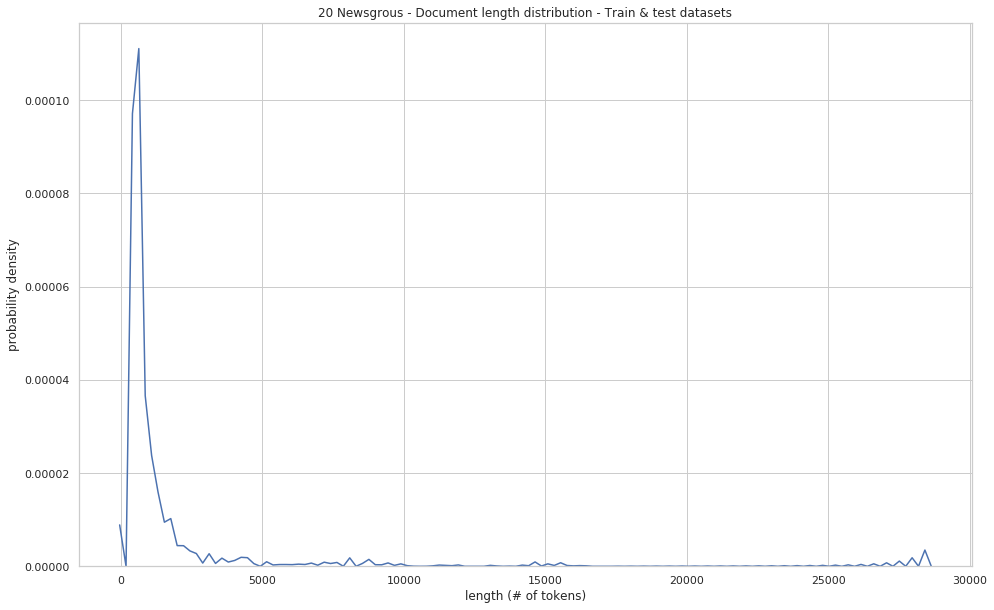

In [164]:
#%%############################################################################

#
# Plot Statistical distribution of the combined set
#

sns.set(style="whitegrid", rc={'figure.figsize':(16.0,10.0)})
ax2 = sns.distplot(text_lengths_ALL['length'], hist=False, rug=False)

ax2.set_title("20 Newsgrous - Document length distribution - Train & test datasets")
ax2.set(ylabel='probability density', xlabel='length (# of tokens)')
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

ax2.figure.savefig(os.path.join(WRK_DIR, 'chart_02.pdf'))

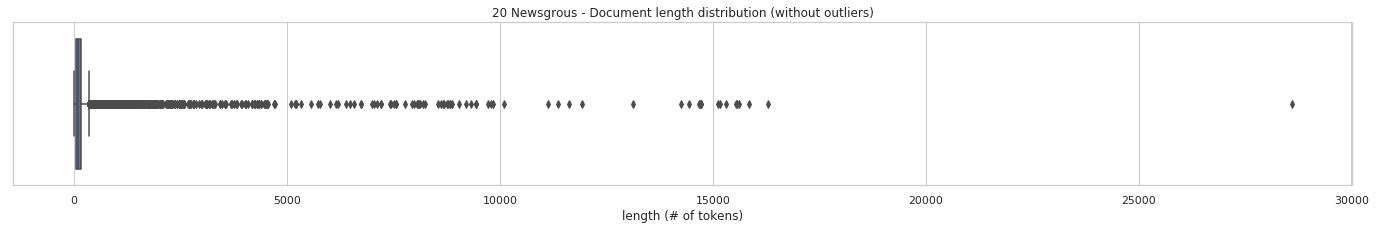

In [166]:
#%%############################################################################

#
# Plot Statistical distribution of the combined set.
# Box-plots per dataset split (train/test) and without outliers.
#

sns.set(style="whitegrid", rc={'figure.figsize':(24.0,3.0)})
ax3 = sns.boxplot(x='length', data=text_lengths_ALL, showfliers= True);

ax3.set_title("20 Newsgrous - Document length distribution (without outliers)")
ax3.set(xlabel='length (# of tokens)')
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

ax3.figure.savefig(os.path.join(WRK_DIR, 'chart_03.pdf'))

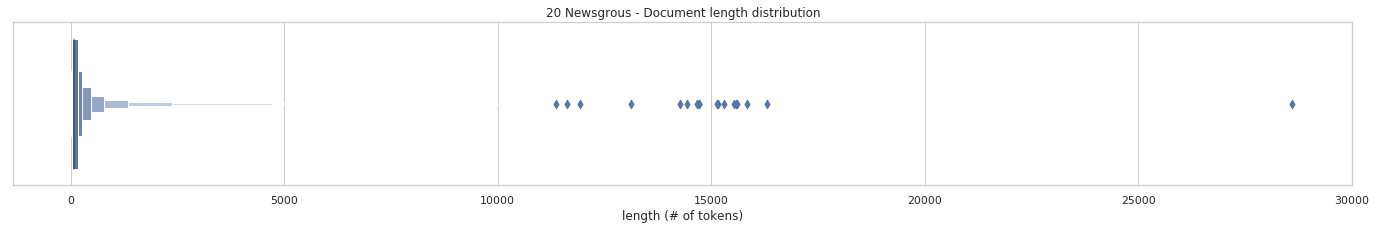

In [167]:
#%%############################################################################

#
# Plot Statistical distribution of the combined set.
# Letter-value plot 
# https://vita.had.co.nz/papers/letter-value-plot.html
#

sns.set(style="whitegrid", rc={'figure.figsize':(24.0,3.0)})
ax4 = sns.boxenplot(x='length', data=text_lengths_ALL);

ax4.set_title("20 Newsgrous - Document length distribution")
ax4.set(xlabel='length (# of tokens)')
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

ax4.figure.savefig(os.path.join(WRK_DIR, 'chart_04.pdf'))

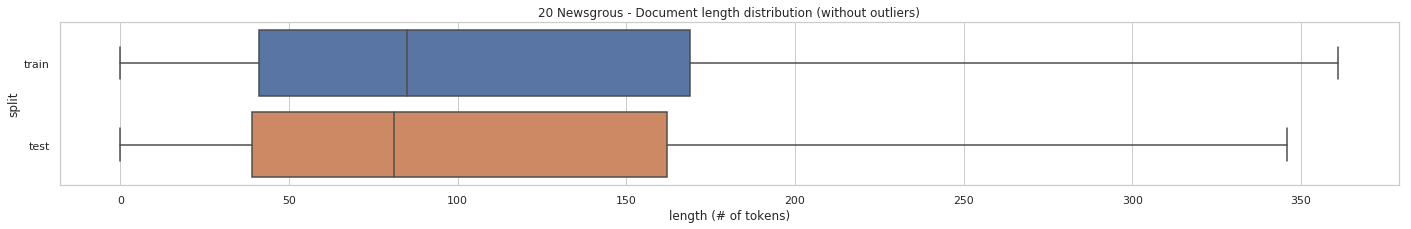

In [168]:
#%%############################################################################

#
# Plot Statistical distribution of the combined set.
# Box-plots per dataset split (train/test) and without outliers.
#

sns.set(style="whitegrid", rc={'figure.figsize':(24.0,3.0)})
ax5 = sns.boxplot(x='length', y='split', data=text_lengths_ALL, showfliers= False);

ax5.set_title("20 Newsgrous - Document length distribution (without outliers)")
ax5.set(xlabel='length (# of tokens)')
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

ax5.figure.savefig(os.path.join(WRK_DIR, 'chart_05.pdf'))

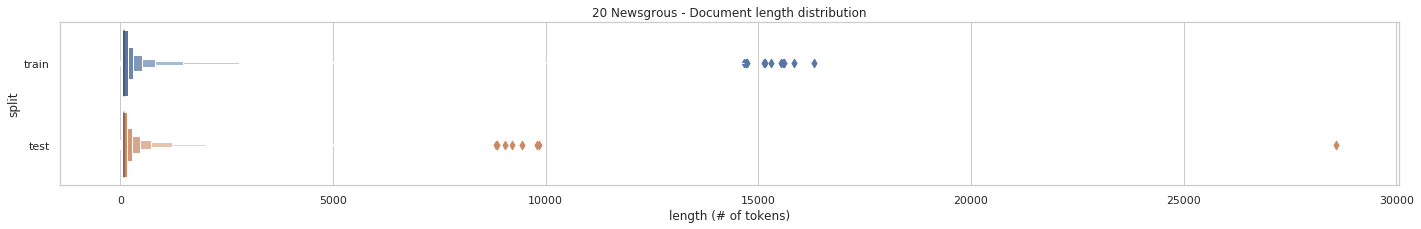

In [169]:
#%%############################################################################

#
# Plot Statistical distribution of the combined set.
# Letter-value plot per dataset split (train/test).
# https://vita.had.co.nz/papers/letter-value-plot.html
#

sns.set(style="whitegrid", rc={'figure.figsize':(24.0,3.0)})
ax6 = sns.boxenplot(x='length', y='split', data=text_lengths_ALL);

ax6.set_title("20 Newsgrous - Document length distribution")
ax6.set(xlabel='length (# of tokens)')
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

ax6.figure.savefig(os.path.join(WRK_DIR, 'chart_06.pdf'))

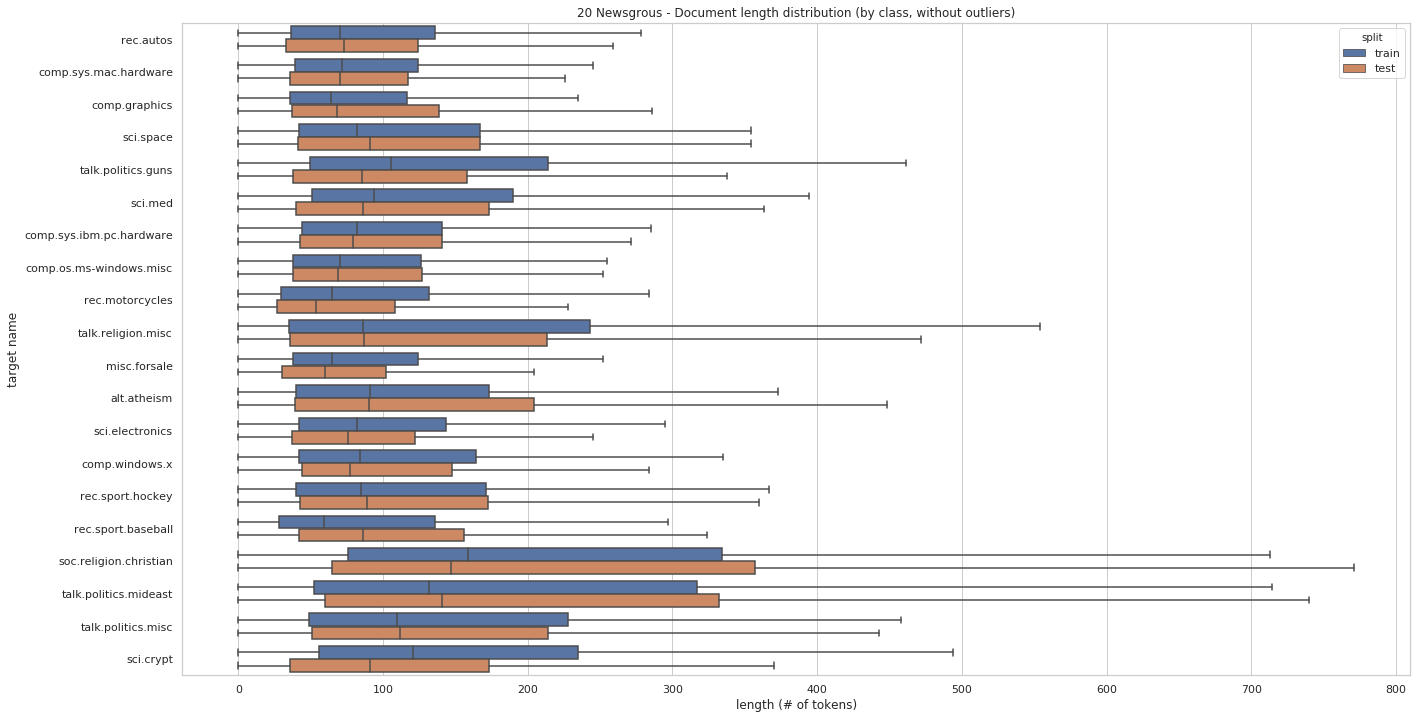

In [170]:
#%%############################################################################

#
# Plot Statistical distribution of the combined set.
# Box-plots per dataset split (train/test), per class and without outliers.
#

sns.set(style="whitegrid", rc={'figure.figsize':(22.0,12.0)})
ax7 = sns.boxplot(x="length", y="target name", hue='split', data=text_lengths_ALL, showfliers= False)
ax7.set_title("20 Newsgrous - Document length distribution (by class, without outliers)")
ax7.set(xlabel='length (# of tokens)')
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

ax7.figure.savefig(os.path.join(WRK_DIR, 'chart_07.pdf'))

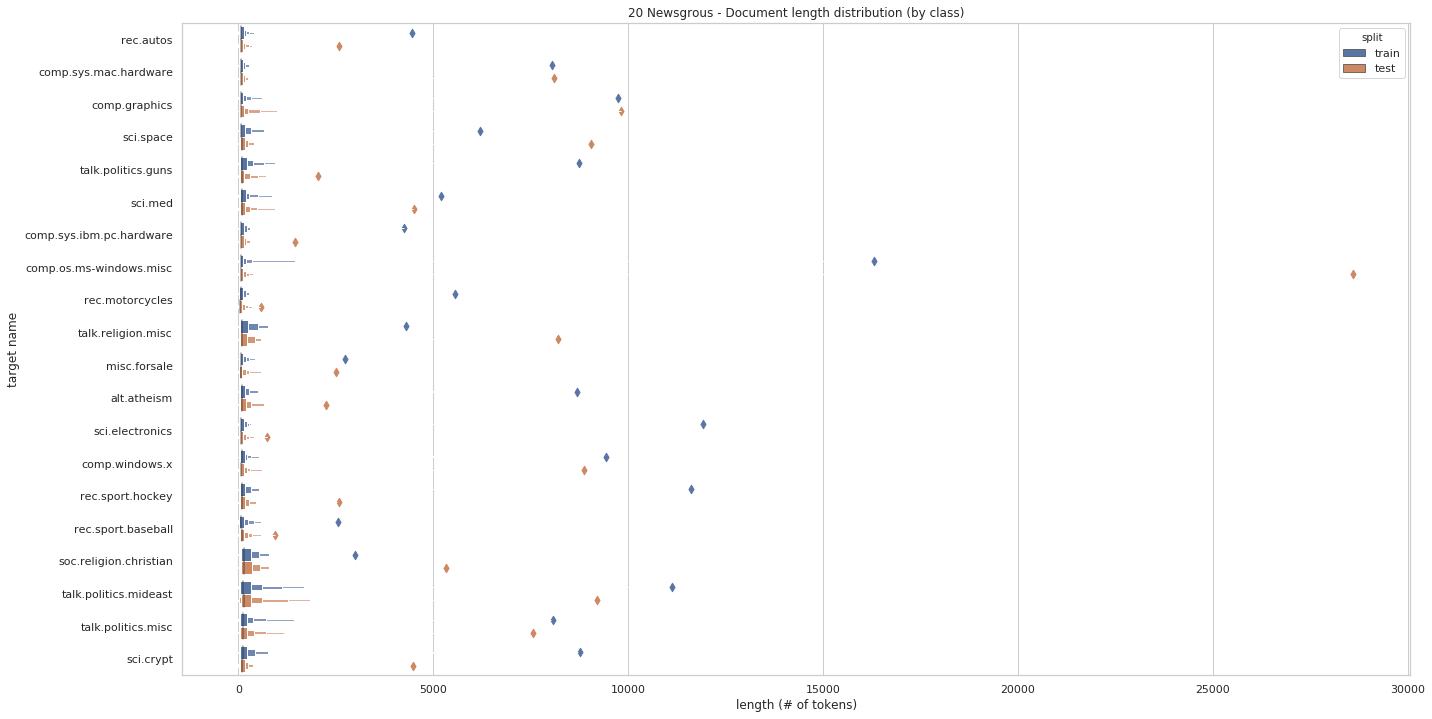

In [171]:
#%%############################################################################

#
# Plot Statistical distribution of the combined set.
# Letter-value plot per dataset split (train/test) and per class.
# https://vita.had.co.nz/papers/letter-value-plot.html
#

sns.set(style="whitegrid", rc={'figure.figsize':(22.0,12.0)})
ax8 = sns.boxenplot(x="length", y="target name", hue='split', data=text_lengths_ALL)
ax8.set_title("20 Newsgrous - Document length distribution (by class)")
ax8.set(xlabel='length (# of tokens)')
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

ax8.figure.savefig(os.path.join(WRK_DIR, 'chart_08.pdf'))

### Outliers

We try to find out how the outliers in the letter-value plot above looks like. We consider lenghts above 10,000 tokens.

In [172]:
#%%############################################################################

#
# Documents of length over 10000 are outliers
#


outliers_indexes = [ idx for idx, doc in enumerate(text_sequences_train) if len(doc) > 10000 ]
print(f'Indexes of {len(outliers_indexes)} outliers in the training dataset: {outliers_indexes}')


Indexes of 20 outliers in the training dataset: [144, 498, 1292, 1492, 1506, 1541, 3198, 4090, 4495, 4515, 4772, 5045, 6437, 8213, 8665, 9080, 9192, 9635, 10275, 10650]


In [173]:
#%%############################################################################

#
# Take a look at the outliers content
#

def show_outlier(idx):
  
    print(f'=== Training dataset - Document {idx} ======================================')
    print()
    print(texts_train[idx][:200])
    print()
    print('[...]')
    print()
    print(texts_train[idx][-100:])
    print()
    
[show_outlier(idx) for idx in outliers_indexes]

=== Training dataset - Document 144 ======================================

MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>',3'$9F8+"Z5'1]_?W]_?WWIZ>BHJ*BHJ*BHJ*BHJ*GIZ
M>GIZ>GIZ*BHJ*GIZ>M_?1T>EI0L+"V9F9F9FR,A_?W_(5Z(46Q04%%=75VO4
MU-34U-34U`("`

[...]


M@*JJJJK&:&BQL;'&[/&L9-KTE%'U4<R4!@:4-U%1-P:,F)B8F)@D"I\7GR0D
-------- End of part 9 of 14 --------

=== Training dataset - Document 498 ======================================

---------- cut here ---------- part 01/01
begin 644 1260wn31.exe
M35KO 1D    & -$,__\@ P $     ?#_'@     !0V]P>7)I9VAT(#$Y.#DM
M,3DY,"!02U=!4D4@26YC+B!!;&P@4FEG:'1S(%)E<V5R=F5D+@T*        
M        _"

[...]

_\?LG[Q
ML5(#GJ&5F&Z75PNQ :,,W@KL_EQ0JVUY-OH3A4B?\*?M41@CX2CM<F'QGD.Q
---------- cut here ----------

=== Training dataset - Document 1292 ======================================

Accounts of Anti-Armenian Human Right Violations in Azerbaijan #008 Part B
                 Prelude to Current Events in Nagorno-Karabakh

				(Part 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

We find 20 outliers in the training dataset, all of them longer than 10,000 tokens. Three of them seem to be transcriptions of long documents while the other 17, multi-part multimedia embedded messages. As the proportion of these kind of documents is very small, we prefer to *preserve the integrity of the dataset and not perform any kind of document removal*.

### Dataset summary

The dataset is used as a well-known example of **multi-class text classification**, with a fairly high number of classes (20). Classes are pretty balanced and document lengths vary a lot, from empty documents to 28592 tokens, aprox. **mean of 198 tokens**, and a **large standard deviation of 707 tokens**. Along the project we will consider a **maximum length to truncate the documents** so that they retain enough information for the classification purpose but they do not overload the expensive computation that requires to train the CNN. Just as a hint only 2.4% of the documents of the training dataset are longer than 1000 tokens.

In [174]:
#%%############################################################################

#
# Calculate percentile for the document length (tokens) we will truncate
# (i.e., what % of documents will be truncated)
#

percentile_of_max_length = stats.percentileofscore(text_lengths_train['length'], MAX_TEXT_LENGTH)

print(f'Documents will be truncated to {MAX_TEXT_LENGTH} tokens.')
print(f'Only {100-percentile_of_max_length:.1f}% of the documents are longer than {MAX_TEXT_LENGTH} tokens and will be truncated.')


Documents will be truncated to 1000 tokens.
Only 2.4% of the documents are longer than 1000 tokens and will be truncated.


## Solution statement, benchmark models and evaluation metrics

We will apply a variation of the convolutional-single-layered type of CNN proposed in [Kim2014] and [Zhang and Wallace2016]. We will label this as "Model A", which is made up of the following layers, in order: embeddings, convolutional layer (of single filter size), max pool layer, and finally a densely connected layer of 20 nodes. We will train this model and search for best hyper-parameters. Then we will evaluate how good this model is for the classification task on the 20 newsgroups dataset. Then, in order to explore and try to assess how much information relevant to the classification task is extracted from the positional information of the text sequences, we will build and train two more models, based on modifying the original one:

- "Model B". It has the same components and layers of "Model A", but the filters' size of the convolutional layer is set to 1. This way, the convolutional scan won't be able to extract sequential patterns from the text.
- "Model C". We remove the convolutional and max-pool layer from "Model A" and substitute them for a layer that calculates the average vector of the vector sequence that represents a document. This way we also eliminate any mechanism that could extract information from the word position in the sequence.

Finally, as a benchmark model, we will build "Model D", which will tackle the task of classifying the dataset by using TFIDF (Term Frequency Inverse Document Frequency) representation of the documents and a Multinomial Naïve Bayes classifier.

The following table and diagram summarise the models described above with their respective layers.

|Model|          |	        |			    |        |     |
|---  |---       |---       |---         |---     |---  |
|A    |Tokenizer |Embeddings|CNN Layer   |Max Pool|Dense|
|B    |Tokenizer |Embeddings|CNN Layer(1)|Max Pool|Dense|
|C    |Tokenizer |Embeddings|Average     |Dense   |     |
|D    |Tokenizer |TFIDF     |Naïve Bayes |        |     |

![Models](https://github.com/aluarosi/udacity-mlnd/blob/master/capstone_project/images/models01.png?raw=true)


We will assess the performance of all the models by calculating and comparing **accuracies**.

$$ Accuracy = {TP + TN \over N} $$

Where TP is the number of true positives in the confusion matrix, TN the number of true negatives, and N the total number of samples in the test split of the dataset.

In order to quantify how much relevant information can we additionally extract between models, we will resort to calculate the **information gain**. This magnitude, expressed in bits, will tell us how much more relevant information can a (better) model extract in comparison to another one. Following the design of the models as explained above, we know that the only model that can extract positional information from text sequences is "Model A", while both "Model B" and "Model C" can't. Thus, we will be able to estimate how good is "Model A" in extracting such additional positional information.

In order to calculate the information gain between two models, we need to calculate first the **entropy** of the confusion matrices that result from applying the trained classifiers to the test dataset. The expression of the entropy (H) for a set of samples that are classified with the same label is:

$$ H(X|y \in Y) = - \sum_{x \in X} p(x|y) \log_2 p(x|y) $$

Where $ X = \{ x_1, x_2, ..., x_N\} $ is the set of labels (i.e., how the documents are labeled after classification) and Y the set of real classes the documents belong to. And $ p(x|y) $ is the conditional probability that a document assigned to class *y* after classification belongs to class *x*.

The resulting entropy for the complete dataset after classification is the weighted average of the entropies for each label:

$$ H(X) = \sum_{y \in Y} p(y) \space H(X|y) $$

Finally, the **information gain** is calculated by subtracting the entropies of the resulting classification for two different models.

$$ IG(A,B) = H_B(X) - H_A(X) $$

Where $ IG(A,B) $ is the information gain that model A gives over model B.

See [Provost and Fawcett2013], chap. 3, where this definition of information gain is presented.

Alternatively, we can calculate the **mutual information** between predicted labels and real classes. (See [Mutual Information, Wikipedia](https://en.wikipedia.org/wiki/Mutual_information)):

$$ I(X;Y) = \sum_{x \in X} \sum_{y \in Y} p(x,y) \log_2 \Big( {p(x,y) \over  p(x)p(y)} \Big) $$

## Project Design

### Tools and libraries

We will use Python 3 and two main libraries:

* [Keras](https://keras.io/), to train the neural network models and also for pre-processing (e.g., tokenizer).
* [Scikit-Learn](https://scikit-learn.org/stable/), mainly to load the "20 newsgroups" dataset and for the baseline model (Naïve Bayes) plus possibly some of its utilities.

Due to the high demand of processing resources associated to training deep neural networks, we will write and execute our code in [Google Colab](https://colab.research.google.com), using a notebook connected a GPU-enabled python kernel.

### Description of the models

As mentioned, we will evaluate 4 different models.

#### Model A
![Model A](https://github.com/aluarosi/udacity-mlnd/blob/master/capstone_project/images/models02.png?raw=true)

The first layer of **Model A** is a tokenizer, which converts each text document into sequences of integers, where each number represents a word in a dictionary that contains all the words that are present in the corpus of documents. The next layer, embeddings, converts each number in a sequence into a dense vector of 100 dimensions. The output is then a sequence matrix, which has as many rows as tokens in the document, and as many columns as dimensions in the embedded representation. Then a convolutional layer of dimension 1 is applied to the sequence matrix. The size of the filters will be the main hyper-parameter to explore, from 2 to 10, trying to detect which size is able to achieve a better classification. We will also explore the best number of filters to use in this convolutional layer. The outcome of this stage is a set of feature maps, one per filter, each one being a sequence of values with same length as the original text sequences. After that, a global max. pooling layer reduces each feature map to a single value. These values are concatenated into a sequence of values of the same length as the number of filters used in the convolutional layer. Finally, a dense neural net layer of 20 nodes and with softmax activation function is applied to get the final array of 20 values which represent the probabilities of each one of the 20 categories of our classification task. 

In general, we will try to follow the guidelines for this type of CNN architecture from [Zhang and Wallace2016], as well as the starting values of hyper-parameters they recommend:

|Description        |Values          |
|---                |---             |
|input word vectors |Google word2vec |
|filter region size |(3,4,5)         |
|feature maps       |100             |
|activation function|ReLU            |
|pooling            |1-max pooling   |
|dropout rate       |0.5             |
|l2 norm constrained|3               |

However, we will slightly change the following:

* Instead of word2vec embeddings, we will use Glove.
* In [Zhang and Wallace2016] they propose 3 parallel channels in the convolutional layer, with 3 different consecutive filter sizes. We will simplify that architecture by using a single convolutional channel with a unique CNN filter size, and to compensate, we will multiply by 3 the number of feature maps as starting point when tuning hyper-parameters.

#### Model B

**Model B** is the result of modifying Model A by setting the convolutional filters' size to 1.

#### Model C

![Model C](https://github.com/aluarosi/udacity-mlnd/blob/master/capstone_project/images/models03.png?raw=true)

**Model C** is the result of modifying Model A by removing the convolutional layer and substituting the global max. pooling layer by a global average layer.

#### Model D

![Model D](https://github.com/aluarosi/udacity-mlnd/blob/master/capstone_project/images/models04.png?raw=true)

**Model D** is the baseline benchmark model, which is based on a Naïve Bayes classifier applied on a TFIDF (Term Frequency - Inverse Document Frequency) representation of each document. 

### Data Preparation

The dataset (20 newsgroups) will be loaded by using the utility function `fetch_20newsgroups` provided by the scikit-learn library, both for the training and test splits of the dataset. As described above when analysing the dataset, we will remove headers, footers and quotes by specifying the value `remove` of the `fetch_20newsgroups` function:

```
dataset_train = fetch_20newsgroups(subset='train',
                                    random_state=42,
                                    remove=('headers', 'footers', 'quotes'))
```
The next step will be tokenising the texts. For that we will use the `Tokenizer` class in the Keras library. In the tokenising process we will consider only the 10000 more common words in the dataset. Then, we will build several matrices that will work as input and target outputs for our models:

* `X_tfidf_train`. Each row in this matrix represents a document in the training dataset split, encoded with the TFIDF method. Each column represents a word in the set of 10000 more common words in the dataset.
* `X_tfidf_test`. Same as above but for the test dataset.
* `X_seqs_train`. Each row represents a document in the training dataset split, encoded as a sequence of integers (each value corresponds to a word in the set of more common 10000 words). In order to have constant length rows, these sequences are padded with zeros on the left, and truncated to the maximum length of 1000 words.
* `X_tfidf_test`. Same as above but for the test dataset.
* `Y_train`. Matrix that represents the labels (classes) for each document in the training dataset.
* `Y_test`. Same as above bot fur the test dataset.
* `Y_1hot_train`, `Y_1hot_test`. 1 hot encoding representation of both label matrices above, needed for calculating categorical cross-entropy in the neural network models.

### Word embeddings layer

We will download the Glove pre-trained word vectors ([Pennington et al.2014]) from [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) web page: Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download). 
We will take the representation of the vectors that use 100 dimensions and build an embedding matrix that we will be able to pre-load in our neural network models.

### Training Model A

The next step will be to start training Model A as described above. For achieving that we will carry out a grid search in several steps. 

1. First, we will try to find the best hyper-parameter values for batch size and type of optimiser, leaving the rest of hyper-parameters fixed to the values suggested as starting point in [Zhang and Wallace2016]. 
2. Then, we will fix the best values we found for batch size and optimiser type and will explore the effect of preloading the embedding layer with the GloVe word vectors, and if the weights of the embedding layer are to be optimised during training or left as they have been pre-loaded. 
3. After that, we will explore both the convolutional filter size and the number of filters in the convolutional layer. Our plan is to scan values from 2 to 10 as convolutional filter size, and try number of filters in {50, 100, 300, 600, 900}

After this process we should have a final selection of hyper-parameters for our classification task. We will train our model one final time with these to get and save the best weights for Model A. We will then evaluate the model by calculating the accuracy of Model A on the test set.

### Training Model B

We will build Model B by re-using all the hyper-parameters from Model A, except for the convolutional filter size, which will be fixed to 1. As commented, we want to force the new model not to be able to extract positional information from the text sequences. Again, we will train it and get and save the best weights for Model B and evaluate it by calculating the accuracy on the test set.

### Training Model C

In a similar way, we will create a new instance of a neural network, but this time we modify Model A by removing the convolutional layer and will substitute the global max pooling layer with a global average pooling layer. Again, we will re-use the best hyper-parameters we found for Model A. We will train Model C to get and save its best weights, and then we will evaluate it by calculating its accuracy on the test set.

### Training Model D

Finally, we will train the benchmark model, a Naïve Bayes classifier applied on the TFIDF representation of the documents. We will evaluate it by calculating the accuracy on the test set.

### Evaluation of models and information gain

Once we've trained all the models (A, B, C, D) we will evaluate and compare their scores. As mentioned, we should have already calculated accuracies on the test set for all of them.

Then, we will calculate and represent the confusion matrix on the test set for each of them. From the confusion matrices, and as explained before, we can calculate the entropy of each of them. Calculating differences between entropies we can obtain the information gain we obtain between models for the classification task we have at hand.

### Analysis

Based on the accuracies and especially on the information gain, we will want to assess how good the model it to extract positional information from the text sequences, information which is in turn useful for the very specific classification task we are analysing. We will also try to get some insights about the impact of different components into the overall performance of the model. And more generally, we will try to reflect on what's the influence of the dataset (e.g., if there is any and how much positional information can be extracted from the dataset for the specific classification task). Finally, we would like to get a notion of how good a CNN model is for this specific classification task and if it is worth it in comparison with simpler models as the ones we analyse along this project.


## References

[Chollet2018] François Chollet. 2018. Deep Learning with Python. _Manning_.

[Hassan2018] Abdalraouf Hassan. 2018. Deep Neural Language Model for Text Classification Based on Convolutional and Recurrent Neural Networks. _Ph.D. dissertation, Dept. of Computer Science and Engineering, Univ. of Bridgeport, Bridgeport, CT, 2018._.

[Johnson and Zhang] Rie Johnson and Tong Zhang. 2015. Effective Use of Word Order for Text Categorization with Convolutional Neural Networks. _arXiv:1412.1058_.

[Kim2014] Yoon Kim. 2014. Convolutional neural networks for sentence classification. _arXiv:1408.5882_.

[Mikolov et al.2013] Tomas Mikolov, Kai Chen, Greg Corrado and Jeffrey Dean. 2013. Efficient Estimation of Word Representations in Vector Space. _arXiv:1301.3781_.

[Pennington et al.2014] Jeffrey Pennington, Richard Socher and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. _https://nlp.stanford.edu/projects/glove/_

[Provost and Fawcett2013] Foster Provost and Tom Fawcett. 2013. Data Science for Business. _O'Reilly Media Inc_.

[Wang et al.2016] Xingyou Wang, Weijie Jiang and Zhiyong Luo. 2016. Combination of Convolutional and Recurrent Neural Network for Sentiment Analysis of Short Texts. _Proceedings of COLING 2016, the 26th International Conference on Computational Linguistics: Technical Papers_.

[Yang et al.2017] Xiao Yang, Craig Macdonald and Iadh Ounis. 2017. Using Word Embeddings in Twitter Election Classification. _arXiv:1606.07006_.

[Zhang and Wallace2016] Ye Zhang and Byron C. Wallace. 2016. A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification. _arXiv:1510.03820_.


## Web references

[20 Newsgroups](http://qwone.com/%7Ejason/20Newsgroups/) http://qwone.com/%7Ejason/20Newsgroups/

[Documentation of scikit-learn](https://scikit-learn.org/stable/documentation.html) https://scikit-learn.org/stable/documentation.html

[GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) https://nlp.stanford.edu/projects/glove/

[Google Colab](https://colab.research.google.com) https://colab.research.google.com

[Implementing a CNN for Text Classification in TensorFlow](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/) http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

[Keras](https://keras.io/) https://keras.io/

[Mutual Information, Wikipedia](https://en.wikipedia.org/wiki/Mutual_information) 

[Scikit-Learn](https://scikit-learn.org/stable/) https://scikit-learn.org/stable/

[Sentence Classification using CNN with Deep Learning Studio](https://towardsdatascience.com/sentence-classification-using-cnn-with-deep-learning-studio-fe54eb53e24) https://towardsdatascience.com/sentence-classification-using-cnn-with-deep-learning-studio-fe54eb53e24

[Understanding Convolutional Neural Networks for NLP](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/) http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

[Weapons of Micro Destruction: How Our ‘Likes’ Hijacked Democracy](https://towardsdatascience.com/weapons-of-micro-destruction-how-our-likes-hijacked-democracy-c9ab6fcd3d02) https://towardsdatascience.com/weapons-of-micro-destruction-how-our-likes-hijacked-democracy-c9ab6fcd3d02

[word2vec](https://code.google.com/archive/p/word2vec/) https://code.google.com/archive/p/word2vec/



# Data Preparation

As explained above in the section "Project Proposal", we will use the dataset as it is already imported by the Scikit-learn library, after stripping headers, footers and quotes. 

## Document tokenization

We start by splitting the text into tokens by using Keras default configuration for `Tokenizer`. 

In [0]:
#%%############################################################################

###############################################################################
#
# Preprocessing text to bag of words and text sequences
#
###############################################################################

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts_train)

def inverted_word_index(idx):
    """ Gets the word for a numeric index.
        It's the inverted index of tokenizer.word_index
    """
    words, idxs = zip(*tokenizer.word_index.items())
    inverted_word_index = dict(zip(idxs, words))
    return inverted_word_index.get(idx)

## Input and target matrices

With the tokenizer we **convert the sequence of document**s (both for training and test sets) into sequences of numeric vectors. The tokenizer provides us with different document representations:

* **Bag of words**. Each document is transformed into a sparse high-dimensional vector of integer values in which each dimension corresponds to one word indexed by the tokenizer. There are two flavours, plain bag of words and word count. These are included in the code below, but they won't be used in this project.
* **TFIDF**. Term-frequency-inverse-document-frequency. Each document is converted into a sparse high-dimensional vector of real values that tries to represent both the relevance of each word in a document and at the same time its importance in the context of the corpus. See [Provost and Fawcett2013], Chapter 10: Representing and Mining Text.
* Text sequences. Each document is converted into a sequence of integers, each one representing one of the words indexed by the tokenizer. With Keras utility `pad_sequences` we transform the resulting sequence of sequences (i.e., the corpus) into a `NumPy` matrix by truncating to number of tokens `MAX_TETXT_LENGTH` and by padding with 0's to the left (those sequences that are shorter than `MAX_TEXT_LENGTH`)

As for the **target** sequences, we generate their **1-hot encoding** representation (from the categorical sequences of labels) that will be need to train and evaluate the neural network in Keras.

In [0]:
#%%############################################################################

###############################################################################
#
# Input and target matrices
#
###############################################################################

#
# Input matrices - TRAIN
#
X_bagofwords_train = tokenizer.texts_to_matrix(texts_train, mode = 'binary')
X_count_train = tokenizer.texts_to_matrix(texts_train, mode='count')
X_tfidf_train = tokenizer.texts_to_matrix(texts_train, mode='tfidf')
X_seqs_train = pad_sequences(tokenizer.texts_to_sequences(texts_train), maxlen=MAX_TEXT_LENGTH)

#
# Input matrices - TEST
#
X_bagofwords_test = tokenizer.texts_to_matrix(texts_test, mode = 'binary')
X_count_test = tokenizer.texts_to_matrix(texts_test, mode='count')
X_tfidf_test = tokenizer.texts_to_matrix(texts_test, mode='tfidf')
X_seqs_test = pad_sequences(tokenizer.texts_to_sequences(texts_test), maxlen=MAX_TEXT_LENGTH)

#
# Output matrices - TRAIN
#
Y_train = targets_train
Y_1hot_train = to_categorical(np.asarray(Y_train), N_CATEGORIES)

#
# Output matrices - TEST
#
Y_test = targets_test
Y_1hot_test = to_categorical(np.asarray(Y_test), N_CATEGORIES)

# Training

## Pre-load embeddings

We build and preload an embedding matrix with Glove embeddings of 100 dimensions. See [Chollet2018], chap. 6.

We've previously downloaded Glove pre-trained word vectors ([Pennington et al.2014]) from [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) web page: Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download). 
We take the representation of the vectors that use 100 dimensions and build an embedding matrix that we will be able to pre-load in our neural network models.

See further down how in the training process we explore if pre-loading the embedding layer of our neural network gives us some advantage in the trained model's performance in comparison with training the embedding layer from scratch (initialised with random values).

In [176]:
#%%############################################################################

###############################################################################
#
# Load Glove embeddings - 100 dimensions
#
###############################################################################

#
# Load 100-dimension embeddings from file
# https://nlp.stanford.edu/projects/glove/
# After F. Chollet's book [Chollet2018], Chapter 6
#
glove_dir = WRK_DIR

embeddings_index = {}

with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        line_as_list = line.split()
        token = line_as_list[0]
        coords = np.asarray( line_as_list[1:], dtype='float32' )
        embeddings_index[token] = coords

print( f'Found {len(embeddings_index)} vectors.' )

#
# Build embeddings matrix
# After F. Chollet's book - Chapter 6
#
GLOVE_EMBEDDING_MATRIX = np.zeros((NUM_WORDS, EMBEDDING_DIMS))

for word, idx in tokenizer.word_index.items():
    if idx < NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            GLOVE_EMBEDDING_MATRIX[idx] = embedding_vector

Found 400000 vectors.


## Training utilities

In this section we code a set of functions that will help us to train our different versions of neural network.

### Model creation

The following functions will allow us tocreate and use Keras and Sklearn models homogeneously. This is needed as the first three models (A, B, C) will be implemented by the Keras library, but model D will be by Scikit-learn library.

We will consider four model flavours that we will deliver as one of the parameters on model creation:

* Model A and Model B have flavour `CNN-DENSE`
* Model C has flavour `AVG-DENSE`
* Model D has flavour `NAIVE-BAYES`

The function `create_model` takes a set of parameters including this mentioned `model_flavour` on top of the model hyperparameters.

In [0]:
#%%############################################################################

###############################################################################
#
# Wrapper for both Keras and Sklearn model creation
#
###############################################################################

def create_keras_model(**kw):
    ''' Wrapper for Keras neural-net model creation.
        
        Input parameters: see code section below
        
        Model flavours are:
        - 'CNN-DENSE' : For models A and B, with mid CNN layer.
        - 'AVG-DENSE' : For model C, GlobalAveragePooling1D instead of CNN layer.
        - 'AVG-ONLY' : Only GlobalAveragePooling1D. Not trainable. 
                       NOT USED in this project.
                       It could be used to substitute the dense layer of model C
                       for another classifier (Bayes, SVM, etc.)
                       
        Returns:
        - A new model instance
    '''

    #
    # Input parameters (**kw, all named) are considered here:
    # 
    model_flavour = kw.get('model_flavour')
    valid_flavours = ['CNN-DENSE', 'AVG-DENSE', 'AVG-ONLY']
    assert model_flavour in valid_flavours, \
           f'model_flavour is "{model_flavour}" buyt should be one of {valid_flavours}'
    embedding_preload = bool( kw.get('embedding_preload') ) # Defaults to False
    embedding_train = bool( kw.get('embedding_train') ) # Defaults to False
    embedding_matrix = kw.get('embedding_matrix') if 'embedding_matrix' in kw \
                       else GLOVE_EMBEDDING_MATRIX
    #
    # Default values for parameters below follow the guidelines
    # for this type of CNN architecture from [Zhang and Wallace2016]
    # with slight changes as explained in the project proposal.
    #
    cnn_num_filters = kw.get('cnn_num_filters') or 300
    cnn_filter_size = kw.get('cnn_filter_size') or 4
    dropout = kw.get('dropout') or 0.5
    max_norm_constraint = kw.get('max_norm_constraint') or 3.0
    dense_num_neurons = kw.get('dense_num_neurons' or 300)
    optimizer = kw.get('optimizer') or 'rmsprop'

    print(f'''Creating model with params:
          embedding_preload={embedding_preload},
          embedding_train={embedding_train},
          cnn_num_filters={cnn_num_filters},
          cnn_filter_size={cnn_filter_size},
          dropout={dropout},
          max_norm_constraint={max_norm_constraint},
          optimizer={optimizer},
          embedding_matrix={embedding_matrix if embedding_preload else "RANDOM"}
          ''')

    #
    # Keras model creation
    # 
    model = Sequential()
    model.add( Embedding(NUM_WORDS, EMBEDDING_DIMS, input_length = MAX_TEXT_LENGTH) )

    #
    # Preload embeddings (Glove)
    # If embedding matrix is not preloaded, it's initialised to RANDOM values!
    #
    if embedding_preload:
        model.layers[0].set_weights( [embedding_matrix] )

    #
    # Do we have to train embedding layer?
    #
    model.layers[0].trainable = embedding_train

    #
    # CNN layer
    #
    if model_flavour == 'CNN-DENSE':
        model.add( Conv1D(cnn_num_filters, cnn_filter_size, activation='relu', padding='same') )
        model.add( GlobalMaxPool1D())
    elif model_flavour == 'AVG-DENSE' or model_flavour == 'AVG-ONLY':
        model.add( GlobalAveragePooling1D() )

    #
    # DENSE layer - softmax
    # Dense
    #
    if model_flavour == 'CNN-DENSE' or model_flavour == 'AVG-DENSE':
        model.add( Dropout(dropout) )
        model.add( Dense(N_CATEGORIES,
                       activation='softmax',
                       kernel_constraint=max_norm(max_norm_constraint)) )

    #
    # Compile model
    #
    model.compile(optimizer=optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['acc']
                  )
    
    #
    # Print model summary
    #
    print( model.summary() )
    
    return model
  

def create_sklearn_model(**kw):
    ''' Wrapper for scikit-learn model creation.
        
        Input parameters: see code section below
        
        Model flavours must be on of these:
        - 'NAIVE-BAYES'
        
        Returns:
        - A new model instance
    '''
    
    valid_flavours = ['NAIVE-BAYES']
    assert kw.get('model_flavour') in valid_flavours, \
           f'model_flavour is "{model_flavour}" but should be one of {valid_flavours}'
    
    #
    # Model creation
    #
    if kw['model_flavour'] == 'NAIVE-BAYES':
        alpha = kw.get('alpha') if 'alpha' in kw else 1.0
        model = MultinomialNB(alpha=alpha)
        
    #
    # Print model summary
    #
    print( model )
    
    return model
  
  
def create_model(**params):
    ''' Dispacher function, either to fit keras or sklearn model.
    
        Parameters:
        - model_flavour: 'CNN-DENSE', 'AVG-DENSE', 'AVG-ONLY', 'NAIVE-BAYES'
        - (any other model hyperparameters that the selected model flavour supports
        
        Example of params:
        
        {'batch_size': 128,
         'cnn_filter_size': 2,
         'cnn_num_filters': 900,
         'embedding_preload': True,
         'embedding_train': True,
         'epochs': 30,
         'model_flavour': 'CNN-DENSE',
         'optimizer': 'adam'}
        
        Returns:
        - A new model instance
    '''
    
    keras_flavours = ['CNN-DENSE', 'AVG-DENSE', 'AVG-ONLY']
    sklearn_flavours = ['NAIVE-BAYES']
    valid_flavours = keras_flavours + sklearn_flavours
    
    model_flavour = params.get('model_flavour')
    assert model_flavour in valid_flavours, \
           f'model_flavour is "{model_flavour}" but should be one of {valid_flavours}'
    
    if model_flavour in keras_flavours:
        return create_keras_model(**params)
    if model_flavour in sklearn_flavours:
        return create_sklearn_model(**params)

### Helper functions

Below we include some helper functions which will support us with:

* Custom **Grid Search**, which is more flexible for our purposes than Scikit-learn grid search utility. This one wraps onto models backed both by Keras and Sklearn and gives and extended report about the training process (including validation scores along epochs, training time, etc.).
* Fitting a model (Keras or Sklearn).
* Running training sessions.
* Saving and loading training reports and trained model weights.
* Visualising training and test scores along model training.

In [0]:
#%%############################################################################

###############################################################################
#
# Search grid, training sessions and reporting
#
###############################################################################

def display_params(params):
    ''' Displays hyperparameter combination as a table
    '''
    df_paramsA = pd.DataFrame([params]).transpose()
    df_paramsA.columns = ['']
    print(df_paramsA)
    print()

def make_timestamp(time=None):
    ''' Generates formated timestamp (string)
    
        Parameters: 
        - time: a datetime.datetime object
        
        Returns:
        - A timestamp like '20181212193425' (format 'YYYYMMDDhhmmss')
    '''
    
    t = time or datetime.now()
    
    # The nice f-string makes notebook choke in Google Colab!
    # timestamp = f'{n.year:04}{n.month:02}{n.day:02}{n.hour:02}{n.minute:02}{n.second:02}'
    # We rewrite it to:
    return '{:04}{:02}{:02}{:02}{:02}{:02}'.format(t.year, t.month, t.day, t.hour, t.minute, t.second)


def calculate_params_from_grid(grid):
    ''' Takes a hyperparameter grid as parameter, like this:
    
        {'embedding_preload': [True],
         'embedding_train': [True],
         'cnn_filter_size': [4],
         'cnn_num_filters': [300],
         'batch_size': [64,128,256,512],
         'epochs': [20],
         'optimizer': ['rmsprop', 'sgd','adagrad', 'adadelta', 'adam', 'adamax', 'nadam' ],
         'model_flavour': ['CNN-DENSE']
         }
         
        And returns a sequence of dictionaries, one for each unique hyperparameter combination:
        
        [{'batch_size': 64,
          'cnn_filter_size': 4,
          'cnn_num_filters': 300,
          'embedding_preload': True,
          'embedding_train': True,
          'epochs': 20,
          'model_flavour': 'CNN-DENSE',
          'optimizer': 'rmsprop'},
          ...
        ]
    '''

    keys = list(grid.keys())
    values = list(grid.values())

    def cartesian(A,B):
        ''' Returns the cartesian product of two lists as a list of pairs
        '''
        result = []
        for a in A:
            for b in B:
                # Check if not tuple nor list, then wrap them as tuples
                if type(a) != tuple and type(a) != list:
                    a = (a,)
                if type(b) != tuple and type(b) != list:
                    b = (b,)
                result.append(a+b)
        return result

    result = [dict(zip(keys,t))  for t in reduce(cartesian, values)]
    #print( f'Grid of {len(result)} hyperparameter combinations.' )
    return result


def fit_keras_model(model, params, X, Y, idx=0, session='undefined',
                    save_weights=True,
                    weights_filepath=os.path.join(WRK_DIR,'weights.hdf5')):
    ''' Wrapper for fitting a Keras model.
        It also calculates validation score and measures training time.
    
        Parameters:
        - model: a keras model instance, which is CHANGED (fitted) by this function.
        - params: a combination of model hyperparameters (dictionary)
        - X: input matrix
        - Y: target matrix
        - idx: identifier for the model instance within a training session
        - session: identifier for the training session
        - save_weights: flag for saving weights in a file
        - weights_filepath: path of the file where weights will be saved
        
        Returns:
        - A report of the training process in the form of a dictionary. See below.
    '''
    
    valid_flavours =  ['CNN-DENSE', 'AVG-DENSE', 'AVG-ONLY']
    model_flavour = params.get('model_flavour')
    assert model_flavour in valid_flavours, \
           f'model_flavour is "{model_flavour}" but should be one of {valid_flavours}'
    
    validation_split = 0.2

    print(f'Weights file: {weights_filepath}')
    print()

    #
    # Checkpointer for saving best weights
    #
    callbacks = []
    if save_weights == True:
        checkpointer = ModelCheckpoint(weights_filepath,
                                       monitor='val_acc',
                                       verbose=1, 
                                       save_best_only=True)
        callbacks.append(checkpointer)

    #
    # Fit model
    #
    time_start = datetime.now()
    history = model.fit(X,Y, epochs = params.get('epochs'),
                        batch_size = params.get('batch_size'),
                        validation_split = validation_split,
                        callbacks = callbacks,
                        verbose=0)
    time_end = datetime.now()

    val_acc_sequence = history.history['val_acc']
    best_epoch = val_acc_sequence.index(max(val_acc_sequence))
    
    print()

    result = {'__type__' : 'keras',
              'session' : session,
              'history' : history.history,
              'params' : params,
              'idx' : idx,
              'training_time' : time_end - time_start,
              'starting_time' : time_start,
              'weights_file' : weights_filepath,
              'best_epoch' : best_epoch,
              'best_score' : val_acc_sequence[best_epoch]
              }
    return result

  
def fit_sklearn_model(model, params, X, Y, idx=0, session='undefined'):
    ''' Wrapper for fitting sklearn model.
        It also calculates validation score and measures training time.

        Parameters:
        - model: a sklearn model instance which is CHANGED (fitted) by this function
        - params: a combination of model hyperparameters (dictionary)
        - X: input matrix
        - Y: target matrix
        - idx: identifier for the model instance within a training session
        - session: identifier for the training session
        
        Returns:
        - A report of the training process in the form of a dictionary. See below.
    '''

    model_flavour = params.get('model_flavour')
    assert model_flavour in ['NAIVE-BAYES'], \
           f'model_flavour is "{model_flavour}" but should be "NAIVE-BAYES"'
    
    validation_split = 0.2
    
    print()
    
    #
    # Cross-validation with ShuffleSplit
    #
    rs = ShuffleSplit(n_splits=5, test_size=validation_split)
    print(rs)
    
    #
    # Get validation score (accuracy)
    # This leaves original model unfitted (untouched) yet.
    #
    scores = cross_val_score(model, X, Y, cv=rs)
    best_score = scores.mean()
    print(f'Cross-validation scores {scores}. Mean score: {best_score}')
    
    #
    # Fit model with the whole dataset
    #
    time_start = datetime.now()
    model.fit(X,Y)
    time_end = datetime.now()

    result = {'__type__' : 'sklearn',
              'session' : session,
              'params' : params,
              'idx' : idx,
              'training_time' : time_end - time_start,
              'starting_time' : time_start,
              'best_score' : best_score
              }
    return result
        

def fit_model(model, params, X, Y, idx, session_id, repetition, repetitions, **kw):
    ''' Dispacher function, either to fit keras or sklearn model.
        It also calculates validation score and measures training time.
        
        Parameters:
        - model: a keras or sklearn model instance, which is CHANGED (fitted) by this function.
        - params: a combination of model hyperparameters (dictionary)
        - X: input matrix
        - Y: target matrix
        - idx: identifier for the model instance within a training session
        - session: identifier for the training session
        - repetition: order of current repetition in the total number of repetitions
        - repetitions: total times this model will be trained
        - save_weights: flag for saving weights in a file
        - weights_filepath: path of the file where weights will be saved
        
        Returns:
        - A report of the training process in the form of a dictionary. See below.
    '''
    
    keras_flavours = ['CNN-DENSE', 'AVG-DENSE', 'AVG-ONLY']
    sklearn_flavours = ['NAIVE-BAYES']
    valid_flavours = keras_flavours + sklearn_flavours
    
    model_flavour = params.get('model_flavour')
    assert model_flavour in valid_flavours, \
           f'model_flavour is "{model_flavour}" but should be one of {valid_flavours}'
    
    print( "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~" )
    print( datetime.now() )
    print( "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~" )

    # TODO:
    # All these informative parameters probably should be out of this function!!!
    # It seems it was easier to put this here as in the calling function
    # run_training_session() a list comprehension is used (that could be changed).
    # Cleaning left for another iteration... :/
    print(f'Fitting model {idx}, repetition {repetition} of {repetitions}, with params:')
    print(params)
    
    if model_flavour in keras_flavours:
        return fit_keras_model(model, params, X, Y, 
                               idx = idx, session = session_id,
                               weights_filepath = kw.get('weights_filepath'))
    if model_flavour in sklearn_flavours:
        return fit_sklearn_model(model, params, X, Y,
                                 idx  = idx, session = session_id)
        

def run_training_session(params, X, Y, session_id = None, repetitions=1,
                         weights_filepath=os.path.join(WRK_DIR,'weights.hdf5')):
    ''' Runs a series of training attempts
    
        Parameters:
        - params: a list of unique combinations of hyperparameters (list of dict)
        - X: input matrix
        - Y: target matrix
        - session_id: identifier for the training session
        - repetitions: number of times the same hyperparameter combination is trained
        - weights_filepath: path for the file that will store best model weights
    
        Returns: 
        - A sequence of training reports.
    '''

    # Repeat each hyperparameter combination as many times as set in 'repetitions'
    print()
    print(f'STARTING TRAINING SESSION with {repetitions} repetitions per hyperparameter combination.')
    params_ = sum( [[p] * repetitions for p in params]   ,[])
    print(f'The session will run {len(params_)} trials.')
    print()
    
    session_id = session_id or make_timestamp()

    # Iterate lazily to avoid cluttering memmory!!!
    models = (create_model(**p) for p in params_)

    reports = [fit_model(m, p, X, Y, 
                         int(idx/repetitions)+1, session_id,
                         (idx%repetitions)+1, repetitions,
                         weights_filepath=weights_filepath) \
               for (p, m, idx) in zip(params_, models, range(len(params_)))]

    return reports
  
  
def create_and_train_model(params, X, Y,
                           weights_filepath=os.path.join(WRK_DIR,'weights.hdf5')):
    ''' Creates and trains a model
    
        Parameters:
        - params: unique combination of hyperparameters (dict)
        - X: input matrix
        - Y: target matrix
        - weights_filepath: path for the file that will store best model weights
    
        Returns: 
        - training report
        - trained model
    '''
    print()
    print(f'Creating and training model with hyperparameters:')
    print(params)
    print()
    
    model = create_model(**params)

    report = fit_model(model, params, 
                       X, Y, 
                       1, None, 1, 1, # A smell here... repetitions params should not be here...
                       weights_filepath=weights_filepath)

    return (report, model)
  
  
def run_training_session_from_grid(grid, X, Y, session_id=None, repetitions=1):
    ''' From a grid, starts and run a training session
    
        Parameters:
        - grid: e.g.:
            {'embedding_preload': [True],
             'embedding_train': [True],
             'cnn_filter_size': [4],
             'cnn_num_filters': [300],
             'batch_size': [64,128,256,512],
             'epochs': [20],
             'optimizer': ['rmsprop', 'sgd','adagrad', 'adadelta', 'adam', 'adamax', 'nadam' ],
             'model_flavour': ['CNN-DENSE']
             }      
        - session_id: session identifier
        - repetitions: number of times the same hyperparameter combination is trained
        - X: input matrix
        - Y: target matrix
        
        Returns:
        - A sequence of training reports
    '''

    params = calculate_params_from_grid(grid)
    return run_training_session(params, X, Y, session_id=session_id, repetitions=repetitions)

  
###############################################################################
#
# Save and retrieve reports and model
#
###############################################################################

def save_reports(reports, filepath):
    with open(filepath,'wb') as f:
        pickle.dump(reports, f)

def load_reports(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)
      
def save_report(report, filepath):
    save_reports([report], filepath)

def load_report(filepath):
    return load_reports(filepath)[0]
    
def save_model(model, filepath='/tmp/model.json'):
    ''' Saves model description (.json)
    '''
    with open(filepath, 'w') as f:
        f.write(model.to_json())
    return filepath

def load_model(filepath='/tmp/model.json'):
    '''Loads model from json in file
    '''
    with open(filepath, 'r') as f:
        return model_from_json(f.read())


###############################################################################
#
# Sort models by validation score
#
###############################################################################

def sort_models_by_score(reports):
    ''' Takes a list of training reports and returns a new sorted list of reports
        by "best_score", which is validation accuracy.
        
        Parameters:
        - reports: list of training reports
        
        Returns:
        - A list of sorted training reports.
    '''

    sorted_reports = sorted(reports, reverse= True, 
                            key = lambda x: x['best_score'])
    
    return sorted_reports

###############################################################################
#
# Builds a dataframe from a list of reports obtained after a training session
#
###############################################################################

def build_dataframe_from_reports(reports, only_best_epoch=True):
    ''' Takes a list of training reports and creates a report dataframe
      
        Parameters:
        - reports: list of training reports
        - only_best_epoch: returns either only the best epoch or all the epochs
        
        Returns:
        - a dataframe with report information
    '''
    
    def zip_history(report):
        history = report.get('history')
        if history:
            return zip(report['history']['acc'],
                       report['history']['val_acc'])
        else:
            return [(None, None)]
    
    l = [{'Training trial': i,
          'Hyperparameter combination': r['idx'],
          'Epoch': epoch,
          'Best epoch': r.get('best_epoch'),
          'Best validation accuracy': r['best_score'], 
          'Training accuracy': acc,
          'Validation accuracy': val_acc,
          'Starting time': r['starting_time'],
          'Training time': r['training_time'],
          'Batch size': r['params'].get('batch_size'),
          'CNN filter size': r['params'].get('cnn_filter_size'),
          'Number of filters': r['params'].get('cnn_num_filters'),
          'Embedding preload': r['params'].get('embedding_preload'),
          'Embedding train': r['params'].get('embedding_train'),
          'Epochs': r['params'].get('epochs'),
          'Model flavour': r['params']['model_flavour'],
          'Optimizer': r['params'].get('optimizer'),
          'Alpha' : r['params'].get('alpha')
         } 
         for i, r in enumerate(reports) 
         #for epoch, (acc, val_acc) in enumerate( zip(r['history']['acc'], r['history']['val_acc']) )]
         for epoch, (acc, val_acc) in enumerate( zip_history(r) )]

    
    df = pd.DataFrame(l)
    
    if only_best_epoch == True and reports[0].get('history'):
        df = df[ df['Best epoch'] == df['Epoch'] ]
    
    return df

###############################################################################
#
# Plot
#
###############################################################################

def plot_epochs(df, model_case, **kw):
    ''' Plots training and validation accuracy along epochs
    '''
    
    melted_df = df.melt(id_vars=['Epoch'], 
                        value_vars=['Training accuracy', 'Validation accuracy'], 
                        var_name='Training/Validation',
                        value_name='Accuracy' )
    
    g = sns.relplot(data=melted_df, 
                    x = 'Epoch',
                    y = 'Accuracy',
                    hue = 'Training/Validation',
                    kind = 'line',
                    height = 10)
    
    g.fig.suptitle(f'Model {model_case} - Training & validation accuracy vs. epoch')
    
    return g

        
def plot_hyperparameter_exploration(df, hparam1, hparam2, model_case, 
                                    score='Best validation accuracy', 
                                    ci=95,
                                    title_offset=.9,
                                    **kw):
    ''' Plots result of hyperparameter exploration (2 hyperparameters).
      
        Draws a categorical "point" plot with confidence intervals.
        
        Parameters:
        - df: dataframe with training reports
        - hparam1: name of 1st hyperparameter
        - hparam2: name of 2nd hyperparameters
        - model_case: 'A', 'B', 'C', 'D', depending the model case we are training
        - score: value to plot on y axis, 'Best validation accuracy' by default
        - ci: confidence level (95% by default)
        
        Returns:
        - A Seaborn chart
    '''
    sns.set(style="whitegrid")
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
    g = sns.catplot(x=hparam1, 
                    y=score, 
                    hue=hparam2, 
                    kind='point', 
                    data=df,
                    ci=ci,
                    height=10, 
                    capsize=.1, 
                    join=True, 
                    markers=['o', '^', 's', 'd'], 
                    errwidth=1.8, 
                    dodge=kw.get('dodge', .3),
                    linestyles= [':', ':', ':', ':']
                   )
    g.fig.suptitle(f'Model {model_case} - Hyperparameter exploration - {hparam1} & {hparam2 or ""} - Confidence: {ci}%')
    
    return g
  
  
def plot_hyperparameter_exploration_with_epochs(df, hparam1, hparam2,
                                                epoch_column='Epoch',
                                                model_case='A', 
                                                score='Validation accuracy', 
                                                ci=95,
                                                title_offset=.9,
                                                **kw):
    ''' Plots result of hyperparameter exploration (2 hyperparameters).
      
        Draws a Seaborn relational plot with confidence intervals.
        and faaceted layout.
        
        Parameters:
        - df: dataframe with training reports
        - hparam1: name of 1st hyperparameter
        - hparam2: name of 2nd hyperparameters
        - epoch column: name of the column that encodes the epoch
        - model_case: 'A', 'B', 'C', 'D', depending the model case we are training
        - score: value to plot on y axis, 'Best validation accuracy' by default
        - ci: confidence level (95% by default)
        
        Returns:
        - A Seaborn chart
    '''
    
    sns.set(style="whitegrid")
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
    
    g = sns.relplot(data=df,
                    x=epoch_column,
                    y=score,
                    hue=hparam1,
                    col=hparam2,
                    col_wrap= kw.get('col_wrap', 3),
                    height=kw.get('height', 6),
                    kind='line',
                    estimator=kw.get('estimator', np.mean),
                    units=kw.get('units')
                    )

    plt.subplots_adjust(top=title_offset)
    g.fig.suptitle(f'Model {model_case} - Hyperparameter exploration - {hparam1} & {hparam2} - Confidence: {ci}%')
    
    return g

## Training Model A

In this section we start by training Model A. Recall its layers:

|Model|          |	        |			 |        |     |
|---  |---       |---       |---         |---     |---  |
|**A**|**Tokenizer**|**Embeddings**|**CNN Layer**|**Max Pool**|**Dense**|
|B    |Tokenizer |Embeddings|CNN Layer(1)|Max Pool|Dense|
|C    |Tokenizer |Embeddings|Average     |Dense   |     |
|D    |Tokenizer |TFIDF     |Naïve Bayes |        |     |

Our starting point will be the default hyperparameters recommended for the CNN architecture in [Zhang and Wallace2016] with a couple of changes mentioned before (GloVe embeddings instead of word2vec, and one channel of 300 feature maps instead 3 of 100).

|Description        |Values          |
|---                |---             |
|input word vectors |Google word2vec |
|filter region size |(3,4,5)         |
|feature maps       |100             |
|activation function|ReLU            |
|pooling            |1-max pooling   |
|dropout rate       |0.5             |
|l2 norm constrained|3               |



### Exploration of optimizer and batch size

We start by exploring hyperparameters:
- optimizer
- batch_size

while leaving the other (hyperparameters) fixed to the default values. We will explore the rest of hyperparameters in subsequent steps.

In [179]:
#%%############################################################################

###############################################################################
#
# Preliminar grid search for finding best non-relevant hyperparameters
# This is grid is for exploring optimizer params.
#
###############################################################################

grid0 = {'embedding_preload': [True],
         'embedding_train': [True],
         'cnn_filter_size': [4],
         'cnn_num_filters': [300],
         'batch_size': [64,128,256,512],
         'epochs': [20],
         'optimizer': ['rmsprop', 'sgd','adagrad', 'adadelta', 'adam', 'adamax', 'nadam' ],
         'model_flavour': ['CNN-DENSE']
         }
grid0

{'batch_size': [64, 128, 256, 512],
 'cnn_filter_size': [4],
 'cnn_num_filters': [300],
 'embedding_preload': [True],
 'embedding_train': [True],
 'epochs': [20],
 'model_flavour': ['CNN-DENSE'],
 'optimizer': ['rmsprop',
  'sgd',
  'adagrad',
  'adadelta',
  'adam',
  'adamax',
  'nadam']}

The following cell runs the training session and saves the training reports to a timestamped file. 

WARNING: It can take quite a long time, even running with support of a GPU.  **Skip it if you just want to retrieve the result from a previous report file**.

In [0]:
#%%############################################################################

###############################################################################
#
# Run hyperparameter exploration 0 for Model A
#
###############################################################################

reports0 = run_training_session_from_grid(grid0, X_seqs_train, Y_1hot_train)

###############################################################################
#
# Save training reports in timestamped file
#
###############################################################################
t = reports0[0]['starting_time']
timestamp = make_timestamp(t)
save_reports(reports0, os.path.join(WRK_DIR, f'reports0_{timestamp}.pickle'))

Then we recover the training reports from a file.

**Adjust manually if you want to recover the report file just created by the cell above or if you want to retrieve an older report file**.

In [180]:
#%%############################################################################

###############################################################################
#
# Retrieve report file and sort training attempts by score (validation accuracy)
#
###############################################################################

# PICK ONE OPTION
# EITHER the report file just created by cell above:
# reports0 = load_reports(os.path.join(WRK_DIR, f'reports0_{timestamp}.pickle'))
# OR an older report file:
reports0 = load_reports(os.path.join(WRK_DIR, f'reports0_20181201183104.pickle'))

# Sort reports by validation accuracy
sorted_reports0 = sort_models_by_score(reports0)

# Select only report's relevant fields and display
sorted_reports0_ = [ dict([(k,v) for (k,v) in r.items() if k != 'history']) for r in sorted_reports0]
sorted_reports0_simple = [(r['params']['optimizer'], r['params']['batch_size'], r['best_score'], r['best_epoch'])for r in sorted_reports0_]
pd.DataFrame(sorted_reports0_simple, columns=['Optimizer', 'Batch size', 'Best val acc', 'Best epoch'])

,Optimizer,Batch size,Best val acc,Best epoch
0,adam,128,0.714538,19
1,nadam,256,0.708794,19
2,rmsprop,128,0.707910,19
3,nadam,128,0.706584,8
4,nadam,64,0.706584,13
5,rmsprop,64,0.705259,15
6,adam,64,0.704375,16
7,nadam,512,0.703049,18
8,rmsprop,256,0.698630,17
9,adam,256,0.698188,19


In [181]:
#%%############################################################################

###############################################################################
#
# Best hyperparameters for exploration 0 (grid0)
#
###############################################################################

best_params0 = sorted_reports0[0]['params']
best_params0

{'batch_size': 128,
 'cnn_filter_size': 4,
 'cnn_num_filters': 300,
 'embedding_preload': True,
 'embedding_train': True,
 'epochs': 20,
 'model_flavour': 'CNN-DENSE',
 'optimizer': 'adam'}

As we can see, the best validation scores have been for **batch size of 128** and the optimizer of type **"adam"**. We will fix these hyperparameters to these values for the rest of our research.

Although we note that the best validation score for the best combinations of hyperparameters are obtained in the last epoch (19, range from 0 to 19), we assume that 20 epochs are enough to make a sensible decision about what is likely to be one of the best hyperparameter combinations. In the final training session for this model we will take care of increasing the number of epochs so that the best validation scores are not likely to turn out in the last epoch (which suggests that better validation scores could still be obtained).

#### Exploration of optimizer and batch size with variance

As training neural nets has stochastic components, we need to take variance into consideration. From now on we will repeat the training sessions several times and work with confidence intervals. 
From the tentative step before we'll reduce our optimizer search to the most promising ones. See below.

In [182]:
#%%############################################################################

###############################################################################
#
# Preliminar grid search for finding best non-relevant hyperparameters
# This is grid is for exploring optimizer params with repetitions.
#
###############################################################################

grid0_with_repetitions = {'embedding_preload': [True],
                          'embedding_train': [True],
                          'cnn_filter_size': [4],
                          'cnn_num_filters': [300],
                          'batch_size': [64,128,256,512],
                          'epochs': [20],
                          'optimizer': ['rmsprop', 'adagrad', 'adam', 'nadam' ],
                          'model_flavour': ['CNN-DENSE']
                         }
grid0_with_repetitions

{'batch_size': [64, 128, 256, 512],
 'cnn_filter_size': [4],
 'cnn_num_filters': [300],
 'embedding_preload': [True],
 'embedding_train': [True],
 'epochs': [20],
 'model_flavour': ['CNN-DENSE'],
 'optimizer': ['rmsprop', 'adagrad', 'adam', 'nadam']}

The following cell runs the training session and saves the training reports to a timestamped file. 

WARNING: It can take quite a long time, even running with support of a GPU.  **Skip it if you just want to retrieve the result from a previous report file**.

In [0]:
#%%############################################################################

###############################################################################
#
# Run hyperparameter exploration 0 for Model A with repetitions
#
###############################################################################

reports0_with_repetitions = run_training_session_from_grid(grid0_with_repetitions, 
                                                           X_seqs_train, 
                                                           Y_1hot_train,
                                                           repetitions=5)

###############################################################################
#
# Save training reports in timestamped file
#
###############################################################################
t = reports0_with_repetitions[0]['starting_time']
timestamp = make_timestamp(t)
save_reports(reports0_with_repetitions, os.path.join(WRK_DIR, f'reports0_with_repetitions_{timestamp}.pickle'))

Then we recover the training reports from a file.

**Adjust manually if you want to recover the report file just created by the cell above or if you want to retrieve an older report file**.

In [0]:
#%%############################################################################

###############################################################################
#
# Retrieve report file and sort training attempts by score (validation accuracy)
#
###############################################################################

# PICK ONE OPTION
# EITHER the report file just created by cell above:
# reports0_with_repetitions = load_reports(os.path.join(WRK_DIR, f'reports0_with_repetitions_{timestamp}.pickle'))
# OR an older report file:
reports0_with_repetitions = load_reports(os.path.join(WRK_DIR, f'reports0_with_repetitions_20181226084937.pickle'))

In [184]:
#%%############################################################################

###############################################################################
#
# Build dataframes with the reports for this hyperparameter exploration
#
###############################################################################

df_reports0 = build_dataframe_from_reports(reports0_with_repetitions)
df_reports0_with_epochs = build_dataframe_from_reports(reports0_with_repetitions,
                                                       only_best_epoch=False)

df_reports0[['Training trial', 
             'Hyperparameter combination', 
             'Epoch',
             'Epochs',
             'Best epoch', 
             'Best validation accuracy', 
             'Batch size', 
             'Optimizer']].sort_values(by=['Best validation accuracy'], 
                                       ascending=False)

,Training trial,Hyperparameter combination,Epoch,Epochs,Best epoch,Best validation accuracy,Batch size,Optimizer
716,35,8,16,20,16,0.720283,128,nadam
756,37,8,16,20,16,0.716306,128,nadam
732,36,8,12,20,12,0.715864,128,nadam
1114,55,12,14,20,14,0.714980,256,nadam
331,16,4,11,20,11,0.714096,64,nadam
314,15,4,14,20,14,0.712771,64,nadam
799,39,8,19,20,19,0.711445,128,nadam
292,14,3,12,20,12,0.711445,64,adam
774,38,8,14,20,14,0.709677,128,nadam
1139,56,12,19,20,19,0.708794,256,nadam


In [185]:
#%%############################################################################

###############################################################################
#
# Sort by best hyperparameter combination (averaged validation accuracy)
#
###############################################################################

df_reports0.groupby(by=['Optimizer','Batch size'])[['Best validation accuracy']].mean().sort_values(by=['Best validation accuracy'],
                                                                                                    ascending=False)

Best validation accuracy
Optimizer Batch size                          
nadam     128                         0.714715
          256                         0.709412
          64                          0.707998
adam      64                          0.707026
          128                         0.706231
nadam     512                         0.704021
rmsprop   64                          0.702254
          128                         0.701812
adam      256                         0.697039
rmsprop   256                         0.696509
adagrad   256                         0.692974
          128                         0.692267
          64                          0.691295
adam      512                         0.689969
adagrad   512                         0.687406
rmsprop   512                         0.685815

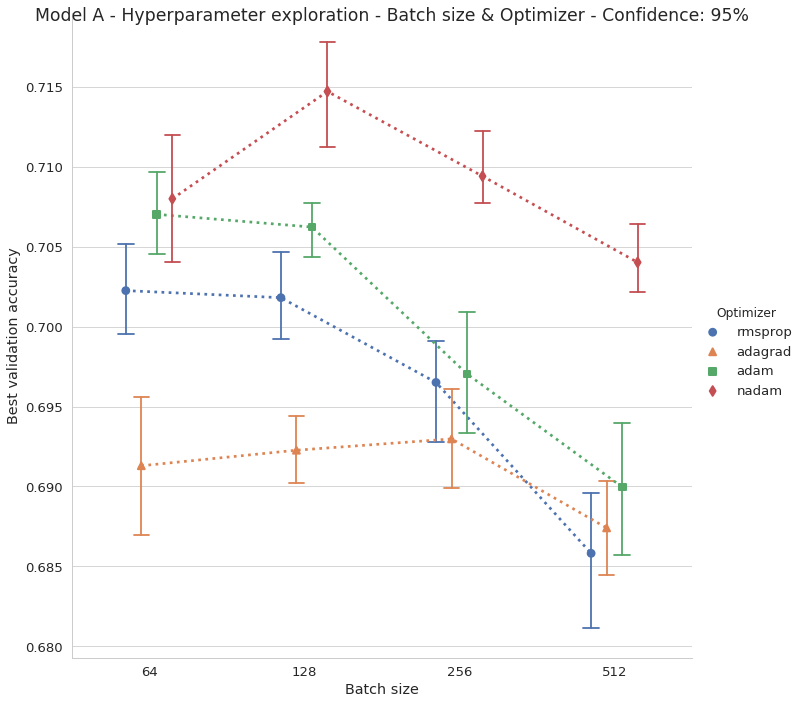

In [186]:
#%%############################################################################

###############################################################################
#
# Plot hyperparameter exploration results
#
###############################################################################

g9 = plot_hyperparameter_exploration(df_reports0, 'Batch size', 'Optimizer', 'A')

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g9.fig.savefig(os.path.join(WRK_DIR, 'chart_09.pdf'))

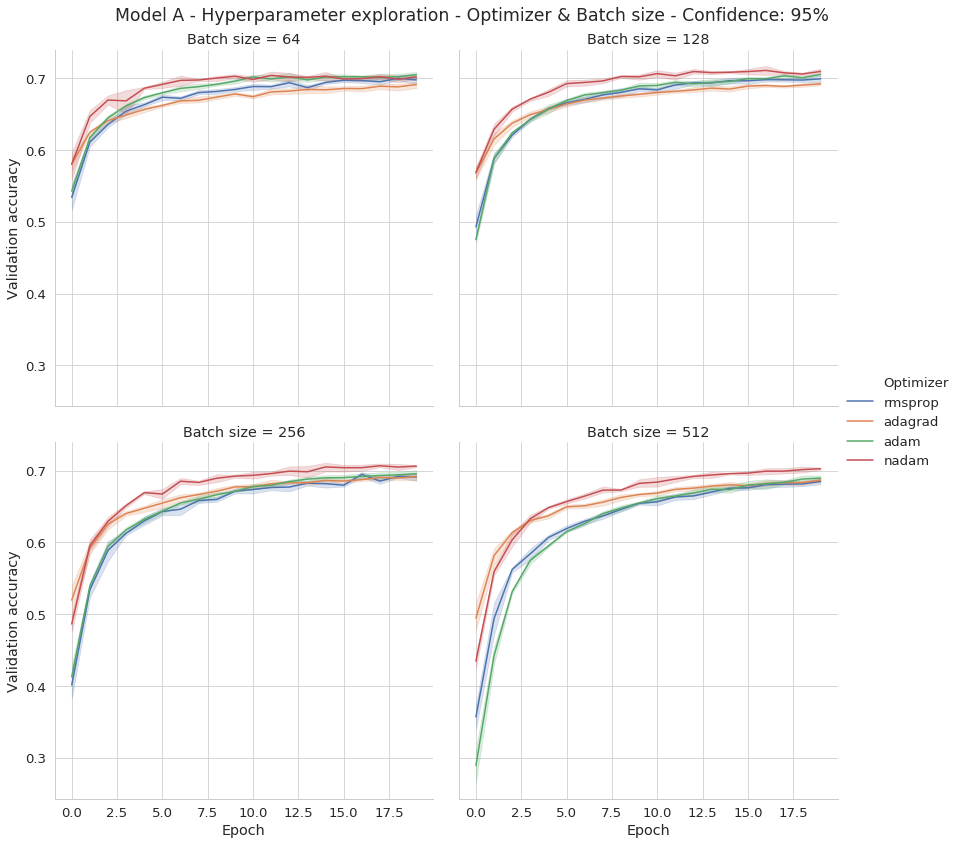

In [187]:
#%%############################################################################

###############################################################################
#
# Plot hyperparameter exploration results along epochs
#
###############################################################################

g10 = plot_hyperparameter_exploration_with_epochs(df_reports0_with_epochs,
                                                  'Optimizer',
                                                  'Batch size',
                                                  col_wrap=2,
                                                  height=6,
                                                  title_offset=.93
                                                  )

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g10.fig.savefig(os.path.join(WRK_DIR, 'chart_10.pdf'))

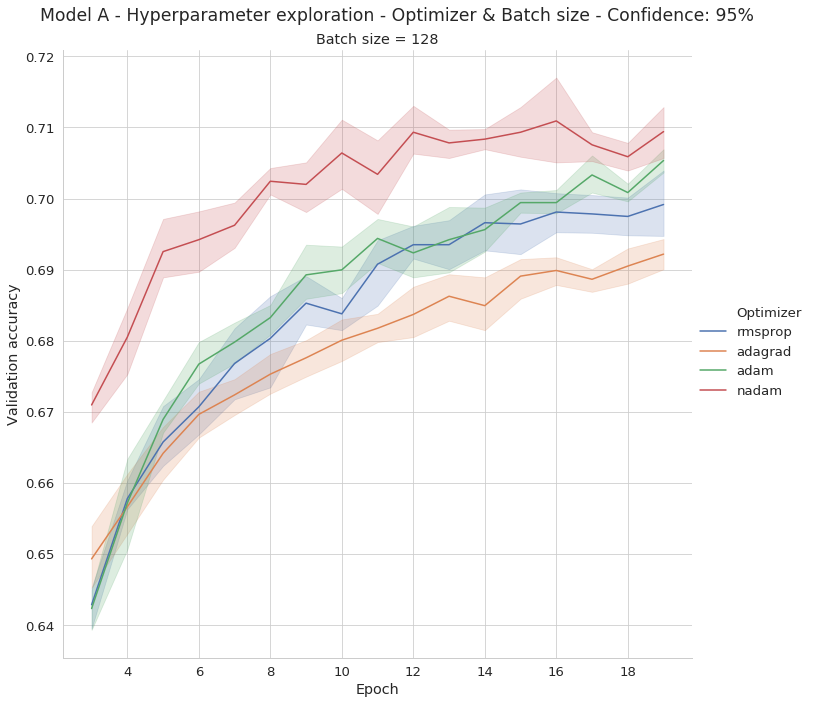

In [188]:
#%%############################################################################

###############################################################################
#
# Plot hyperparameter exploration results along epochs
#
###############################################################################

g11 = plot_hyperparameter_exploration_with_epochs(df_reports0_with_epochs[(df_reports0_with_epochs['Epoch'] > 2) &
                                                                        (df_reports0_with_epochs['Batch size'] == 128)],
                                                  'Optimizer',
                                                  'Batch size',
                                                  col_wrap=1,
                                                  height=10,
                                                  ci = 95,
                                                  title_offset=.92
                                                  )


In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g11.fig.savefig(os.path.join(WRK_DIR, 'chart_11.pdf'))

The  figure  shows  that  the  best  combination  seems  to  be  for  the nadam optimizer  and  batch  size  of 128.  However  note  that  the  confidence  interval  (95%)  of  this  combination  overlaps  with  the  ones  for  (nadam,  64)  and (nadam, 256). We choose the combination **(nadam, 128)** as the most likely better one, but we cannot affirm that assuming our confidence level of 95% this selection of hyperparamter values is better than the other two ones. 

In [0]:
#%%############################################################################

###############################################################################
#
# Selected (definitive) hyperparameters from previous grid exploration.
#
###############################################################################

BATCH_SIZE = 128
OPTIMIZER = 'nadam'

### Exploration of embedding related hyperparameters

With batch size and type of optimizer fixed now, we move on to explore embeddings:

- Whether to preload GloVe vectors in the embedding layer of our model or not.
- Whether to train the weights of embedding layer or leave them fixed.

In [190]:
#%%############################################################################

###############################################################################
#
# Next grid search for finding best secondary hyperparameters
# This exploration is for embedding preload and embedding training.
#
###############################################################################

grid1 = {'embedding_preload': [True, False],
         'embedding_train': [True, False],
         'cnn_filter_size': [4],
         'cnn_num_filters': [300],
         'batch_size': [BATCH_SIZE],
         'epochs': [20],
         'optimizer': [OPTIMIZER],
         'model_flavour': ['CNN-DENSE']
         }
grid1

{'batch_size': [128],
 'cnn_filter_size': [4],
 'cnn_num_filters': [300],
 'embedding_preload': [True, False],
 'embedding_train': [True, False],
 'epochs': [20],
 'model_flavour': ['CNN-DENSE'],
 'optimizer': ['nadam']}

The following cell runs the training session with a and saves the training reports to a timestamped file.
**Skip it if you just want to retrieve the result from a previous report file**.

In [0]:
#%%############################################################################

###############################################################################
#
# Run hyperparameter exploration 1 for Model A
#
###############################################################################

reports1 = run_training_session_from_grid(grid1, 
                                          X_seqs_train, 
                                          Y_1hot_train,
                                          repetitions=5)

###############################################################################
#
# Save training reports in timestamped file
#
###############################################################################
t = reports1[0]['starting_time']
timestamp = make_timestamp(t)
save_reports(reports1, os.path.join(WRK_DIR, f'reports1_with_repetitions_{timestamp}.pickle'))

Then we recover the training reports from a file.

**Adjust manually if you want to recover the report file just created by the cell above or if you want to retrieve an older report file**.

In [0]:
#%%############################################################################

###############################################################################
#
# Retrieve report file and sort training attempts by score (validation accuracy)
#
###############################################################################

# PICK ONE OPTION
# EITHER the report file just created by cell above:
# reports1 = load_reports(os.path.join(WRK_DIR, f'reports1_{timestamp}.pickle'))
# OR an older report file:
reports1 = load_reports(os.path.join(WRK_DIR, 'reports1_with_repetitions_20181226165557.pickle'))

In [192]:
#%%############################################################################

###############################################################################
#
# Build dataframe with the reports for this hyperparameter exploration
#
###############################################################################

df_reports1 = build_dataframe_from_reports(reports1)
df_reports1_with_epochs = build_dataframe_from_reports(reports1, only_best_epoch=False)

df_reports1[['Training trial', 
             'Hyperparameter combination', 
             'Epoch',
             'Epochs',
             'Best epoch', 
             'Best validation accuracy', 
             'Embedding preload', 
             'Embedding train']].sort_values(by=['Best validation accuracy'], 
                                             ascending=False)

,Training trial,Hyperparameter combination,Epoch,Epochs,Best epoch,Best validation accuracy,Embedding preload,Embedding train
77,3,1,17,20,17,0.713654,True,True
97,4,1,17,20,17,0.711003,True,True
16,0,1,16,20,16,0.709236,True,True
30,1,1,10,20,10,0.708352,True,True
52,2,1,12,20,12,0.706142,True,True
254,12,3,14,20,14,0.698630,False,True
292,14,3,12,20,12,0.695979,False,True
239,11,3,19,20,19,0.695095,False,True
268,13,3,8,20,8,0.692444,False,True
216,10,3,16,20,16,0.691560,False,True


In [193]:
#%%############################################################################

###############################################################################
#
# Sort by best hyperparameter combination (averaged validation accuracy)
#
###############################################################################

df_reports1.groupby(by=['Embedding preload','Embedding train'])[['Best validation accuracy']].mean().sort_values(by=['Best validation accuracy'],
                                                                                                                   ascending=False)

,,Best validation accuracy
Embedding preload,Embedding train,
True,True,0.709677
False,True,0.694741
True,False,0.671233
False,False,0.461511


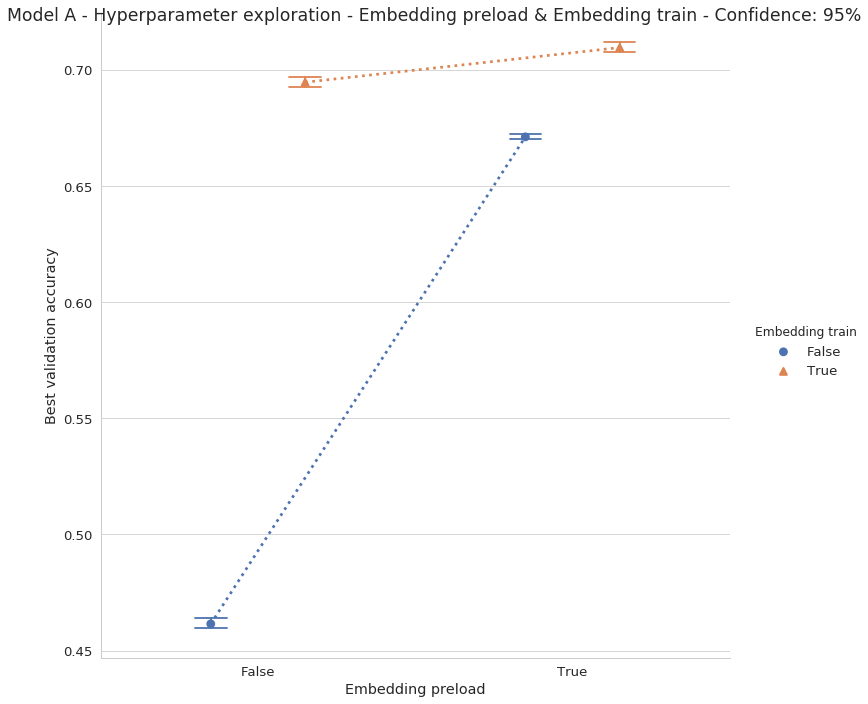

In [194]:
#%%############################################################################

###############################################################################
#
# Plot hyperparameter exploration results
#
###############################################################################

g12 = plot_hyperparameter_exploration(df_reports1, 'Embedding preload', 'Embedding train', 'A')

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g12.fig.savefig(os.path.join(WRK_DIR, 'chart_12.pdf'))

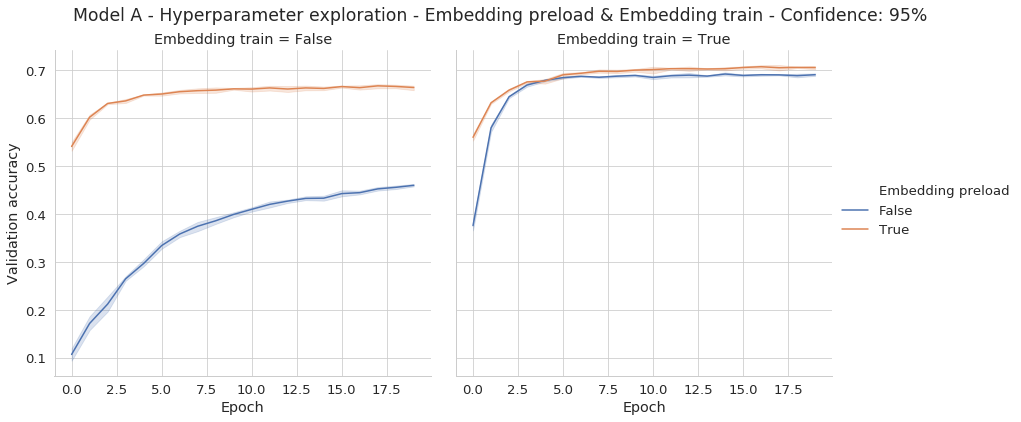

In [195]:
#%%############################################################################

###############################################################################
#
# Plot hyperparameter exploration results along epochs
#
###############################################################################

g13 = plot_hyperparameter_exploration_with_epochs(df_reports1_with_epochs,
                                              'Embedding preload',
                                              'Embedding train',
                                              col_wrap=2,
                                              height=6,
                                              title_offset=.88
                                              )

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g13.fig.savefig(os.path.join(WRK_DIR, 'chart_13.pdf'))

Note how the best hyperparameter combination to get the best possible validation accuracy is to **preload the GloVe embeddings** into the embedding layer of our model, and then allow the training process to **tweak the embedding layer's weights**. This time the confidence intervals (95%) are pretty narrow and do not overlap. Thus, we are quite confident to choose preloading the *GloVe* embedding vectors and also training the pre-loaded embeddings layer as the best option. We will set these two hyperparameters for the rest of our exploration.

In [0]:
#%%############################################################################

###############################################################################
#
# Selected (definitive) hyperparameters from previous grid exploration.
#
###############################################################################

EMBEDDING_PRELOAD = True
EMBEDDING_TRAIN = True

### Exploration of convolutional hyperparameters: filter size and number of feature maps

We focus now on exploring the best configuration for our convolutional layer, i.e., the best values for:

- Size of convolutional filters, from 2 to 10. 
- Number of convolutional filters (feature maps), from 50 to 900 in steps.

In [197]:
#%%############################################################################

###############################################################################
#
# Next grid search for finding best main hyperparameters
# This grid is for exploring CNN filter size and number of CNN filters
#
###############################################################################

grid2 = {'embedding_preload': [EMBEDDING_PRELOAD],
         'embedding_train': [EMBEDDING_TRAIN],
         # 'cnn_filter_size': [2,3,4,5,6,7,8,9,10],
         'cnn_filter_size': [2,3,4,5,6,7,8,9],
         # 'cnn_num_filters': [50, 100,300,600,900],
         'cnn_num_filters': [100,300,600,900],
         'batch_size': [BATCH_SIZE],
         'epochs': [20],
         'optimizer': [OPTIMIZER],
         'model_flavour': ['CNN-DENSE']
         }
grid2

{'batch_size': [128],
 'cnn_filter_size': [2, 3, 4, 5, 6, 7, 8, 9],
 'cnn_num_filters': [100, 300, 600, 900],
 'embedding_preload': [True],
 'embedding_train': [True],
 'epochs': [20],
 'model_flavour': ['CNN-DENSE'],
 'optimizer': ['nadam']}

The following cell runs the training session and saves the training reports to a timestamped file. 

WARNING: It can take quite a long time, even running with support of a GPU.  **Skip it if you just want to retrieve the result from a previous report file**. 

**Alternatively, run sub-section just below in which we run the training sessions for this grid search phase in several separate chunks.**

In [0]:
#%%############################################################################

###############################################################################
#
# Run hyperparameter exploration 2 for Model A
#
###############################################################################
reports2 = run_training_session_from_grid(grid2, 
                                          X_seqs_train, 
                                          Y_1hot_train,
                                          repetitions=5)

###############################################################################
#
# Save training reports in timestamped file
#
###############################################################################
t = reports2[0]['starting_time']
timestamp = make_timestamp(t)
save_reports(reports2, os.path.join(WRK_DIR, f'reports2_with_repetitions_{timestamp}.pickle'))

#### Sub-grids for CNN hyperparameters

In order to give have more resiliency (e.g., in case of Google Colab notebook might hang up) we ran this phase in separate chunks.



In [0]:
#%%############################################################################

###############################################################################
#
# We split grid2 into smaller chunks so that their reports are stored in different files.
# Thus we make the training process more resilient.
# 
###############################################################################

def partition(seq, size):
    ''' Splits a sequence into n-chunks of equal size (except for the last one)
    '''
    return [ seq[i:i+partition_size] for i in range(0, len(seq), 5)]
  
  
def run_training_session_from_subgrids_and_save(subgrids, 
                                                 session_label,
                                                 X, Y,
                                                 repetitions = 1,
                                                 offset=0):
    ''' Takes a list of portions of a grid and a session label.
        For each portion of the grid, run a training session
        and save reports to a labeled and numbered file.
        
        Use this label if needed to extend the original exploration 
        (if we wanted to extend the original grid, we would reuse this label
        and add files with correlative numbering)
        
        Parameters:
        - subgrids: a list of portions of a grid (which are list of hyperparamter combinations)
        - session_label: a string identifier to be able to group report files
        - offset: used when numbering the files
        
        Returns:
        - List of training reports
    '''
      
    for i, params in enumerate(subgrids):
        j = i + offset
        filename = f'reports2_with_repetitions_{session_label}_{j:02}.pickle'

        print(f'RUNNING split training session {session_label}, chunk {i+1} of {len(subgrids)}, with {repetitions} repetitions, saved to file {filename}')
        
        reports = run_training_session(params, X, Y,
                                       session_id=session_label,
                                       repetitions=repetitions)
        
        print(f'Saving reports to file {os.path.join(WRK_DIR, filename)}')
        save_reports(reports, os.path.join(WRK_DIR, filename))
        
        return reports


In [57]:
#%%############################################################################

###############################################################################
#
# We split grid2 into smaller sub-grids
# 
###############################################################################

grid2_part1 = {'embedding_preload': [EMBEDDING_PRELOAD],
               'embedding_train': [EMBEDDING_TRAIN],
               'cnn_filter_size': [2,3,4,5,6],
               'cnn_num_filters': [100,300,600,900],
               'batch_size': [BATCH_SIZE],
               'epochs': [20],
               'optimizer': [OPTIMIZER],
               'model_flavour': ['CNN-DENSE']
              }

grid2_part2 = {'embedding_preload': [EMBEDDING_PRELOAD],
               'embedding_train': [EMBEDDING_TRAIN],
               'cnn_filter_size': [7,8,9],
               'cnn_num_filters': [100,300,600,900],
               'batch_size': [BATCH_SIZE],
               'epochs': [20],
               'optimizer': [OPTIMIZER],
               'model_flavour': ['CNN-DENSE']
              }


grid2_part3 = {'embedding_preload': [EMBEDDING_PRELOAD],
               'embedding_train': [EMBEDDING_TRAIN],
               'cnn_filter_size': [2,3,4,5,6,7,8,9],
               'cnn_num_filters': [50],
               'batch_size': [BATCH_SIZE],
               'epochs': [20],
               'optimizer': [OPTIMIZER],
               'model_flavour': ['CNN-DENSE']
               }

grid2_part1, grid2_part2, grid2_part3

({'batch_size': [128],
  'cnn_filter_size': [2, 3, 4, 5, 6],
  'cnn_num_filters': [100, 300, 600, 900],
  'embedding_preload': [True],
  'embedding_train': [True],
  'epochs': [20],
  'model_flavour': ['CNN-DENSE'],
  'optimizer': ['nadam']},
 {'batch_size': [128],
  'cnn_filter_size': [7, 8, 9],
  'cnn_num_filters': [100, 300, 600, 900],
  'embedding_preload': [True],
  'embedding_train': [True],
  'epochs': [20],
  'model_flavour': ['CNN-DENSE'],
  'optimizer': ['nadam']},
 {'batch_size': [128],
  'cnn_filter_size': [2, 3, 4, 5, 6, 7, 8, 9],
  'cnn_num_filters': [50],
  'embedding_preload': [True],
  'embedding_train': [True],
  'epochs': [20],
  'model_flavour': ['CNN-DENSE'],
  'optimizer': ['nadam']})

**Skip if you want to retrieve already stored reports.**

In [0]:
#%%############################################################################

###############################################################################
#
# Run partition and save reports
# 
###############################################################################
partition_size = 5
label = 'A'
repetitions = 5

subgrids2_part1 = partition(calculate_params_from_grid(grid2_part1), partition_size)
run_training_session_from_subgrids_and_save(subgrids2_part1, 
                                            label, 
                                            X_seqs_train, 
                                            Y_1hot_train, 
                                            repetitions)

**Skip if you want to retrieve already stored reports.**

In [0]:
#%%############################################################################

###############################################################################
#
# Run partition and save reports
# 
###############################################################################
partition_size = 5
label = 'A'
repetitions = 5
offset = 4

subgrids2_part2 = partition(calculate_params_from_grid(grid2_part2), partition_size)
run_training_session_from_subgrids_and_save(subgrids2_part2, 
                                            label, 
                                            X_seqs_train, 
                                            Y_1hot_train, 
                                            repetitions,
                                            offset=offset)

**Skip if you want to retrieve already stored reports.**


In [0]:
#%%############################################################################

###############################################################################
#
# Run partition and save reports
# 
###############################################################################
partition_size = 5
label = 'A'
repetitions = 5
offset = 7

subgrids2_part3 = partition(calculate_params_from_grid(grid2_part3), partition_size)

# This sub-grid was not finally included in the final report
# run_training_session_from_subgrids_and_save(subgrids2_part3, 
#                                            label, 
#                                            X_seqs_train, 
#                                            Y_1hot_train, 
#                                            repetitions,
#                                            offset=offset)

The following cell consolidates all the reports from files produced in the previous steps, into a single one.

**Skip if you want to retrieve the reports from an already consolidated single file.**


In [59]:
#%%############################################################################

###############################################################################
#
# Recover all chunked report files and consolidate
# 
###############################################################################

filenames = [f'reports2_with_repetitions_A_{i:02}.pickle' for i in range(7)]
print('Files to consolidate:\n', '\n '.join(filenames))

reports2 = [ r for reports in ( load_reports(os.path.join(WRK_DIR, f)) for f in filenames ) for r in reports ]

# 
# Save consolidated report file
#
consolidated_file = f'reports2_with_repetitions_A_{make_timestamp()[:8]}.pickle'
print(f'Saving consolidated reports to file: {consolidated_file}')
save_reports(reports2, os.path.join(WRK_DIR, consolidated_file))

Files to consolidate:
 reports2_with_repetitions_A_00.pickle
 reports2_with_repetitions_A_01.pickle
 reports2_with_repetitions_A_02.pickle
 reports2_with_repetitions_A_03.pickle
 reports2_with_repetitions_A_04.pickle
 reports2_with_repetitions_A_05.pickle
 reports2_with_repetitions_A_06.pickle
Saving consolidated reports to file: reports2_with_repetitions_A_20190107.pickle


### Resuming exploration of CNN hyperparameters

Then we recover the training reports from a file.

**Adjust manually if you want to recover the report file just created or if you want to retrieve an older report file**.

In [0]:
#%%############################################################################

###############################################################################
#
# Retrieve report file and sort training attempts by score (validation accuracy)
#
###############################################################################

# PICK ONE OPTION
# EITHER the report file just created by cell above:
# reports1 = load_reports(os.path.join(WRK_DIR, f'reports2_{timestamp}.pickle'))
# OR an another report file:
reports2 = load_reports(os.path.join(WRK_DIR, 'reports2_with_repetitions_A_20181228.pickle'))

In [200]:
#%%############################################################################

###############################################################################
#
# Build dataframe with the reports for this hyperparameter exploration
#
###############################################################################

df_reports2 = build_dataframe_from_reports(reports2)
df_reports2_with_epochs = build_dataframe_from_reports(reports2, only_best_epoch=False)

df_reports2[['Training trial', 
             'Hyperparameter combination', 
             'Epoch',
             'Epochs',
             'Best epoch', 
             'Best validation accuracy', 
             'Number of filters', 
             'CNN filter size']].sort_values(by=['Best validation accuracy'], 
                                             ascending=False)

,Training trial,Hyperparameter combination,Epoch,Epochs,Best epoch,Best validation accuracy,Number of filters,CNN filter size
731,36,3,11,20,11,0.727795,900,3
277,13,3,17,20,17,0.727795,600,2
330,16,4,10,20,10,0.727353,900,2
374,18,4,14,20,14,0.726911,900,2
308,15,4,8,20,8,0.725586,900,2
770,38,3,10,20,10,0.725586,900,3
250,12,3,10,20,10,0.725586,600,2
714,35,3,14,20,14,0.724702,900,3
678,33,2,18,20,18,0.724702,600,3
758,37,3,18,20,18,0.723818,900,3


In [201]:
#%%############################################################################

###############################################################################
#
# Sort by best hyperparameter combination (averaged validation accuracy)
#
###############################################################################

df_reports2.groupby(by=['Number of filters','CNN filter size'])[['Best validation accuracy']].mean().sort_values(by=['Best validation accuracy'],
                                                                                                                 ascending=False)

Best validation accuracy
Number of filters CNN filter size                          
900               3                                0.725055
                  2                                0.724878
600               2                                0.723376
                  3                                0.721432
900               4                                0.718604
                  5                                0.716483
600               4                                0.715776
                  5                                0.714185
300               4                                0.713920
                  2                                0.713213
600               6                                0.712771
300               3                                0.712682
900               6                                0.711887
                  7                                0.711180
300               5                                0.708263
600               7                                0.707733
                  8                                0.706584
300               7                                0.705435
900               8                                0.705170
300               6                                0.704375
900               9                                0.702696
600               9                                0.702430
300               8                                0.701458
                  9                                0.700221
100               2                                0.698719
                  4                                0.694741
                  3                                0.693858
                  5                                0.691206
                  6                                0.688025
                  8                                0.685373
                  7                                0.685020
                  9                                0.683606

We've just trained our two most relevant hyperparameters for our convolutional model, which are **convolutional filter size** and **number of convolutional filters**. Let's plot ** best validation accuracy** for their different combinations.

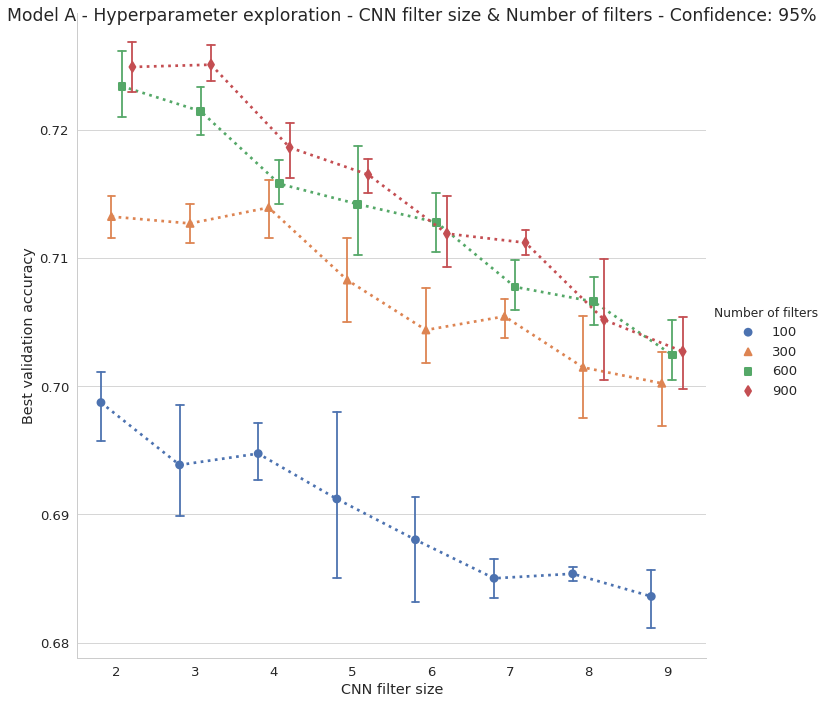

In [202]:
#%%############################################################################

###############################################################################
#
# Plot hyperparameter exploration results
#
###############################################################################

g14 = plot_hyperparameter_exploration(df_reports2, 'CNN filter size', 'Number of filters', 'A', dodge=.4)

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g14.fig.savefig(os.path.join(WRK_DIR, 'chart_14.pdf'))

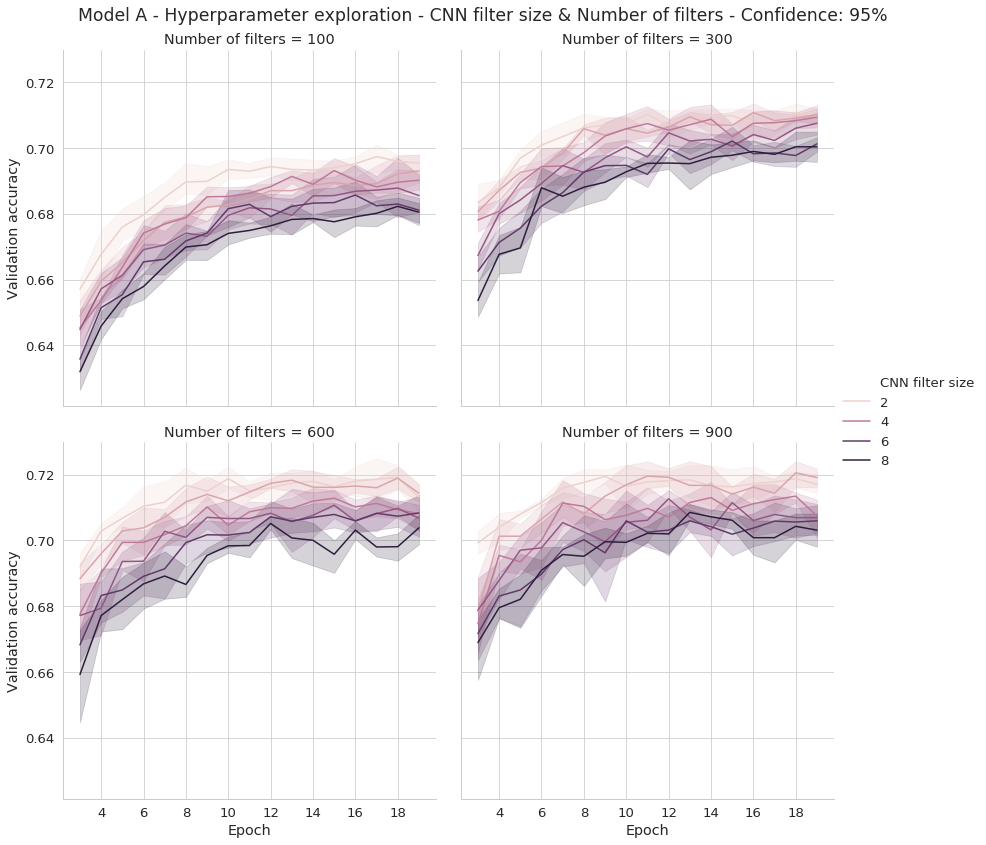

In [203]:
#%%############################################################################

###############################################################################
#
# Plot hyperparameter exploration results along epochs
#
###############################################################################

g15 = plot_hyperparameter_exploration_with_epochs(df_reports2_with_epochs[(df_reports2_with_epochs['CNN filter size'] > 1) &
                                                                        (df_reports2_with_epochs['CNN filter size'] < 8) &
                                                                        (df_reports2_with_epochs['Epoch'] > 2)],
                                                  'CNN filter size',
                                                  'Number of filters',
                                                  col_wrap=2,
                                                  height=6,
                                                  title_offset=.93
                                                  )

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g15.fig.savefig(os.path.join(WRK_DIR, 'chart_15.pdf'))

We need to make a decision based on overlapping confidence intervals, so we resort to a statistical** t-test** to confirm our visual analysis.

In [0]:
#%%############################################################################

#%%############################################################################
#
# ttest - 2-tailed
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
#
#%%############################################################################

def t_test(sampleA, sampleB, alpha=.05, silent=False):
    ''' Performs t-test between two samples and level of confidence = alpha
    '''
    
    p_value = stats.ttest_ind(sampleA,
                              sampleB, 
                              equal_var = False ).pvalue
    
    if not silent:
        if p_value < alpha:
            print(f'P-value for  {p_value} < significance ({alpha}). The null hypothesis can be rejected')
            print('The two samples yield significantly different accuracy).')
        else:
            print(f'P-value too high: {p_value} > significance ({alpha}). The null hypothesis cannot be rejected.')
    
    return p_value 

In [205]:
#%%############################################################################

#%%############################################################################
#
# t-test for combinations of (filter_size, num_filters): (2,600) and (3,900)
#
#%%############################################################################

# Filter conditions
filter_size_2 = df_reports2['CNN filter size'] == 2
filter_size_3 = df_reports2['CNN filter size'] == 3
num_filters_600 = df_reports2['Number of filters'] == 600
num_filters_900 = df_reports2['Number of filters'] == 900

#
# Calculate p-value of best validation accuracy, for best and 3rd best hyperparameter combinations
#
sampleA = df_reports2[ filter_size_2 & num_filters_600 ]['Best validation accuracy'].values
sampleB = df_reports2[ filter_size_3 & num_filters_900 ]['Best validation accuracy'].values
print(f'Sample A (filter size 2, 600 filters): {sampleA}')
print(f'Sample B (filter size 3, 900 filters): {sampleB}')

        
t_test(sampleA, sampleB)

Sample A (filter size 2, 600 filters): [0.71939903 0.72205038 0.72558551 0.72779496 0.72205038]
Sample B (filter size 3, 900 filters): [0.72470172 0.72779496 0.72381794 0.72558551 0.72337605]
P-value too high: 0.3538836313507226 > significance (0.05). The null hypothesis cannot be rejected.


0.3538836313507226

The third phase of the hyperparamter exploration is the most interesting one as it deals with number and size of convolutional filters, which is where the ability to extract positional information is. In the figure above we note that the best mean for validation accuracy is above 0.72 and corresponds to a filter size of 3 and 900 feature maps. However, its 95% confidence interval overlaps with two other combinations of size and number of filters: (2,900) and (2,600), both of which have slightly lower accuracy means. We have performed a 2-tailed t-test for combinations (3,900) and (2,600) to confirm our reasoning and it has yielded a p-value of 0.3539, which is much greater than our significance level of 0.05. Thus, we can say that we have no solid base to decide which one of the 3 best combinations is better. **For this reason we chose filter size of 2 and 600 feature maps, as fewer number of filters of smaller size are expected to build a model that is less complex, therefore a model that is faster to train and less prone to overfitting**.

On the other hand, the best hyperparameter combination in terms of performance seems to be the one with the shortest filter size, 2. We see that slightly longer filter sizes are not significantly  better, and that even longer filter sizes yield worse scores. This can be explained if we assume that **most of the positional information is encoded in bi-grams** and understanding that **longer filters**, even though they have the ability to *emulate* shorter ones, **may easily tend to overfit** and learn longer patterns from the documents that do not generalize.

### Best hyperparameters for Model A

We put together the best hyperparameter combination found. We will try and **adjust the number of epochs** to make sure that the validation accuracy reaches a stable *plateau*. See visualisation of validation accuracy below.

In [0]:
#%%############################################################################

###############################################################################
#
# Selected (definitive) hyperparameters from previous grid exploration.
#
###############################################################################

CNN_FILTER_SIZE = 2
CNN_NUM_FILTERS = 600
EPOCHS = 30    # We increase this for the final model training

In [207]:
#%%############################################################################

###############################################################################
#
# Finally, best parameters for Model A after previous grid searchs
#
###############################################################################
paramsA = {'embedding_preload': EMBEDDING_PRELOAD,
           'embedding_train': EMBEDDING_TRAIN,
           'cnn_filter_size': CNN_FILTER_SIZE,
           'cnn_num_filters': CNN_NUM_FILTERS,
           'batch_size': BATCH_SIZE,
           'epochs': EPOCHS,
           'optimizer': OPTIMIZER,
           'model_flavour': 'CNN-DENSE'
          }
print('Model A:')
display_params(paramsA)

Model A:
                            
batch_size               128
cnn_filter_size            2
cnn_num_filters          600
embedding_preload       True
embedding_train         True
epochs                    30
model_flavour      CNN-DENSE
optimizer              nadam



### Training Model A with best hyperparameter combination

We finally train Model A on the training dataset with the best hyperparameter combination we have found after exploration.

**Skip the following cell if you just want to retrieve the result from a previous report file.** 

In [0]:
#%%############################################################################

###############################################################################
#
# Train Model A with best hyperparameters and save weights to file
#
###############################################################################
reportA, modelA = create_and_train_model(paramsA, 
                                         X_seqs_train, Y_1hot_train, 
                                         weights_filepath=os.path.join(WRK_DIR, WEIGHTS_FILENAME_A))
print(f'Model A: best weights saved to file: {WEIGHTS_FILENAME_A}')

###############################################################################
#
# Save training reports in file
#
###############################################################################
save_report(reportA, os.path.join(WRK_DIR, TRAIN_REPORT_FILENAME_A))
print(f'Model A: training report saved to file: {TRAIN_REPORT_FILENAME_A}')

In [208]:
#%%############################################################################

###############################################################################
#
# Retrieve training report and weights from files
# and re-create ModelA
#
###############################################################################

# Retrieve training report with best hyperparameters
reportA = load_report(os.path.join(WRK_DIR, TRAIN_REPORT_FILENAME_A))

# New instance of Model A
modelA = create_keras_model(**paramsA)

# Load best weights
modelA.load_weights(os.path.join(WRK_DIR, os.path.basename(reportA['weights_file'])))

Creating model with params:
          embedding_preload=True,
          embedding_train=True,
          cnn_num_filters=600,
          cnn_filter_size=2,
          dropout=0.5,
          max_norm_constraint=3.0,
          optimizer=nadam,
          embedding_matrix=[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.28850999 -0.77578998  0.14545    ...  0.39605001  0.72693002
   0.25692001]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
          
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________

In [209]:
#%%############################################################################

###############################################################################
#
# Training and validation accuracy along epochs summarised in a DataFrame
#
###############################################################################

df_reportA_with_epochs = build_dataframe_from_reports([reportA], only_best_epoch=False)

print('Model A:')
display_params(paramsA)
df_reportA_with_epochs[['Epoch',
                        'Training accuracy',
                        'Validation accuracy']]

Model A:
                            
batch_size               128
cnn_filter_size            2
cnn_num_filters          600
embedding_preload       True
embedding_train         True
epochs                    30
model_flavour      CNN-DENSE
optimizer              nadam



,Epoch,Training accuracy,Validation accuracy
0,0,0.360844,0.613345
1,1,0.630980,0.656209
2,2,0.707767,0.675652
3,3,0.761794,0.688025
4,4,0.799249,0.703049
5,5,0.835930,0.702607
6,6,0.866976,0.713213
7,7,0.892167,0.711887
8,8,0.911170,0.711445
9,9,0.920230,0.709236


                            
batch_size               128
cnn_filter_size            2
cnn_num_filters          600
embedding_preload       True
embedding_train         True
epochs                    30
model_flavour      CNN-DENSE
optimizer              nadam



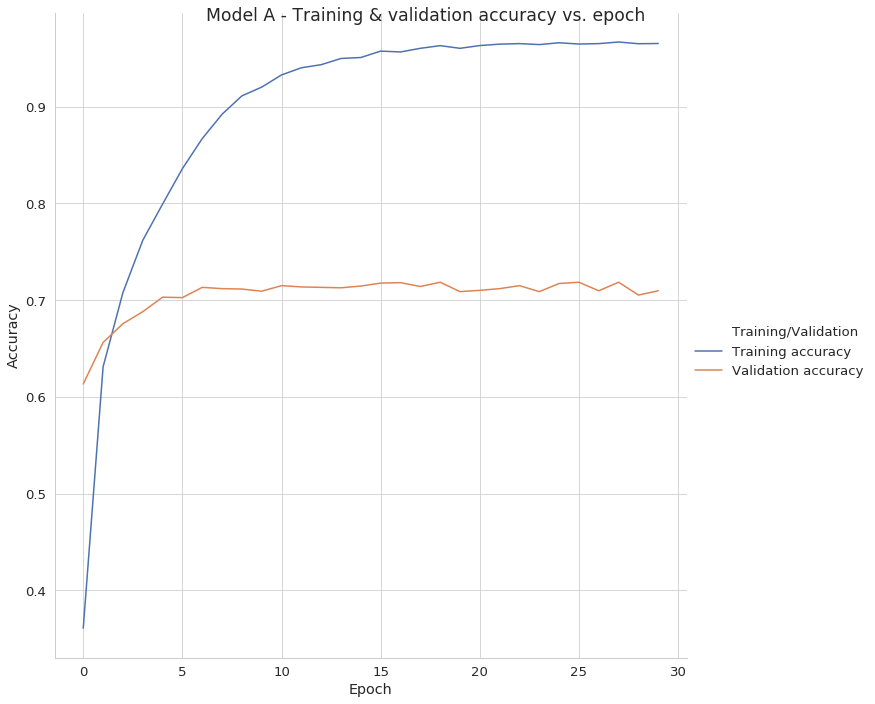

In [210]:
#%%############################################################################

###############################################################################
# 
# Plot validation accuracy along training epochs for best configuration of Model A
#
###############################################################################
display_params(paramsA)
g16 = plot_epochs(df_reportA_with_epochs, model_case='A')

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g16.fig.savefig(os.path.join(WRK_DIR, 'chart_16.pdf'))

### Score model A

We finally get a single validation accuracy score after this single training session. Later, we will consider variance and repeat this process several times to get means and confidence intervals to base our model evaluation on.

WARNING: this runs fast on GPU but might take a while on CPU.

In [211]:
#%%############################################################################

###############################################################################
# 
# Evaluate Model A with test dataset
#
###############################################################################

modelA_loss, modelA_score = modelA.evaluate(X_seqs_test, Y_1hot_test)

print(f'Score of Model A: {modelA_score}')

7532/7532 [==============================] - 3s 367us/step
Score of Model A: 0.6683483802759451


## Training Model B

In this section we train Model B following the same process as for the final training of Model A.

Recall the configuration of Model B:

|Model|          |	        |			 |        |     |
|---  |---       |---       |---         |---     |---  |
|  A  |Tokenizer |Embeddings|CNN Layer   |Max Pool|Dense|
|**B**|**Tokenizer**|**Embeddings**|**CNN Layer(1)**|**Max Pool**|**Dense**|
|C    |Tokenizer |Embeddings|Average     |Dense   |     |
|D    |Tokenizer |TFIDF     |Naïve Bayes |        |     |

In [212]:
#%%############################################################################

###############################################################################
#
# Train ModelB with same params as ModelA except CNN_FILTER_SIZE=1
#
###############################################################################

CNN_FILTER_SIZE = 1

#
# Previous grid search for finding best secondary hyperparameters
# This is grid is for exploring embedding preload and embedding training.
#

paramsB = {'embedding_preload': EMBEDDING_PRELOAD,
           'embedding_train': EMBEDDING_TRAIN,
           'cnn_filter_size': CNN_FILTER_SIZE,
           'cnn_num_filters': CNN_NUM_FILTERS,
           'batch_size': BATCH_SIZE,
           'epochs': EPOCHS,
           'optimizer': OPTIMIZER,
           'model_flavour': 'CNN-DENSE'
           }
print('Model B:')
display_params(paramsB)

Model B:
                            
batch_size               128
cnn_filter_size            1
cnn_num_filters          600
embedding_preload       True
embedding_train         True
epochs                    30
model_flavour      CNN-DENSE
optimizer              nadam



The following cell runs the training session and saves the training reports to a timestamped file. 

WARNING: It can take quite a long time, even running with support of a GPU.  **Skip it if you just want to retrieve the result from a previous report file**.

In [0]:
#%%############################################################################

###############################################################################
#
# Train Model B with best hyperparameters (from Model B) and save weights to file
#
###############################################################################
reportB, modelB = create_and_train_model(paramsB, 
                                         X_seqs_train, Y_1hot_train,
                                         weights_filepath=os.path.join(WRK_DIR, WEIGHTS_FILENAME_B))
print(f'Model B: best weights saved to file: {WEIGHTS_FILENAME_B}')

###############################################################################
#
# Save training reports in file
#
###############################################################################
save_report(reportB, os.path.join(WRK_DIR, TRAIN_REPORT_FILENAME_B))
print(f'Model B: training report saved to file: {TRAIN_REPORT_FILENAME_B}')

In [213]:
#%%############################################################################

###############################################################################
#
# Recover modelB config from report file, create new instance and load weights
#
###############################################################################

# Retrieve training report
reportB = load_report(os.path.join(WRK_DIR, TRAIN_REPORT_FILENAME_B))

# New instance of Model B
modelB = create_keras_model(**paramsB)

# Load best weights
modelB.load_weights(os.path.join(WRK_DIR, os.path.basename(reportB['weights_file'])))

Creating model with params:
          embedding_preload=True,
          embedding_train=True,
          cnn_num_filters=600,
          cnn_filter_size=1,
          dropout=0.5,
          max_norm_constraint=3.0,
          optimizer=nadam,
          embedding_matrix=[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.28850999 -0.77578998  0.14545    ...  0.39605001  0.72693002
   0.25692001]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
          
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________

In [214]:
#%%############################################################################

###############################################################################
#
# Training and validation accuracy along epochs summarised in a DataFrame
#
###############################################################################

df_reportB_with_epochs = build_dataframe_from_reports([reportB], only_best_epoch=False)

print('Model B:')
display_params(paramsB)
df_reportB_with_epochs[['Epoch',
                        'Training accuracy',
                        'Validation accuracy']]

Model B:
                            
batch_size               128
cnn_filter_size            1
cnn_num_filters          600
embedding_preload       True
embedding_train         True
epochs                    30
model_flavour      CNN-DENSE
optimizer              nadam



,Epoch,Training accuracy,Validation accuracy
0,0,0.322616,0.614229
1,1,0.608883,0.656650
2,2,0.684565,0.688467
3,3,0.730085,0.697746
4,4,0.769418,0.700398
5,5,0.801127,0.701281
6,6,0.824881,0.709677
7,7,0.851950,0.712329
8,8,0.874599,0.712771
9,9,0.882665,0.713213


                            
batch_size               128
cnn_filter_size            1
cnn_num_filters          600
embedding_preload       True
embedding_train         True
epochs                    30
model_flavour      CNN-DENSE
optimizer              nadam



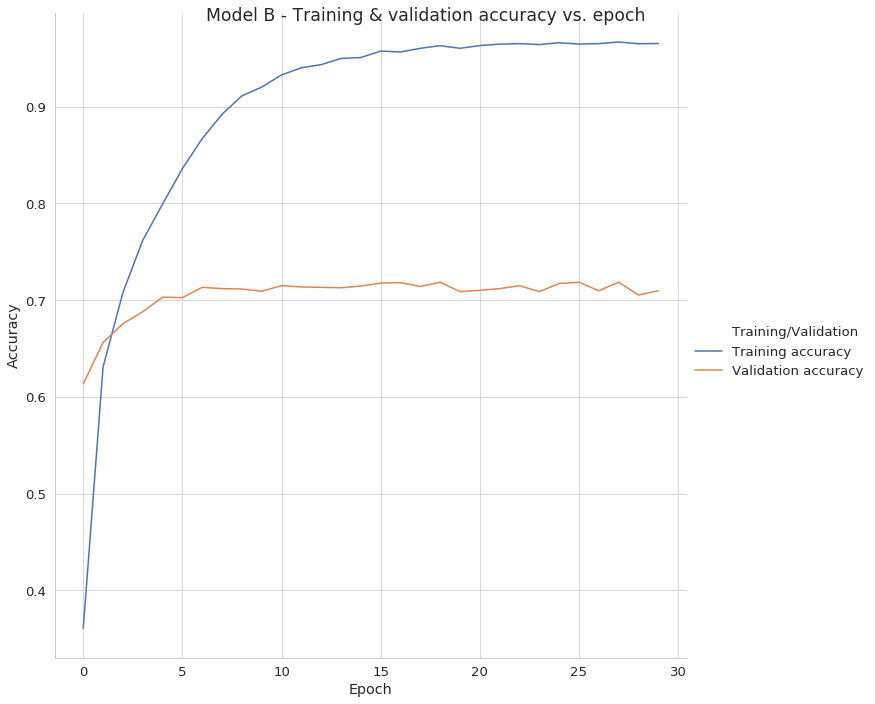

In [215]:
#%%############################################################################

###############################################################################
# 
# Plot validation accuracy along training epochs for best configuration of Model B
#
###############################################################################
display_params(paramsB)
g17 = plot_epochs(df_reportA_with_epochs, model_case='B')

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g17.fig.savefig(os.path.join(WRK_DIR, 'chart_17.pdf'))

We finally get a single validation accuracy score after this single training session. Later, we will consider variance and repeat this process several times to get means and confidence intervals to base our model evaluation on.

WARNING: this runs fast on GPU but might take a while on CPU.

In [216]:
#%%############################################################################

###############################################################################
# 
# Evaluate Model B with test dataset
#
###############################################################################

modelB_loss, modelB_score = modelB.evaluate(X_seqs_test, Y_1hot_test)

print(f'Score of Model B: {modelB_score}')

7532/7532 [==============================] - 2s 269us/step
Score of Model B: 0.6686139139670738


## Training Model C

In this section we train Model C. Recall its structure:

|Model|          |	        |			 |        |     |
|---  |---       |---       |---         |---     |---  |
|A    |Tokenizer |Embeddings|CNN Layer   |Max Pool|Dense|
|B    |Tokenizer |Embeddings|CNN Layer(1)|Max Pool|Dense|
|**C**|**Tokenizer**|**Embeddings**|**Average**|**Dense**|     |
|D    |Tokenizer |TFIDF     |Naïve Bayes |        |     |

Note how we increment the number of epochs to 1000 to allow validation accuracy to reach a stable *plateau*.

In [217]:
#%%############################################################################

###############################################################################
#
# Train ModelC
#
###############################################################################

#
# Previous grid search for finding best secondary hyperparameters
# This is grid is for exploring embedding preload and embedding training.
#

paramsC = {'embedding_preload': EMBEDDING_PRELOAD,
           'embedding_train': EMBEDDING_TRAIN,
           'batch_size': BATCH_SIZE,
           'epochs': 1000,
           'optimizer': OPTIMIZER,
           'model_flavour': 'AVG-DENSE'
           }
print('Model C:')
display_params(paramsC)

Model C:
                            
batch_size               128
embedding_preload       True
embedding_train         True
epochs                  1000
model_flavour      AVG-DENSE
optimizer              nadam



The following cell runs the training session and saves the training reports to a timestamped file. 

WARNING: It can take quite a long time, even running with support of a GPU.  **Skip it if you just want to retrieve the result from a previous report file**.

In [0]:
#%%############################################################################

###############################################################################
#
# Train Model C and save weights to file
#
###############################################################################
reportC, modelC = create_and_train_model(paramsC, 
                                         X_seqs_train, Y_1hot_train,
                                         weights_filepath=os.path.join(WRK_DIR, WEIGHTS_FILENAME_C))
print(f'Model C: best weights saved to file: {WEIGHTS_FILENAME_C}')

###############################################################################
#
# Save training reports in file
#
###############################################################################
save_report(reportC, os.path.join(WRK_DIR, TRAIN_REPORT_FILENAME_C))
print(f'Model C: training report saved to file: {TRAIN_REPORT_FILENAME_C}')

In [218]:
#%%############################################################################

###############################################################################
#
# Recover modelC config from report file, create new instance and load weights
#
###############################################################################

# Retrieve training report
reportC = load_report(os.path.join(WRK_DIR, TRAIN_REPORT_FILENAME_C))

# New instance of Model B
modelC = create_keras_model(**reportC['params'])

# Load best weights
modelC.load_weights(os.path.join(WRK_DIR, os.path.basename(reportC['weights_file'])))

Creating model with params:
          embedding_preload=True,
          embedding_train=True,
          cnn_num_filters=300,
          cnn_filter_size=4,
          dropout=0.5,
          max_norm_constraint=3.0,
          optimizer=nadam,
          embedding_matrix=[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.28850999 -0.77578998  0.14545    ...  0.39605001  0.72693002
   0.25692001]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
          
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________

In [219]:
#%%############################################################################

###############################################################################
#
# Training and validation accuracy along epochs summarised in a DataFrame
#
###############################################################################

df_reportC_with_epochs = build_dataframe_from_reports([reportC], only_best_epoch=False)

print('Model C:')
display_params(paramsC)
df_reportC_with_epochs[['Epoch',
                        'Training accuracy',
                        'Validation accuracy']]

Model C:
                            
batch_size               128
embedding_preload       True
embedding_train         True
epochs                  1000
model_flavour      AVG-DENSE
optimizer              nadam



,Epoch,Training accuracy,Validation accuracy
0,0,0.071263,0.108705
1,1,0.103083,0.164384
2,2,0.128494,0.188688
3,3,0.172799,0.225806
4,4,0.202409,0.246575
5,5,0.226936,0.270879
6,6,0.264833,0.285462
7,7,0.291680,0.338931
8,8,0.319191,0.326558
9,9,0.334217,0.342024


                            
batch_size               128
embedding_preload       True
embedding_train         True
epochs                  1000
model_flavour      AVG-DENSE
optimizer              nadam



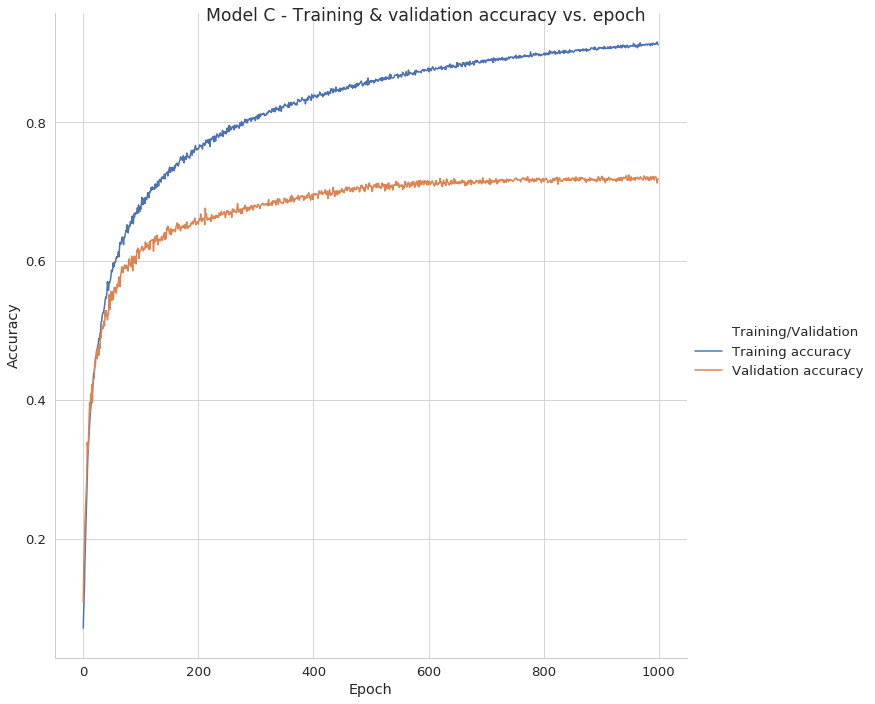

In [220]:
#%%############################################################################

###############################################################################
# 
# Plot validation accuracy along training epochs for best configuration of Model B
#
###############################################################################
display_params(paramsC)
g18 = plot_epochs(df_reportC_with_epochs, model_case='C')

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g18.fig.savefig(os.path.join(WRK_DIR, 'chart_18.pdf'))

We finally get a single validation accuracy score after this single training session. Later, we will consider variance and repeat this process several times to get means and confidence intervals to base our model evaluation on.

WARNING: this runs fast on GPU but might take a while on CPU.

In [221]:
#%%############################################################################

###############################################################################
# 
# Evaluate Model C with test dataset
#
###############################################################################

modelC_loss, modelC_score = modelC.evaluate(X_seqs_test, Y_1hot_test)

print(f'Score of Model C: {modelC_score}')

7532/7532 [==============================] - 0s 63us/step
Score of Model C: 0.6563993627190653


## Training Model D

In this section we train Model D. Recall its structure:

|Model|          |	        |			 |        |     |
|---  |---       |---       |---         |---     |---  |
|A    |Tokenizer |Embeddings|CNN Layer   |Max Pool|Dense|
|B    |Tokenizer |Embeddings|CNN Layer(1)|Max Pool|Dense|
|C    |Tokenizer |Embeddings|Average     |Dense   |     |
|**D**|**Tokenizer**|**TFIDF**|**Naïve Bayes**|        |     |

Training Model D (Multinomial Naïve Bayes) is pretty fast on CPU. We only save the report of the exploration phase, but not the weights of the model.

In [222]:
#%%############################################################################

###############################################################################
# 
# Train Model D (Näive Bayes classifier with TFIDF document representation)
#
###############################################################################

gridD = { 'model_flavour': ['NAIVE-BAYES'],
          'alpha' : [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]}
gridD

{'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'model_flavour': ['NAIVE-BAYES']}

**Skip the following cell if you just want to retrieve a previous exploration report from a file**

In [0]:
#%%############################################################################

###############################################################################
#
# Run hyperparameter exploration for Model D
#
###############################################################################

reportsD = run_training_session_from_grid(gridD, X_tfidf_train, Y_train, repetitions=5)

###############################################################################
#
# Save training reports in timestamped file
#
###############################################################################
t = reportsD[0]['starting_time']
timestamp = make_timestamp(t)
save_reports(reportsD, os.path.join(WRK_DIR, f'reportsD_{timestamp}.pickle'))

In [0]:
#%%############################################################################

###############################################################################
#
# Retrieve report file and sort training attempts by score (validation accuracy)
#
###############################################################################

# PICK ONE OPTION
# EITHER the report file just created by cell above:
# reportsD = load_reports(os.path.join(WRK_DIR, f'reportsD_{timestamp}.pickle'))
# OR an older report file:
reportsD = load_reports(os.path.join(WRK_DIR, 'reportsD_20181228174155.pickle'))

In [224]:
#%%############################################################################

###############################################################################
#
# Build dataframe with the reports for this hyperparameter exploration
#
###############################################################################

df_reportsD = build_dataframe_from_reports(reportsD)
df_reportsD_with_epochs = build_dataframe_from_reports(reportsD, only_best_epoch=False)

df_reportsD[['Training trial', 
             'Hyperparameter combination',
             'Best validation accuracy', 
             'Alpha']].sort_values(by=['Best validation accuracy'], 
                                             ascending=False)                                             

,Training trial,Hyperparameter combination,Best validation accuracy,Alpha
31,31,7,0.694300,0.7
11,11,3,0.693504,0.3
44,44,9,0.693327,0.9
41,41,9,0.692620,0.9
35,35,8,0.692355,0.8
48,48,10,0.691118,1.0
30,30,7,0.690499,0.7
38,38,8,0.690411,0.8
39,39,8,0.689881,0.8
27,27,6,0.689527,0.6


In [225]:
#%%############################################################################

###############################################################################
#
# Sort by best hyperparameter combination (averaged validation accuracy)
#
###############################################################################

df_reportsD.groupby(by=['Alpha'])[['Best validation accuracy']].mean().sort_values(by=['Best validation accuracy'],
                                                                                   ascending=False)

,Best validation accuracy
Alpha,
0.8,0.688749
0.9,0.688484
0.6,0.687176
0.5,0.686840
0.7,0.686381
0.3,0.686363
1.0,0.685426
0.4,0.681697
0.2,0.679152


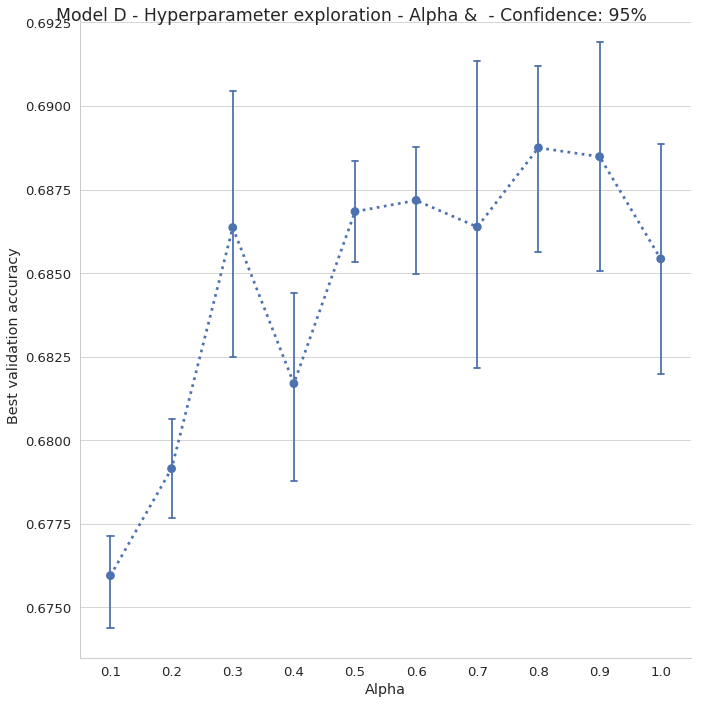

In [226]:
#%%############################################################################

###############################################################################
#
# Plot hyperparameter exploration results
#
###############################################################################

g19 = plot_hyperparameter_exploration(df_reportsD, 'Alpha', None, 'D')

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g19.fig.savefig(os.path.join(WRK_DIR, 'chart_19.pdf'))

We choose the *alpha* (additive Laplace/Lidstone smoothing parameter) best likely value of 0.8, as shown in the chart above. However, as confidence intervals overlap, we cannot really be confident that this value is significantly better than others.

In [227]:
#%%############################################################################

###############################################################################
#
# Best hyperparameters for Model D
#
###############################################################################

paramsD = {'model_flavour' : 'NAIVE-BAYES',
           'alpha' : 0.8
          }
print('Model D:')
display_params(paramsD)

Model D:
                          
alpha                  0.8
model_flavour  NAIVE-BAYES



In [228]:
#%%############################################################################

###############################################################################
#
# Fit new instance of Model D with best hyperparameters
#
###############################################################################

reportD, modelD = create_and_train_model(paramsD, X_tfidf_train, Y_train)


Creating and training model with hyperparameters:
{'model_flavour': 'NAIVE-BAYES', 'alpha': 0.8}

MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2019-01-07 17:06:20.284865
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting model 1, repetition 1 of 1, with params:
{'model_flavour': 'NAIVE-BAYES', 'alpha': 0.8}

ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)
Cross-validation scores [0.69863014 0.67300044 0.67300044 0.68051259 0.70702607]. Mean score: 0.6864339372514361


In [229]:
#%%############################################################################

###############################################################################
# 
# Evaluate Model D with test dataset
#
###############################################################################

# Evaluate
modelD_score = modelD.score(X_tfidf_test, Y_test)

print(f'Score of Model D: {modelD_score}')

Score of Model D: 0.6332979288369623


# Classification Report

In this section we explain the process to evaluate and compare model performance. We include variance later in our analysis (section "Variance Analysis"). For now we get the scores for each model after training each of them only one time with the best found hyperparameter combination.

We already have calculated final accuracies (on the test dataset) for all the models: 

In [231]:
#%%############################################################################

###############################################################################
# 
# Final (test) accuracies for all models
#
###############################################################################

print(f'''Scores (accuracy):
    Model A: {modelA_score:0.3f},
    Model B: {modelB_score:0.3f},
    Model C: {modelC_score:0.3f},
    Model D: {modelD_score:0.3f}''')

Scores (accuracy):
    Model A: 0.668,
    Model B: 0.669,
    Model C: 0.656,
    Model D: 0.633


In order to calculate the values of Information Gain for each model, we need first to get the prediction matrices for the test dataset. Unlike Model B, the neural net models (A, B, C) yield prediction matrices encoded in 1-hot format, so we need to convert them to categorical.

In [0]:
#%%############################################################################

###############################################################################
# 
# Prediction matrices on test dataset
#
###############################################################################

Y_1hot_predictionA = modelA.predict(X_seqs_test)
Y_predictionA = np.asarray( Y_1hot_predictionA.argmax(axis=-1) )
Y_1hot_predictionB = modelB.predict(X_seqs_test)
Y_predictionB = np.asarray( Y_1hot_predictionB.argmax(axis=-1) )
Y_1hot_predictionC = modelC.predict(X_seqs_test)
Y_predictionC = np.asarray( Y_1hot_predictionC.argmax(axis=-1) )
Y_predictionD = modelD.predict(X_tfidf_test)

From the prediction and label matrices, we can calculate the **confusion matrices** for each model.

In [233]:
#%%############################################################################

###############################################################################
# 
# Confusion matrices on test dataset
#
###############################################################################

'''
From: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

Row labels are real classes.
Column labels are predicted classes.
'''

cmatrixA = confusion_matrix(Y_test, Y_predictionA)
cmatrixB = confusion_matrix(Y_test, Y_predictionB)
cmatrixC = confusion_matrix(Y_test, Y_predictionC)
cmatrixD = confusion_matrix(Y_test, Y_predictionD)

pd.DataFrame(cmatrixA, index=target_names, columns=target_names)

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,159,3,2,0,1,2,4,12,4,1,4,5,2,6,11,53,6,5,10,29
comp.graphics,5,252,14,7,17,37,9,6,2,3,1,7,12,4,6,4,1,2,0,0
comp.os.ms-windows.misc,3,30,220,39,13,24,8,19,2,2,2,5,4,3,7,3,0,3,4,3
comp.sys.ibm.pc.hardware,0,11,30,232,26,7,28,12,0,3,1,3,35,1,0,0,0,0,2,1
comp.sys.mac.hardware,1,9,8,23,259,5,26,18,1,2,1,3,23,3,1,1,1,0,0,0
comp.windows.x,1,40,14,3,8,296,3,8,1,2,0,3,7,0,3,1,1,3,1,0
misc.forsale,0,5,5,12,12,4,303,17,4,2,1,1,12,1,1,2,3,1,4,0
rec.autos,6,4,4,2,5,3,12,288,20,7,4,2,22,3,4,3,3,0,4,0
rec.motorcycles,7,3,4,0,2,0,4,47,272,4,6,2,16,6,2,2,3,3,10,5
rec.sport.baseball,1,1,0,2,1,2,10,19,7,306,22,1,2,4,1,3,4,2,7,2


In [234]:
#%%############################################################################

###############################################################################
# 
# We consolidate the 4 confusion matrices and prepare them for plotting
#
###############################################################################

def prepare_confusion_matrix_for_plotting(cmatrix, model_case):
    '''
    '''
    
    df = pd.DataFrame(cmatrix, index = target_names, columns = target_names)
    series = df.stack()
    series.name = 'count'
    series.index.names = ['class', 'prediction']
    df2 = series.reset_index()
    df2['model'] = model_case
    
    return df2


confusion_matrices = pd.concat([prepare_confusion_matrix_for_plotting(cmtx, model) 
                                for cmtx, model in [(cmatrixA, 'A'), 
                                                    (cmatrixB, 'B'), 
                                                    (cmatrixC, 'C'),
                                                    (cmatrixD, 'D')]])

confusion_matrices
    

,class,prediction,count,model
0,alt.atheism,alt.atheism,159,A
1,alt.atheism,comp.graphics,3,A
2,alt.atheism,comp.os.ms-windows.misc,2,A
3,alt.atheism,comp.sys.ibm.pc.hardware,0,A
4,alt.atheism,comp.sys.mac.hardware,1,A
5,alt.atheism,comp.windows.x,2,A
6,alt.atheism,misc.forsale,4,A
7,alt.atheism,rec.autos,12,A
8,alt.atheism,rec.motorcycles,4,A
9,alt.atheism,rec.sport.baseball,1,A


In [0]:
#%%############################################################################

###############################################################################
# 
# Helpers to plot confusion matrices as a Seaborn heatmap
#
###############################################################################

# See: https://stackoverflow.com/questions/41471238/how-to-make-heatmap-square-in-seaborn-facetgrid

def draw_heatmap(*args, **kw):
    '''
    '''
    klass, prediction, count = args 
    
    data = kw.pop('data')
    pivoted_data = data.pivot(index=klass, columns=prediction, values=count)
    mask = np.zeros_like(pivoted_data)
    
    if kw.get('triangular') == True:
        mask[np.triu_indices_from(mask)] = True
        del kw['triangular']    # This is UGLY, mutating the input! :-( 
    kw['mask'] = mask
    
    plt = sns.heatmap(pivoted_data, **kw)
    
    
def draw_faceted_confusion_matrix(confusion_matrices, annotated=False):
    
    g = sns.FacetGrid(confusion_matrices, col='model', height=7, col_wrap=2)
    g.map_dataframe(draw_heatmap, 'class', 'prediction', 'count', cbar=False, 
                                                              square=True, 
                                                              cmap='Greys',
                                                              annot=annotated,
                                                              annot_kws={"size": 8},
                                                              fmt='g')
    g.set_axis_labels("Predicted class", "Actual class")
    plt.subplots_adjust(top=0.94)
    g.fig.suptitle("Confusion matrices for models A, B, C and D")
    
    return g

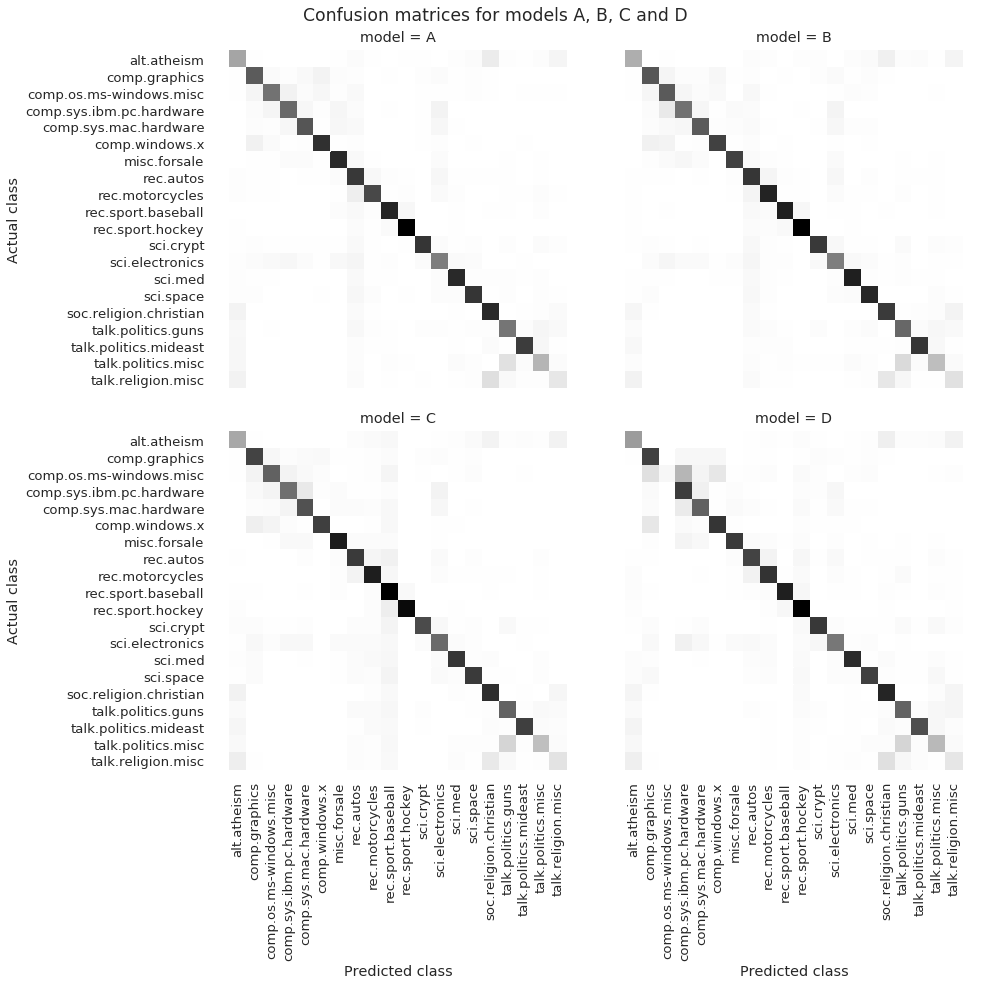

In [236]:
#%%############################################################################

###############################################################################
# 
# Confusion matrices visualised as heatmaps
#
###############################################################################

g20 = draw_faceted_confusion_matrix(confusion_matrices, annotated=False)

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g20.fig.savefig(os.path.join(WRK_DIR, 'chart_20.pdf'))

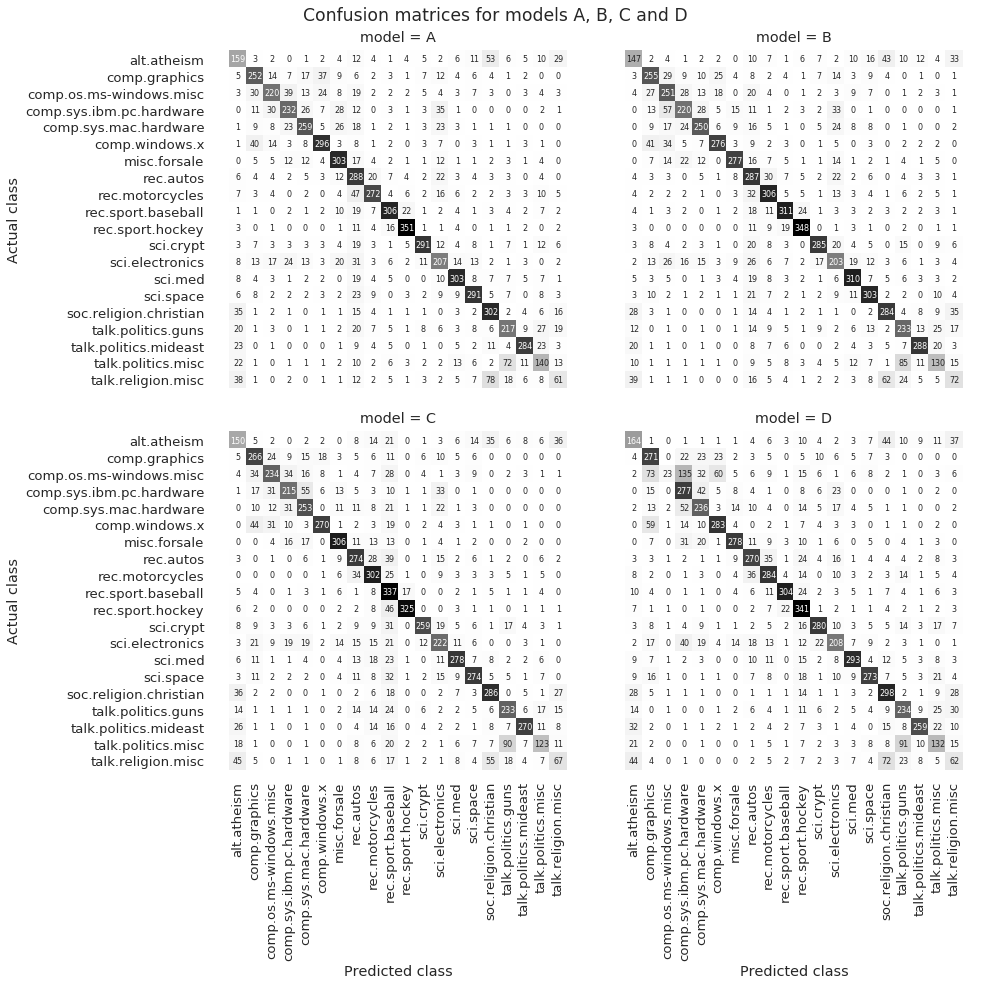

In [237]:
#%%############################################################################

###############################################################################
# 
# Confusion matrices visualised as heatmaps (with annotations)
#
###############################################################################

g21 = draw_faceted_confusion_matrix(confusion_matrices, annotated=True)

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g21.fig.savefig(os.path.join(WRK_DIR, 'chart_21.pdf'))

The next step is to calculate Information Gain (or alternatively the equivalent Mutual Information) from the confusion matrices for each model.

In [0]:
#%%############################################################################

###############################################################################
# 
# Functions for calculating Entropy and Mutual Information
#    from a confusion matrix.
#
###############################################################################

#
# Entropy from confusion matrix
#
def entropy_of_confusion_matrix(cmatrix):
  ''' Calculates Entropy (H) from a confusion matrix as deliverd by
      Scikit-learn confusion_matrix(X,Y) function.
      Row labels are real classes. Column labels are predicted classes
      
      Paramters:
      - cmatrix: a numpy square matrix of integers
      
      Returns:
      - Entropy (a float)
  '''
  
  cmatrix_T = np.transpose(cmatrix)
  
  # Now rows are predicted classes and columns are real classes

  # Sum all the occurrences
  total = cmatrix_T.sum()
  
  # Sum ocurrences per row (collapse columns)
  num_per_class = cmatrix_T.sum(axis=-1)
  
  weighted_entropy_per_class = [prior * H(row) for prior, row in list( zip(num_per_class/total , list(cmatrix_T)))]
  
  return sum(weighted_entropy_per_class)

#
# Mutual information
#
def mutual_information_of_confusion_matrix(cmatrix):
    ''' Calculates Mutual Information  from a confusion matrix as deliverd by
        Scikit-learn confusion_matrix(X,Y) function.
        Row labels are real classes. Column labels are predicted classes.
        https://en.wikipedia.org/wiki/Mutual_information
        
        Paramters:
        - cmatrix: a numpy square matrix of integers
      
        Returns:
        - Mutual Information (a float)
    '''
    
    total = cmatrix.sum()
    
    priors = cmatrix.sum(axis=1)/total
    evidences = cmatrix.sum(axis=0)/total
    
    def plog2(pxy, px, py):
        if pxy == 0.0:
            return 0
        else:
            return (pxy * log( pxy/(px*py) ,2) )
    
    acc = 0
    for i in range(20):
        for j in range(20):
            v = cmatrix[i,j]
            kk = plog2( v/total, priors[i], evidences[j] ) 
            acc += kk

    return acc

We finally can calculate entropies and Information Gain from the confusion matrices.

In [239]:
#%%############################################################################

###############################################################################
# 
# Entropy for each model, Entropy differences (Information Gain) 
#     and equivalent Mutual Information
#
###############################################################################

modelA_entropy = entropy_of_confusion_matrix(cmatrixA)
modelB_entropy = entropy_of_confusion_matrix(cmatrixB)
modelC_entropy = entropy_of_confusion_matrix(cmatrixC)
modelD_entropy = entropy_of_confusion_matrix(cmatrixD)

entropies = modelA_entropy, modelB_entropy, modelC_entropy, modelD_entropy, entropy_test
print(f'entropies: {entropies}')
print(f'differences: {[e - modelA_entropy for e in entropies]}')

miA = mutual_information_of_confusion_matrix(cmatrixA)
miB = mutual_information_of_confusion_matrix(cmatrixB)
miC = mutual_information_of_confusion_matrix(cmatrixC)
miD = mutual_information_of_confusion_matrix(cmatrixD)

print(f'mutual information: {miA, miB, miC, miD}')
print(f'differences: {miA-miA,miA-miB,miA- miC, miA - miD}')

entropies: (1.9874769996102617, 1.9700090483694104, 2.0114225427185985, 2.077088587858568, 4.314039382670442)
differences: [0.0, -0.01746795124085132, 0.023945543108336853, 0.08961158824830617, 2.3265623830601805]
mutual information: (2.3265623830601814, 2.344030334301031, 2.3026168399518467, 2.2369507948118743)
differences: (0.0, -0.017467951240849544, 0.023945543108334633, 0.08961158824830706)


## Summary of scores: accuracy and information gain

The  scores, Accuracy and Information Gain, are summarised in the table below. Observe that Information Gain is equivalent to Mutual Information.

In [241]:
#%%############################################################################

###############################################################################
# 
# Entropy for each model, Entropy differences (Information Gain) 
#     and equivalent Mutual Information
#
###############################################################################

df_entropies = pd.DataFrame({'Model': ['A', 'B', 'C', 'D', 'dataset'],
                             'Accuracy': [modelA_score, modelB_score, modelC_score, modelD_score, None],
                             'Entropy': [modelA_entropy, modelB_entropy, modelC_entropy, modelD_entropy, entropy_test],
                             'Mutual Information': [miA, miB, miC, miD, 0],
                             'Information Gain': [entropy_test - modelA_entropy, 
                                                  entropy_test - modelB_entropy,
                                                  entropy_test - modelC_entropy,
                                                  entropy_test - modelD_entropy,
                                                  0]
                            })

df_entropies['(IG - MI)/IG'] = ( df_entropies['Information Gain'] - df_entropies['Mutual Information'] ) / df_entropies['Information Gain']
df_entropies = df_entropies[['Model', 'Accuracy', 'Entropy', 'Information Gain', 'Mutual Information', '(IG - MI)/IG']]

df_entropies.replace(np.NaN, '')

,Model,Accuracy,Entropy,Information Gain,Mutual Information,(IG - MI)/IG
0,A,0.668348,1.987477,2.326562,2.326562,-3.81756e-16
1,B,0.668614,1.970009,2.344030,2.344030,3.78911e-16
2,C,0.656399,2.011423,2.302617,2.302617,-1.35004e-15
3,D,0.633298,2.077089,2.236951,2.236951,0
4,dataset,,4.314039,0.000000,0.000000,


See below, visualised, how Model B seems to be the best in terms of Information Gain, followed by Model A. However, **stochastic processes are present in training neural nets, so we need to include variance in our analysis**. We deal with that in the next section.

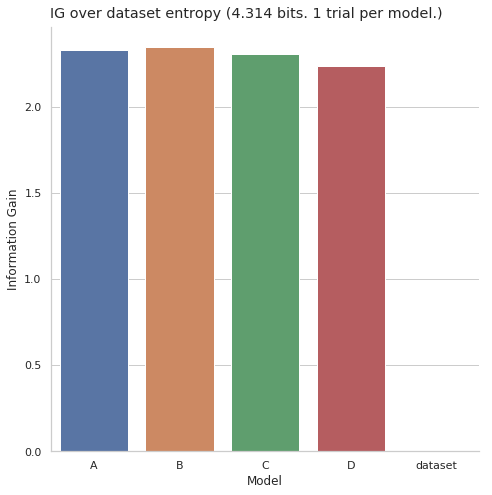

In [242]:
#%%############################################################################

###############################################################################
# 
# Information Gain for models A, B, C and D wihtout variance analysis
#
###############################################################################

sns.set(style="whitegrid")
g22 = sns.catplot(x="Model", y="Information Gain", kind='bar', height=7 , 
                  data=df_entropies[:5])
g22.fig.suptitle(f'IG over dataset entropy ({entropy_test:.3f} bits. 1 trial per model.)')
plt.subplots_adjust(top=.94)

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g22.fig.savefig(os.path.join(WRK_DIR, 'chart_22.pdf'))

# Variance Analysis

Summary of model configuration:

|Model|          |	        |			 |        |     |
|---  |---       |---       |---         |---     |---  |
|  A  |Tokenizer |Embeddings|CNN Layer   |Max Pool|Dense|
|  B  |Tokenizer|Embeddings|CNN Layer(1)|Max Pool|Dense|
|C    |Tokenizer |Embeddings|Average     |Dense   |     |
|D    |Tokenizer |TFIDF     |Naïve Bayes |        |     |

Summary of hyperparameter values used for each model.

In [243]:
#%%############################################################################

###############################################################################
# 
# Final hyperparameter values per model
#
###############################################################################

model_summary = pd.DataFrame([paramsA, paramsB, paramsC, paramsD], index=['A', 'B', 'C', 'D']).replace(np.nan, '')
model_summary.index.name = 'model'
model_summary = model_summary[['model_flavour', 'embedding_preload', 'embedding_train', 'cnn_filter_size', 'cnn_num_filters', 'batch_size', 'optimizer', 'epochs', 'alpha']]

model_summary

,model_flavour,embedding_preload,embedding_train,cnn_filter_size,cnn_num_filters,batch_size,optimizer,epochs,alpha
model,,,,,,,,,
A,CNN-DENSE,True,True,2,600,128,nadam,30,
B,CNN-DENSE,True,True,1,600,128,nadam,30,
C,AVG-DENSE,True,True,,,128,nadam,1000,
D,NAIVE-BAYES,,,,,,,,0.8


In [0]:
#%%############################################################################

###############################################################################
# 
# Helper functions for running variance analysis
#
###############################################################################


def get_model_case(params):
    ''' Gets model case (A, B, C, D) from single hyperparameter combination
    
        Parameters:
        - params: single hyperparameter combination
        
        Returns:
        - Model case ('A', 'B', 'C', 'D')
    '''
   
    model_flavour = params['model_flavour']
    #
    # Derive which model we are dealing with (A,B,C,D)
    #
    if model_flavour == 'NAIVE-BAYES':
        model_case = 'D'
    elif model_flavour == 'AVG-DENSE':
        model_case = 'C'
    elif model_flavour == 'CNN-DENSE':
        if params['cnn_filter_size'] == 1:
            model_case = 'B'
        else:
            model_case = 'A'
    else:
        raise Exception(f'Unknown model flavour: {model_flavour}')
    
    return model_case


def train_and_score_model(params, X_train, Y_train, X_test, Y_test):
    ''' Trains a model and calculates score on the test dataset
  
        Parameters:
        - params: single hyperparameter combination for the model
        - X_train, Y_train, X_test, Y_test: input and target matrices
      
        Returns:
        - A dict with fields:
          - params: same as input
          - score_accuracy: accuracy on the test dataset
          - score_information_gain: information gain on the original
          - score_entropy: entropy of the resulting confusion matrix
          - model: instance of the trained model
          - model_case: whether it is model A, B, C, or D
          - training_report: same report training as used in this notebook
    '''
    

    model_case = get_model_case(params)
    model_flavour = params['model_flavour']
    
    print(f'Train and evaluate Model {model_case} with params: {params}')
    
    start_time = datetime.now()
    #
    # Create instance of model and train
    #
    report, model = create_and_train_model(params, X_train, Y_train)
    
    #
    # Get score on test dataset (accuracy)
    #
    t_start_1 = datetime.now()
    
    # Ugly: Keras and Sklearn do not share the same interface.
    # Let's try to keep it simple tough...
    if model_flavour == 'NAIVE-BAYES':
        accuracy = model.score(X_test, Y_test)
    else: 
        loss, accuracy = model.evaluate(X_test, Y_test)
    
    t_end_1 = datetime.now()
    testing_time_score = t_end_1 - t_start_1
    
    #
    # Calculate information gain
    #
    t_start_2 = datetime.now()
    
    Y_prediction = model.predict(X_test)
    if model_flavour == 'NAIVE-BAYES':
        Y_prediction_categorical = Y_prediction
        Y_test_categorical = Y_test
    else: 
        # In these cases of model flavour we had a 1-hot encoding prediction,
        # and we need to convert to categorical.
        Y_prediction_categorical = np.asarray( Y_prediction.argmax(axis=-1) )
        Y_test_categorical = np.asarray( Y_test.argmax(axis=-1) )

    cmatrix = confusion_matrix(Y_test_categorical, Y_prediction_categorical)
    information_gain = mutual_information_of_confusion_matrix(cmatrix)
    entropy = entropy_of_confusion_matrix(cmatrix)
    
    t_end_2 = datetime.now()
    testing_time_infogain = t_end_2 - t_start_2
    
    return {'model': model_case,
            'params': params,
            'score_accuracy': accuracy,
            'score_information_gain': information_gain,
            'score_entropy': entropy,
            'model_flavour': model_flavour,
            'start_time': start_time,
            'training_time': report['training_time'],
            'testing_time_score': testing_time_score
           }

    
def run_variance_analysis(params, repetitions):
    ''' Performs variance analysis of the scores of different models
    
        Parameters:
        - params: a LIST of hyperparameter combinations, one for each model
        - repetitions: number of times each model is trained and evaluated
        
        Returns:
        - List of dicts as they are returned from train_and_score_model()
    '''

    model_cases = [get_model_case(p) for p in params]
    print(f'VARIANCE ANALYSIS:')
    print(f'Evaluating models {model_cases}, {repetitions} times each. {len(model_cases)*repetitions} iterations ahead.')
    
    #
    # Mutable stuff here. Be careful!
    #
    result = []
    counter = 0
    #
    # Iterate models
    #
    for p in params:
      
        model_flavour = p['model_flavour']
          
        if model_flavour == 'NAIVE-BAYES':
            X_train_ = X_tfidf_train
            X_test_ = X_tfidf_test
            Y_train_ = Y_train
            Y_test_ = Y_test
        elif model_flavour == 'CNN-DENSE' \
            or p['model_flavour'] == 'AVG-DENSE':
            X_train_ = X_seqs_train
            X_test_ = X_seqs_test
            Y_train_ = Y_1hot_train
            Y_test_ = Y_1hot_test
        else:
            raise Exception(f'Invalid model flavour: {p["model_flavour"]}')
            
        #
        # Repetitions for each model
        #
        for i in range(repetitions):
            counter += 1
            print("________________________________________________________________________________")
            print()
            print(f'Train and evaluate: ITERATION {counter}')
            r = train_and_score_model(p, X_train_, Y_train_, X_test_, Y_test_)
            print(f'{model_flavour} ({i+1}) accuracy: {r["score_accuracy"]}, information gain: {r["score_information_gain"]}\n')
            result.append(r)

    return result

We now proceed to run the model evaluation process taking variance into account. We will repeat the process of training and evaluating each model 10 times. 

The following cell runs the training session and saves the training reports to a timestamped file. 

WARNING: It can take quite a long time, even running with support of a GPU.  **Skip it if you just want to retrieve the result from a previous report file**.

In [0]:
#%%############################################################################

###############################################################################
# 
# Run variance analysis (train and evaluation with repetitions)
#
###############################################################################

variance_results = run_variance_analysis([paramsA, paramsB, paramsC, paramsD], 5)
save_report(variance_results, os.path.join(WRK_DIR, f'VARIANCE_ANALYSIS_{make_timestamp()}'))

We then recover the results from report files. See how we aggregate the results for two different session of 5 repetitions into a combined report of 10 repetitions per model.

In [0]:
#%%############################################################################

###############################################################################
# 
# Recover results for training + evaluation from files
#
###############################################################################

variance_results_recovered = load_report(os.path.join(WRK_DIR, 'VARIANCE_ANALYSIS_20181229144242')) +\
                             load_report(os.path.join(WRK_DIR, 'VARIANCE_ANALYSIS_20181230120812'))

In [247]:
#%%############################################################################

###############################################################################
# 
# Reports expressed as a DataFrame
#
###############################################################################

df_variance = pd.DataFrame(variance_results_recovered).rename({'model': 'Model',
                                                               'model_flavour': 'Model flavour',
                                                               'params': 'Parameters',
                                                               'score_accuracy': 'Accuracy',
                                                               'score_entropy': 'Entropy',
                                                               'score_information_gain': 'Information Gain',
                                                               'start_time': 'Start time',
                                                               'testing_time_score': 'Time spent testing',
                                                               'training_time': 'Time spent training'
                                                              }, axis='columns')
test_trials_per_model = int(len(df_variance)/len(MODELS))
print(f'{len(MODELS)} models: {MODELS}. {test_trials_per_model} trials per model.')
df_variance.drop(['Parameters'], axis=1)

4 models: ['A', 'B', 'C', 'D']. 10 trials per model.


,Model,Model flavour,Accuracy,Entropy,Information Gain,Start time,Time spent testing,Time spent training
0,A,CNN-DENSE,0.669543,1.977555,2.336485,2018-12-29 12:20:58.556409,00:00:02.663443,00:05:47.999595
1,A,CNN-DENSE,0.675783,1.951578,2.362461,2018-12-29 12:26:52.015372,00:00:02.653186,00:05:46.452122
2,A,CNN-DENSE,0.672066,1.961948,2.352091,2018-12-29 12:32:43.968824,00:00:02.697453,00:05:45.893256
3,A,CNN-DENSE,0.672066,1.968544,2.345495,2018-12-29 12:38:35.493303,00:00:02.682158,00:05:45.738788
4,A,CNN-DENSE,0.668747,1.977069,2.336970,2018-12-29 12:44:26.934072,00:00:02.684363,00:05:50.258730
5,B,CNN-DENSE,0.654541,2.028039,2.286001,2018-12-29 12:50:22.990851,00:00:02.006860,00:04:25.324826
6,B,CNN-DENSE,0.651885,2.045461,2.268578,2018-12-29 12:54:52.835479,00:00:02.008208,00:04:25.114508
7,B,CNN-DENSE,0.663038,2.000159,2.313880,2018-12-29 12:59:22.608485,00:00:02.015032,00:04:25.871798
8,B,CNN-DENSE,0.654010,2.036200,2.277840,2018-12-29 13:03:53.237411,00:00:01.980056,00:04:25.278194
9,B,CNN-DENSE,0.656930,2.026801,2.287238,2018-12-29 13:08:23.350943,00:00:02.019049,00:04:26.290673


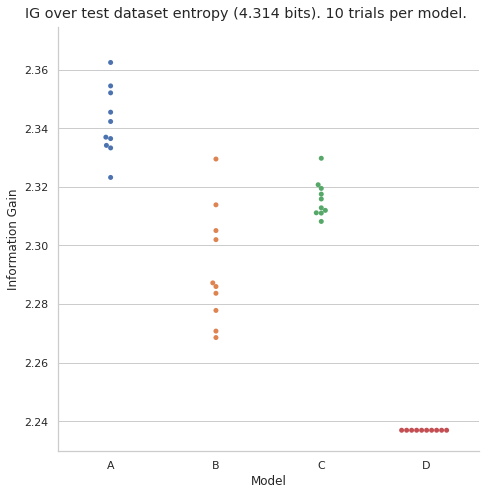

In [248]:
#%%############################################################################

###############################################################################
# 
# Plot Information Gain for each trial, per model
#
###############################################################################


sns.set(style="whitegrid")
g23 = sns.catplot(x="Model", y="Information Gain", kind='swarm', height=7, data=df_variance)
g23.fig.suptitle(f'IG over test dataset entropy ({entropy_test:.3f} bits). {test_trials_per_model} trials per model.')
plt.subplots_adjust(top=.94)
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g23.fig.savefig(os.path.join(WRK_DIR, 'chart_23.pdf'))

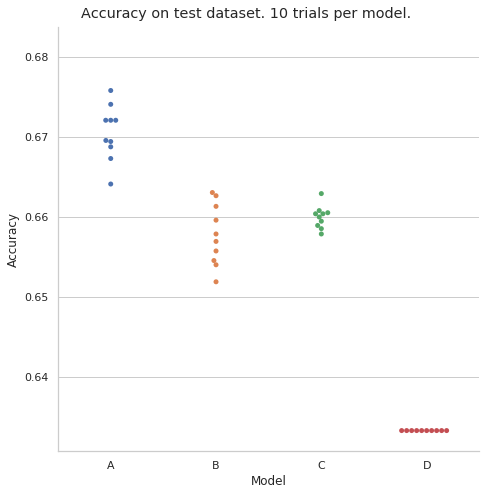

In [249]:
#%%############################################################################

###############################################################################
# 
# Plot Accuracy for each trial, per model
#
###############################################################################

sns.set(style="whitegrid")
g24 = sns.catplot(x="Model", y="Accuracy", kind='swarm', height=7, data=df_variance)
g24.fig.suptitle(f'Accuracy on test dataset. {test_trials_per_model} trials per model.')
plt.subplots_adjust(top=.94)
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g24.fig.savefig(os.path.join(WRK_DIR, 'chart_24.pdf'))

## Confidence intervals of means

We calculate statistics of the training-evaluation trials, both for Accuracy and Information Gain.

In [255]:
#%%############################################################################

###############################################################################
# 
# Information Gain statistics, per model
#
###############################################################################

df_variance_stats_IG = df_variance[['Model', 'Information Gain']].groupby('Model').describe()
df_variance_stats_IG

Information Gain                                                    \
                 count      mean       std       min       25%       50%   
Model                                                                      
A                 10.0  2.342098  0.011706  2.323228  2.334745  2.339641   
B                 10.0  2.292462  0.019669  2.268578  2.279303  2.286619   
C                 10.0  2.315868  0.006331  2.308212  2.311366  2.314366   
D                 10.0  2.236951  0.000000  2.236951  2.236951  2.236951   

                           
            75%       max  
Model                      
A      2.350442  2.362461  
B      2.304321  2.329511  
C      2.318996  2.329768  
D      2.236951  2.236951

In [256]:
#%%############################################################################

###############################################################################
# 
# Accuracy statistics, per model
#
###############################################################################


df_variance_stats_ACC = df_variance[['Model', 'Accuracy']].groupby('Model').describe()
df_variance_stats_ACC

Accuracy                                                        \
         count      mean           std       min       25%       50%   
Model                                                                  
A         10.0  0.670512  3.405699e-03  0.664100  0.668913  0.670805   
B         10.0  0.657754  3.820262e-03  0.651885  0.654839  0.657395   
C         10.0  0.659971  1.407092e-03  0.657860  0.659055  0.660183   
D         10.0  0.633298  1.170278e-16  0.633298  0.633298  0.633298   

                           
            75%       max  
Model                      
A      0.672066  0.675783  
B      0.660880  0.663038  
C      0.660482  0.662905  
D      0.633298  0.633298

We represent the results visualising means of Accuracy and Information Gain, per model, with their associated confidence intervals.

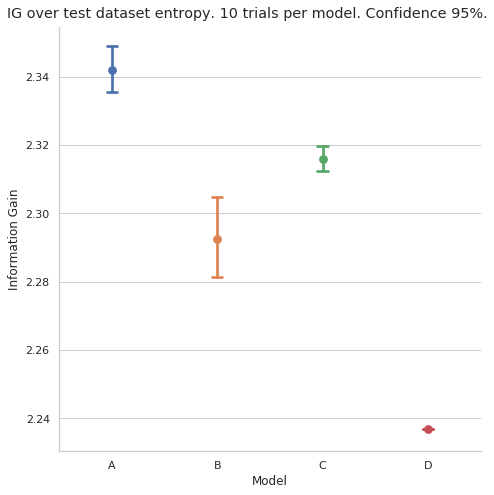

In [250]:
#%%############################################################################

###############################################################################
# 
# Plot mean Information Gain with confidence intervals, per model
#
###############################################################################

sns.set(style="whitegrid")
g25 = sns.catplot(x='Model', y='Information Gain', hue='Model', 
                  kind='point', ci=CONFIDENCE_LEVEL, capsize=.1, height=7,
                  data=df_variance)
g25.fig.suptitle(f'IG over test dataset entropy. {test_trials_per_model} trials per model. Confidence {CONFIDENCE_LEVEL}%.')
plt.subplots_adjust(top=.94)
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g25.fig.savefig(os.path.join(WRK_DIR, 'chart_25.pdf'))

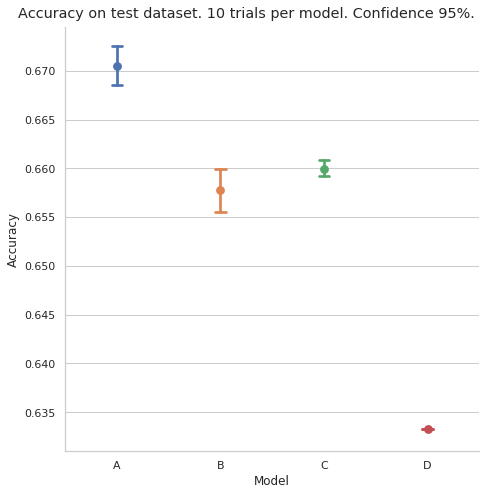

In [257]:
#%%############################################################################

###############################################################################
# 
# Plot mean Accuracy with confidence intervals, per model
#
###############################################################################

sns.set(style="whitegrid")
g26 = sns.catplot(x='Model', y='Accuracy', hue='Model', 
                  kind='point', ci=CONFIDENCE_LEVEL, capsize=.1, height=7,
                  data=df_variance)
g26.fig.suptitle(f'Accuracy on test dataset. {test_trials_per_model} trials per model. Confidence {CONFIDENCE_LEVEL}%.')
plt.subplots_adjust(top=.94)
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g26.fig.savefig(os.path.join(WRK_DIR, 'chart_26.pdf'))

## T-test analysis

As we see that two of the confidence intervals overlap in the Accuracy chart, we perform a t-test analysis for the mean results for Accuracy and Information Gain, for all the model pairs.

In [259]:
#%%############################################################################

###############################################################################
# 
# Plot Information Gain for each trial, per model
#
###############################################################################

MODELS = ['A', 'B', 'C', 'D']
ALPHA = .05

p_values = [{'Model 1': m1, 
             'Model 2': m2,
             'Score': 'Accuracy',
             'P': t_test(df_variance[df_variance['Model'] == m1]['Accuracy'],
                         df_variance[df_variance['Model'] == m2]['Accuracy'],
                         silent=True)
             } for m1 in MODELS for m2 in MODELS]
p_values += [{'Model 1': m1, 
              'Model 2': m2,
              'Score': 'Information Gain',
              'P': t_test(df_variance[df_variance['Model'] == m1]['Information Gain'],
                          df_variance[df_variance['Model'] == m2]['Information Gain'],
                          silent=True)
              } for m1 in MODELS for m2 in MODELS]
df_p_matrix = pd.DataFrame(p_values)[['Model 1', 'Model 2', 'Score', 'P']]
df_p_matrix

,Model 1,Model 2,Score,P
0,A,A,Accuracy,1.000000e+00
1,A,B,Accuracy,3.298445e-07
2,A,C,Accuracy,1.055049e-06
3,A,D,Accuracy,7.030243e-11
4,B,A,Accuracy,3.298445e-07
5,B,B,Accuracy,1.000000e+00
6,B,C,Accuracy,1.120230e-01
7,B,D,Accuracy,8.160061e-09
8,C,A,Accuracy,1.055049e-06
9,C,B,Accuracy,1.120230e-01


In [0]:
#%%############################################################################

###############################################################################
# 
# Helper function to plot p-value matrices as heatmaps
#
###############################################################################

def draw_faceted_pvalue_matrix(pvalue_matrix, trials_per_model, annotated=True, center=.05):
        
    g = sns.FacetGrid(pvalue_matrix, col='Score', height=6, col_wrap=2)
    g.map_dataframe(draw_heatmap, 'Model 1', 'Model 2', 'P', cbar=False, 
                                                             square=True, 
                                                             annot=annotated,
                                                             annot_kws={"size": 16},
                                                             linewidths=1.5,
                                                             center=center,
                                                             triangular=True,
                                                             cmap=colors.ListedColormap(['whitesmoke', 'pink']),
                                                             fmt='.5f')
    g.set_axis_labels('Model', 'Model')
    plt.subplots_adjust(top=0.90)
    g.fig.suptitle(f'P-values for test scores. {trials_per_model} trials/model. P-values higher than the significance level ({center}) highlighted.')
    
    return g

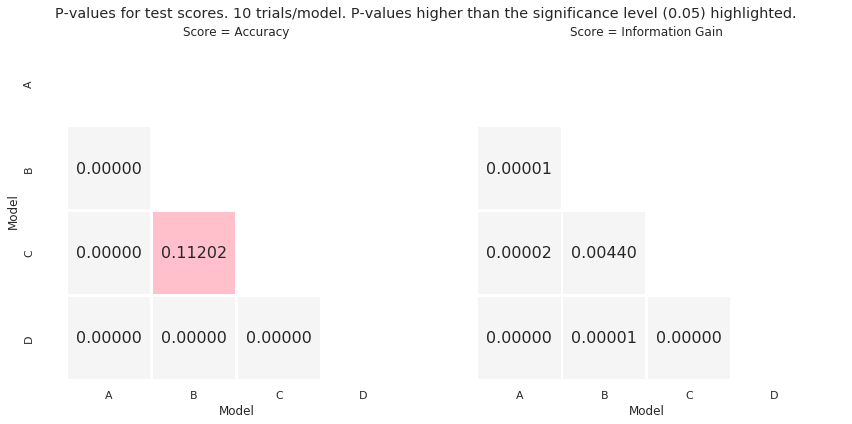

In [261]:
#%%############################################################################

###############################################################################
# 
# Plot p-values matrices as heatmaps
#
###############################################################################

g28 = draw_faceted_pvalue_matrix(df_p_matrix, test_trials_per_model, 
                                 center=(100-CONFIDENCE_LEVEL)/100)

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g28.fig.savefig(os.path.join(WRK_DIR, 'chart_28.pdf'))

## Justification

From the figures and tables above we can make the following observations:

-   Model A shows the best results, both for *accuracy*, 67.1%, and
    *information gain*, **2.342 bits** (to be subtracted from the
    original entropy of the dataset, 4.314 bits).

-   Model C shows the worst score, as expected. *Accuracy* of 63.3%
    (3.8% worse than Model A), and *information gain*, **2.237 bits**
    (0.105 bits worse than Model A).

-   Model B and C lie somewhere in the middle both in terms of
    *accuracy* and *information gain*.

-   Within our confidence level (95%) we are quite confident that Model
    A is significantly better than the rest of them, and that Model D is
    significantly worse. See how their confidence intervals (A and D) do
    not overlap with any other model.

-   Within our confidence level, we cannot affirm that model B is better
    than C nor C better than B. Whereas for information gain the
    confidence intervals do not overlap, for accuracy they do.

-   We formalized the observations above by performing a 2-tail t-test
    for all possible model combinations. Figure \[fig:pvalues\] shows
    the p-values we obtained. Observe how the only case in which the
    p-value is higher than the significance level (0.05) is the
    combination of models B and C, for which the p-value is 0.11
    (greater than 0.05). Therefore we cannot reject the *null
    hypothesis* in this case and cannot say that any of the two models
    (B and C) is better than the other.

The main takeaway here is that we have proved that **our convolutional
model with 600 convolutional filters of size 2 (Model A) is not only
better than the other 3 models in terms of accuracy and information
gain, but also that we have some basis to affirm that it can extract
some additional information which is positionally encoded**, and which
the rest of the models (B, C and D) cannot extract. However, we have to
be aware according to Table \[tab:results\] that the improvement in
accuracy is around 1.3% over model B, and **the extra information over
model B is only 0.05 bits**. We see two interpretations to this:

-   either that our model is relatively good extracting positional
    information from text but there is not a lot of positional
    information to be extracted in our dataset [^2],

-   or that there is more positional information than 0.05 bits in our
    dataset but our convolutional model is not able to extract it.


## Time analysis



In [262]:
#%%############################################################################

###############################################################################
# 
# Retrieve training and prediction times from reports
#
###############################################################################


df_variance['Training time (seconds)'] = df_variance['Time spent training'].apply(lambda x: x.total_seconds())
df_variance['Testing time (seconds)'] = df_variance['Time spent testing'].apply(lambda x: x.total_seconds())

df_variance[['Model', 'Accuracy', 'Information Gain', 'Training time (seconds)', 'Testing time (seconds)']]

,Model,Accuracy,Information Gain,Training time (seconds),Testing time (seconds)
0,A,0.669543,2.336485,347.999595,2.663443
1,A,0.675783,2.362461,346.452122,2.653186
2,A,0.672066,2.352091,345.893256,2.697453
3,A,0.672066,2.345495,345.738788,2.682158
4,A,0.668747,2.336970,350.258730,2.684363
5,B,0.654541,2.286001,265.324826,2.006860
6,B,0.651885,2.268578,265.114508,2.008208
7,B,0.663038,2.313880,265.871798,2.015032
8,B,0.654010,2.277840,265.278194,1.980056
9,B,0.656930,2.287238,266.290673,2.019049


In [263]:
#%%############################################################################

###############################################################################
# 
# Training time statistics
#
###############################################################################

df_variance_stats_TRTIME = df_variance[['Model', 'Training time (seconds)']].groupby('Model').describe()
df_variance_stats_TRTIME

Training time (seconds)                                       \
                        count         mean        std          min   
Model                                                                
A                        10.0   339.592229   8.343755   329.927728   
B                        10.0   261.926854   3.944184   256.761853   
C                        10.0  1125.937130  88.646874  1023.160197   
D                        10.0     0.827260   0.066793     0.755834   

                                                           
               25%          50%          75%          max  
Model                                                      
A       331.424599   340.852757   346.312406   350.258730  
B       258.377401   262.547489   265.313168   266.290673  
C      1048.268941  1097.297984  1218.204075  1231.254375  
D         0.763712     0.832645     0.889945     0.895864

In [264]:
#%%############################################################################

###############################################################################
# 
# Prediction time statistics
#
###############################################################################

df_variance_stats_TETIME = df_variance[['Model', 'Testing time (seconds)']].groupby('Model').describe()
df_variance_stats_TETIME

Testing time (seconds)                                          \
                       count      mean       std       min       25%   
Model                                                                  
A                       10.0  2.625343  0.056114  2.554509  2.572567   
B                       10.0  1.970002  0.039237  1.929879  1.934373   
C                       10.0  0.479086  0.016069  0.453779  0.468919   
D                       10.0  0.381433  0.018125  0.356743  0.369032   

                                     
            50%       75%       max  
Model                                
A      2.628090  2.677479  2.697453  
B      1.960584  2.007871  2.019049  
C      0.479109  0.491081  0.503631  
D      0.377748  0.391319  0.415991

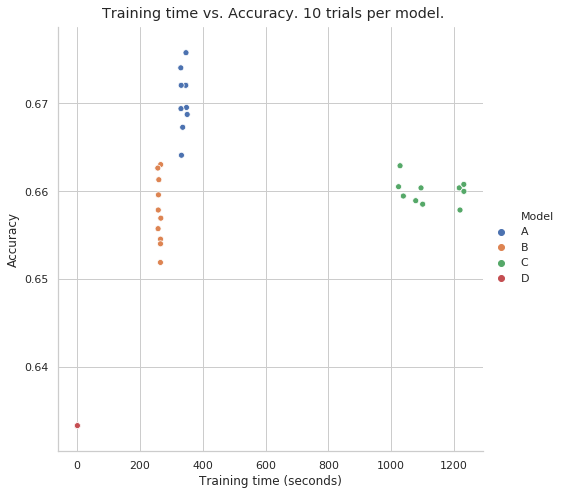

In [265]:
#%%############################################################################

###############################################################################
# 
# Plot training time vs. Accuracy, per model
#
###############################################################################

sns.set(style="whitegrid")
g29 = sns.relplot(y='Accuracy', x='Training time (seconds)', hue='Model',
                  height=7,
                  data=df_variance)
g29.fig.suptitle(f'Training time vs. Accuracy. {test_trials_per_model} trials per model.')
plt.subplots_adjust(top=.94)
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g29.fig.savefig(os.path.join(WRK_DIR, 'chart_29.pdf'))

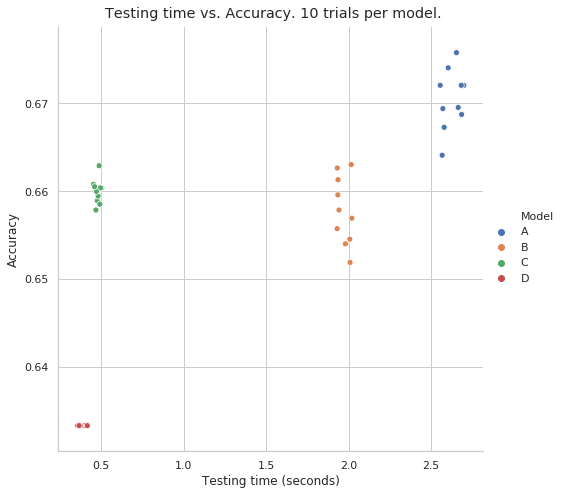

In [266]:
#%%############################################################################

###############################################################################
# 
# Plot prediction time vs. Acuracy, per model
#
###############################################################################


sns.set(style="whitegrid")
g30 = sns.relplot(y='Accuracy', x='Testing time (seconds)', hue='Model',
                  height=7,
                  data=df_variance)
g30.fig.suptitle(f'Testing time vs. Accuracy. {test_trials_per_model} trials per model.')
plt.subplots_adjust(top=.94)
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g30.fig.savefig(os.path.join(WRK_DIR, 'chart_30.pdf'))

## Correlation between Accuracy and Information Gain

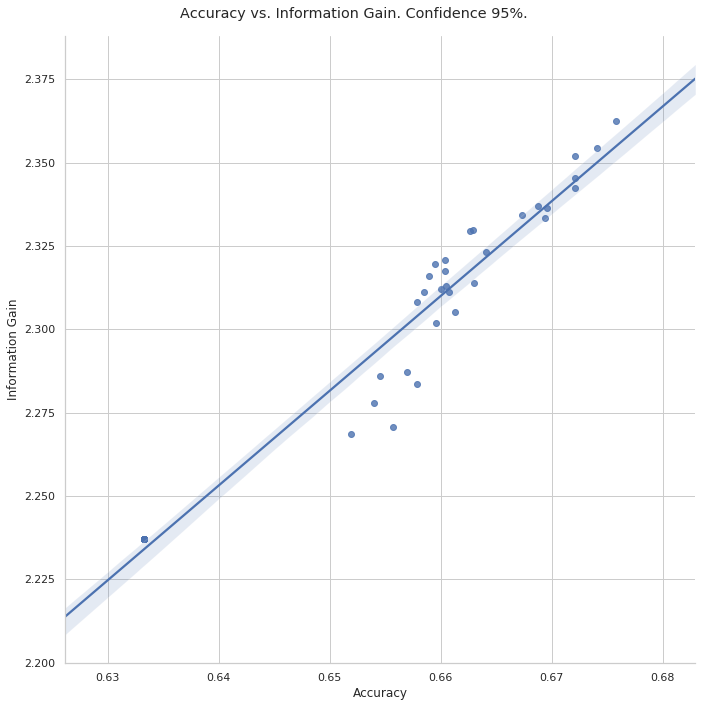

In [267]:
#%%############################################################################

###############################################################################
# 
# Plot regression between Accuracy and Information Gain
#
###############################################################################

sns.set(style="whitegrid")
g27 = sns.lmplot(x='Accuracy', y='Information Gain', 
                 ci=CONFIDENCE_LEVEL,
                 height=10,
                 data=df_variance)
g27.fig.suptitle(f'Accuracy vs. Information Gain. Confidence {CONFIDENCE_LEVEL}%.')
plt.subplots_adjust(top=.94)
None

In [0]:
#%%############################################################################

#
# Save figure to PDF
#

g27.fig.savefig(os.path.join(WRK_DIR, 'chart_27.pdf'))

In [268]:
#%%############################################################################

###############################################################################
# 
# Pearson's r - Accuracy and Information Gain
#
###############################################################################


rvalue = stats.linregress(df_variance['Accuracy'], df_variance['Information Gain']).rvalue

print(f"Pearson-r for accuracy and information gain is : {rvalue:.3f}")

Pearson-r for accuracy and information gain is : 0.976


# Conclusion

## Reflection

In this investigation we built a multi-class text classifier based on a
convolutional neural net (CNN), tried to find an optimal configuration
for it (which turned out to be 600 convolutional filters of size 2 and a
trainable embeddings layer pre-loaded with *GloVe* vectors of 100
dimensions), and trained it to classify documents of the *20 Newsgroups
dataset*. Then we compared its performance with two different carefully
trimmed-down versions of itself which by design were not able to extract
positional information from the documents. Our results confirmed that
our CNN model can extract some positional information. However, we also
realized that this improvement was modest and was mainly associated to
patterns of two consecutive words (bi-grams), as models with longer
filter sizes yielded worse scores. Finally, we compared our model with a
standard Naïve Bayes classifier, which performed 3.8% worse in terms of
accuracy and 0.105 bits worse regarding information gain.

The question arises then, if all the extra complexity an additional
resources needed by our CNN model (and even by our two trimmed-down
variants) is worth it when trying to implement them in a real production
environment. Along the training process, besides calculating scores
(accuracy and information gain), we also gathered data about the time
spent in training the model (“training time”) and the time spent in
calculating the accuracy score on the test dataset (“testing time”)
after the models were trained and loaded with the final weights. We can
use these values to compare relative training and prediction speeds
between models. See how the figures above visualize both training
and testing times versus the final accuracy score for each model and
each repetition in the evaluation process. From these figures we can
observe, without going into the detail of specific values, the
following:

-   The **fastest model to train and predict** is clearly Model D, the
    **Naïve Bayes** classifier.

-   The **convolutional models** (A,B) are **very slow to train**
    ($\sim$ 300 times slower than Model D) and **slow to predict**
    ($\sim$ 6 times slower than model D).

-   The **dense, non-convolutional model** (C), is **extremely slow to
    train** ($\sim$ 1200 times slower than Model D) but **very fast to
    predict** (almost as fast as Model D).

-   In addition we have to keep in mind that for these results, models
    A, B and C ran on GPU (Google Colab environment) and model D is
    built on top of Scikit-learn, which only runs on CPU. Thus, the
    differences between those ones and the latter must be much bigger in
    terms of computation resources usage.

The process of making a decision about which model is the best one
ultimately depends on the concrete use case, which could justify or not
the limited performance gains and the associated trade-offs in terms of
time and computation resources. If we are able to assign costs and
benefits to training and testing times, and also to true and false
positives and negatives in our classification outcome, then we could
apply the *Expected Value* framework ([@Provost], chapter 7) to find out
which model fits better our real-world scenario in terms of profits.

Finally, we would like to enumerate some interesting aspects about this
investigation that we believe are worth pointing out:

-   **Variance**. We learned that it is imperative to consider variance
    both in the hyperparamter selection process and also in performance
    assessment. We included confidence intervals in our analysis and
    visualizations, and performed t-tests and evaluated p-values in the
    critical parts. 

-   **Processing resources**. Training, and even evaluating neural
    networks, is extremely CPU intensive and, in consequence, GPU
    support is imperative. We had to resort to working in a Google Colab
    environment backed by GPUs to make it possible. Note how the
    variance issue aggravates the problem as it entails additional
    repetitions of training sessions.

-   **Information Gain**. We proposed *Information Gain* as the second
    evaluation score, as we believed it would best fit the problem of
    quantifying extraction of positional information. In the linear regression figure above
  we see how tightly correlated *accuracy* and *information gain* seem to be. We also calculated the Pearson’s r
    value: 0.976. We would be inclined to state that in the context of
    our problem both scores seem to be good proxies for each other.
    However, in figures showing confidence intervals on the final scores we see that
    while *information gain* could discriminate between models B and C
    with statistical significance, *accuracy* could not. We find this is
    an interesting finding to be further researched.

-   **Overfitting**. The best convolutional model in terms of
    performance turned out to be the one with the shortest filter
    size, 2. We learned that slightly longer filter sizes were not
    significantly better and that even longer filter sizes yielded worse
    scores. This can be explained if
    we assume that most of the positional information is encoded in
    bi-grams and also understanding that longer filters, even though
    they have the ability to *emulate* shorter ones, may easily
    tend to overfit and learn longer patterns from the documents that do
    not generalize.
    
## Improvement
    
Finally, in order to improve and continue this work, we recommend the
following lines:

-   Considering other models, arguably more suited to extract positional
    information from text, like Recurrent Neural Networks (RNN) with its
    variants GRU and LSTM [@Chollet].

-   Experimenting with more convolutional layers trying to give the
    model more abstraction power and check if that reverts into better
    ability to extract positional information.

-   Validating the proposed methodology on other datasets.

-   Considering some sort of sensitivity and robustness analysis beyond
    our variance analysis.

-   And most interestingly, trying to visualize and analyze the weights
    of the convolutional filters obtained for our Model A, and explain
    them in terms of the original vocabulary of our dataset. This way we
    may better understand the mechanisms underlying positional
    information extraction and we could also get valuable insights to
    try to validate our hypothesis that the improvement between Model A
    and B has to be mainly due to positional information.

